In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import re, os
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy as ap
from astropy import units
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


import gw_ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture_hdf5 as tc
import conversions
import dynamics as dyn
import scripts3
import scripts2
import scripts1
import scripts
import LISA_calculations as lisa_calc
import extract_full_hist as ehist
import psr_catalog as pc
import ns, ns_hdf5
import GC_rates as gcr


sys.path.insert(1, '/fs/lustre/cita/claireshiye')
import cmctoolkit as cmct

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 22})
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e+10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

savepath = '/fs/lustre/cita/claireshiye/projects/BBH_catalog/'

2.1.2


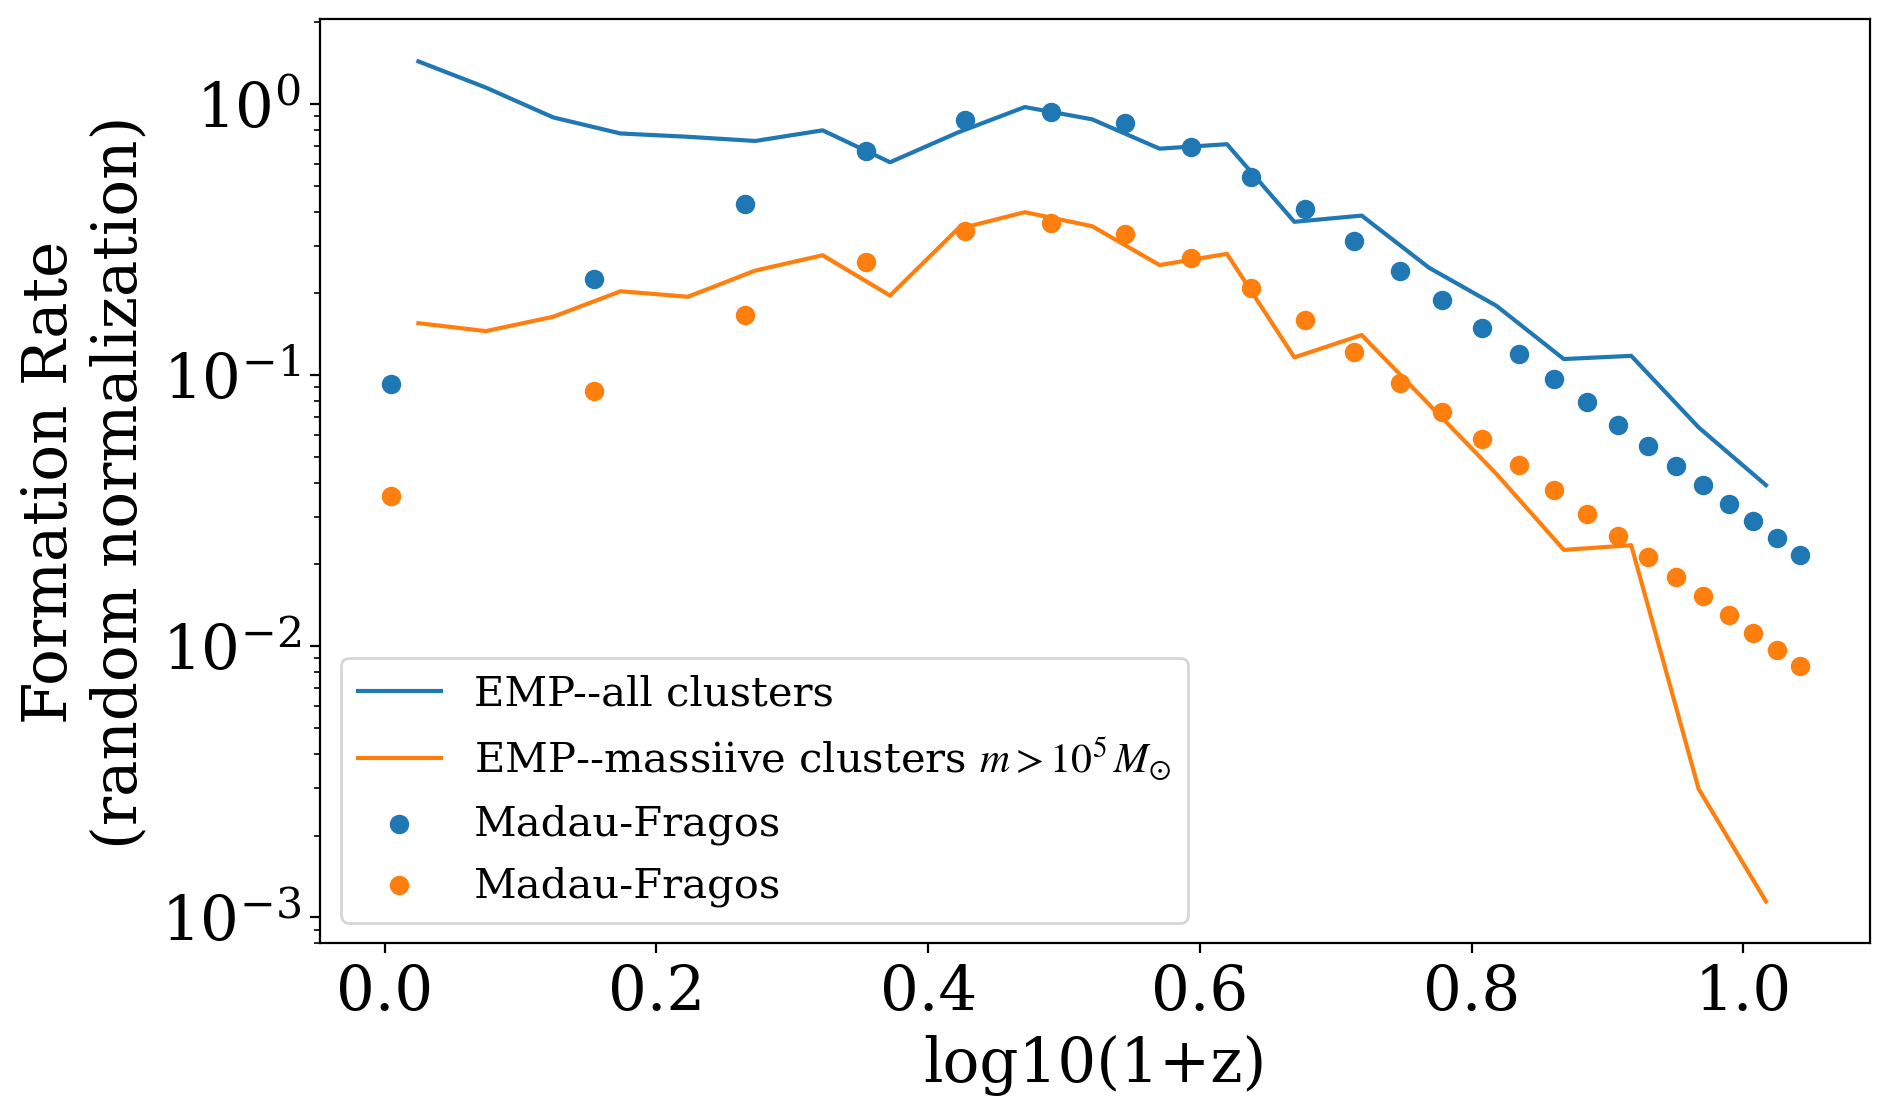

In [3]:
##Cluster formation rate
##Comparing Madau+Fragos 2017 with Reina-Campos+2022
zgrid = np.linspace(0.01, 10, 25)
gcr_grid = gcr.redshift_peak(zgrid, a = 2.6, b = 3.6, zp = 2.2)

data_cfr = np.genfromtxt(savepath+'table_initial_cfr_ctantsfe.txt')
data_gcfr = np.genfromtxt(savepath+'table_initial_gcfr_ctantsfe.txt')

fig, axs = plt.subplots(figsize=(10,6))
axs.plot(data_cfr[:,0], data_cfr[:,1], label='EMP--all clusters')
axs.plot(data_gcfr[:,0], data_gcfr[:,1], label='EMP--massiive clusters '+r'$m>10^5\,M_{\odot}$')
axs.scatter(np.log10(1+zgrid), 0.09*gcr_grid, label='Madau-Fragos')
axs.scatter(np.log10(1+zgrid), 0.035*gcr_grid, label='Madau-Fragos')
axs.set_yscale('log')
axs.set_ylabel('Formation Rate\n'+'(random normalization)')
axs.set_xlabel('log10(1+z)')
axs.legend(loc='best', fontsize=15)

In [2]:
##Chirp mass
def chirp_mass(m1, m2):
    Mchirp = ((m1*m2)**3/(m1+m2))**(1./5.)
    return Mchirp

def chi_eff(m1, m2, s1, s2, alpha, beta):
    return (m1*s1*np.cos(alpha)+m2*s2*np.cos(beta))/(m1+m2)

1411
4167
11234 11234


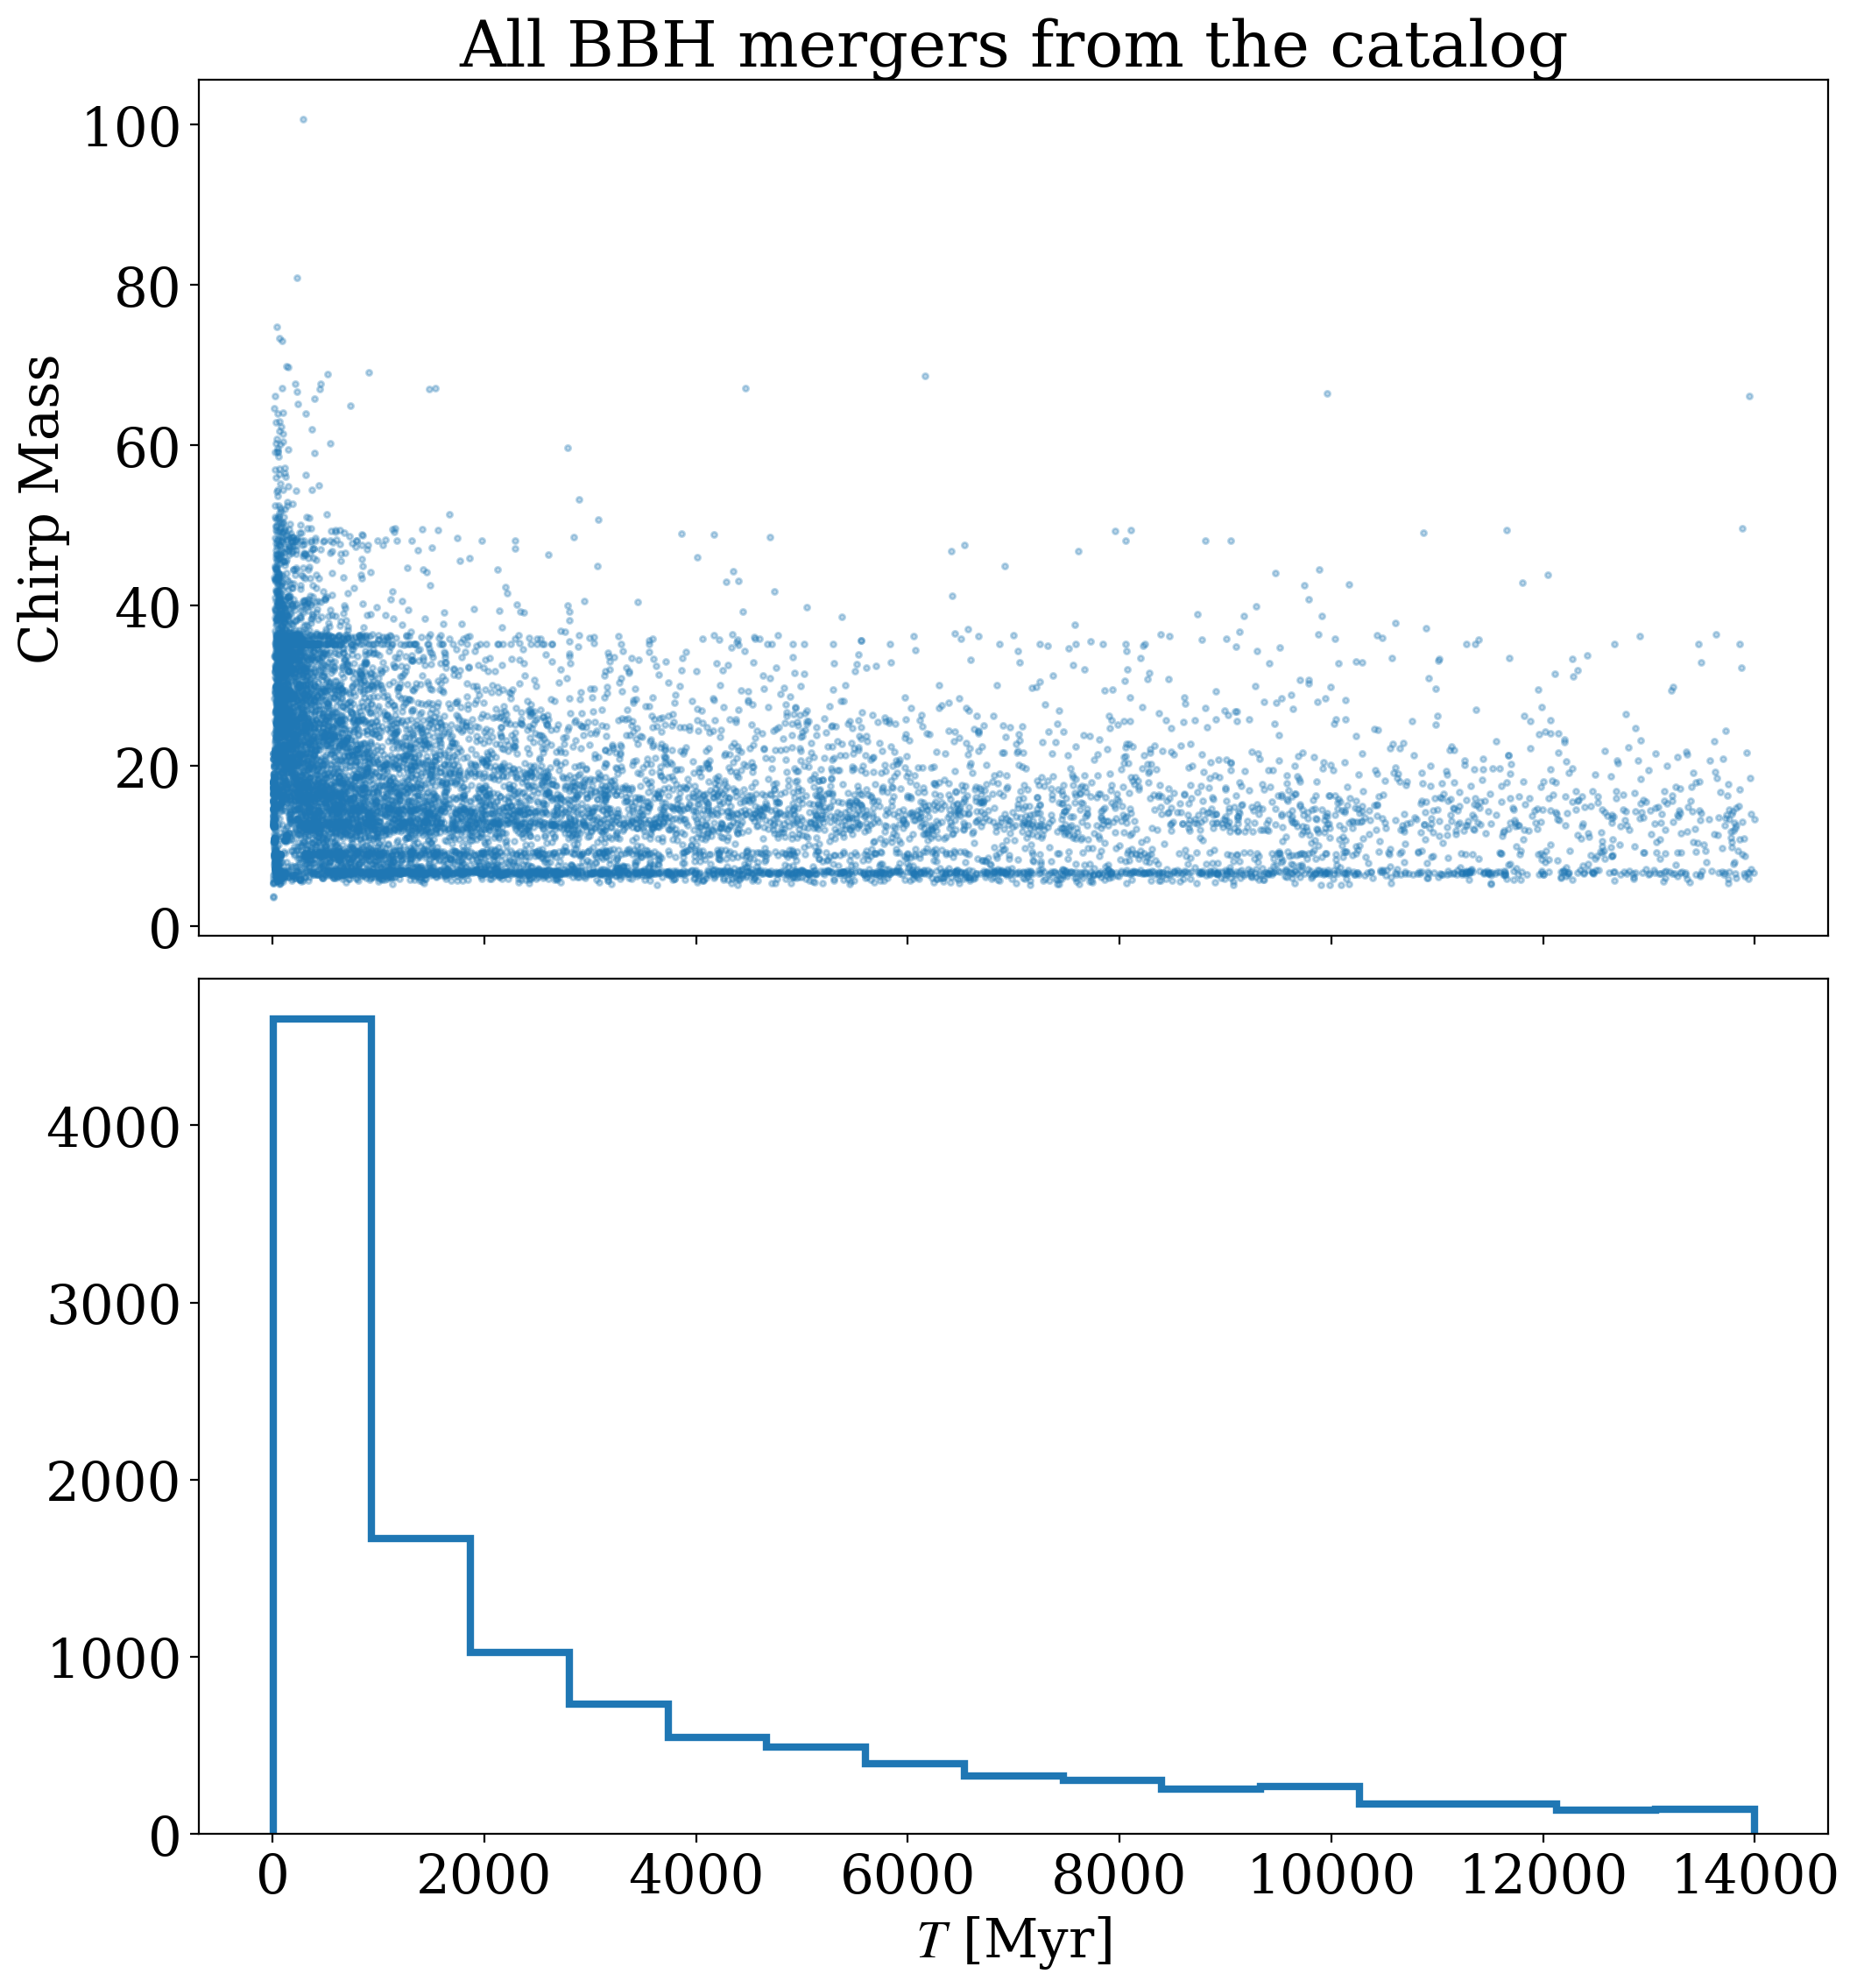

In [4]:
###import merger data; BBH
t_hub=14000.

m0 = []; m1 = []; bbh_type = []; t_mer = []

bbh_col = np.genfromtxt(savepath+'GWcap_BBH_maingrid.dat')
three_col = bbh_col[:,12]
bbh_mer = np.genfromtxt(savepath+'Incluster_BBH_maingrid.dat')
bbh_esc = np.genfromtxt(savepath+'Esc_BBH_maingrid.dat')
t_merger = bbh_esc[:,2]+bbh_esc[:,3]

m0 = m0+list(bbh_col[:,10][three_col==-100])
m1 = m1+list(bbh_col[:,11][three_col==-100])
bbh_type = bbh_type+list(np.full_like(bbh_col[:,10][three_col==-100], 1))
t_mer = t_mer + list(bbh_col[:,2][three_col==-100])
print(len(bbh_col[:,10][three_col==-100]))

m0 = m0+list(bbh_mer[:,7])
m1 = m1+list(bbh_mer[:,8])
bbh_type = bbh_type+list(np.full_like(bbh_mer[:,7], 2))
t_mer = t_mer + list(bbh_mer[:,2])
print(len(bbh_mer[:,7]))

m0=m0+list(bbh_esc[:,4][t_merger<=t_hub])
m1=m1+list(bbh_esc[:,5][t_merger<=t_hub])
bbh_type = bbh_type+list(np.full_like(bbh_esc[:,4][t_merger<=t_hub], 3))
t_mer = t_mer + list(t_merger[t_merger<=t_hub])

m_chirp = chirp_mass(np.array(m0), np.array(m1))
print(len(m_chirp), len(t_mer))

M0 = np.maximum(m0,m1)
M1 = np.minimum(m0,m1)
m0 = np.array(m0); m1 = np.array(m1)
mtot = m0+m1
t_mer = np.array(t_mer)

fig, axs = plt.subplots(nrows = 2, figsize=(12,13), sharex=True)
axs[0].scatter(t_mer, m_chirp, s=5, alpha=0.3)
axs[1].hist(t_mer, bins=15, histtype='step', lw=3)
#axs[0].set_yscale('log')
#axs[0].set_xscale('log')
axs[1].set_xlabel(r'$T$ [Myr]')
axs[0].set_ylabel('Chirp Mass')
axs[0].set_title('All BBH mergers from the catalog')
plt.subplots_adjust(hspace=0.05)

[22.932756839073644, 16.311510286859345, 15.16459077787041, 14.353395477319078, 14.868503088954128, 14.047145348668092, 13.39688460484085, 13.541899669664353, 14.123566268672924, 13.775544683942384, 13.859787535339718, 13.274779772553371, 13.652066845529488, 13.463905693876969] [21.488303780301614, 14.273714293705982, 13.484712146067883, 13.022880012027233, 13.485780113370257, 13.06784397608799, 12.273275865714762, 12.608094225018226, 12.830445983201622, 11.969766137482663, 12.572978614856853, 12.198045359706656, 12.656226212926825, 12.0388897167362]


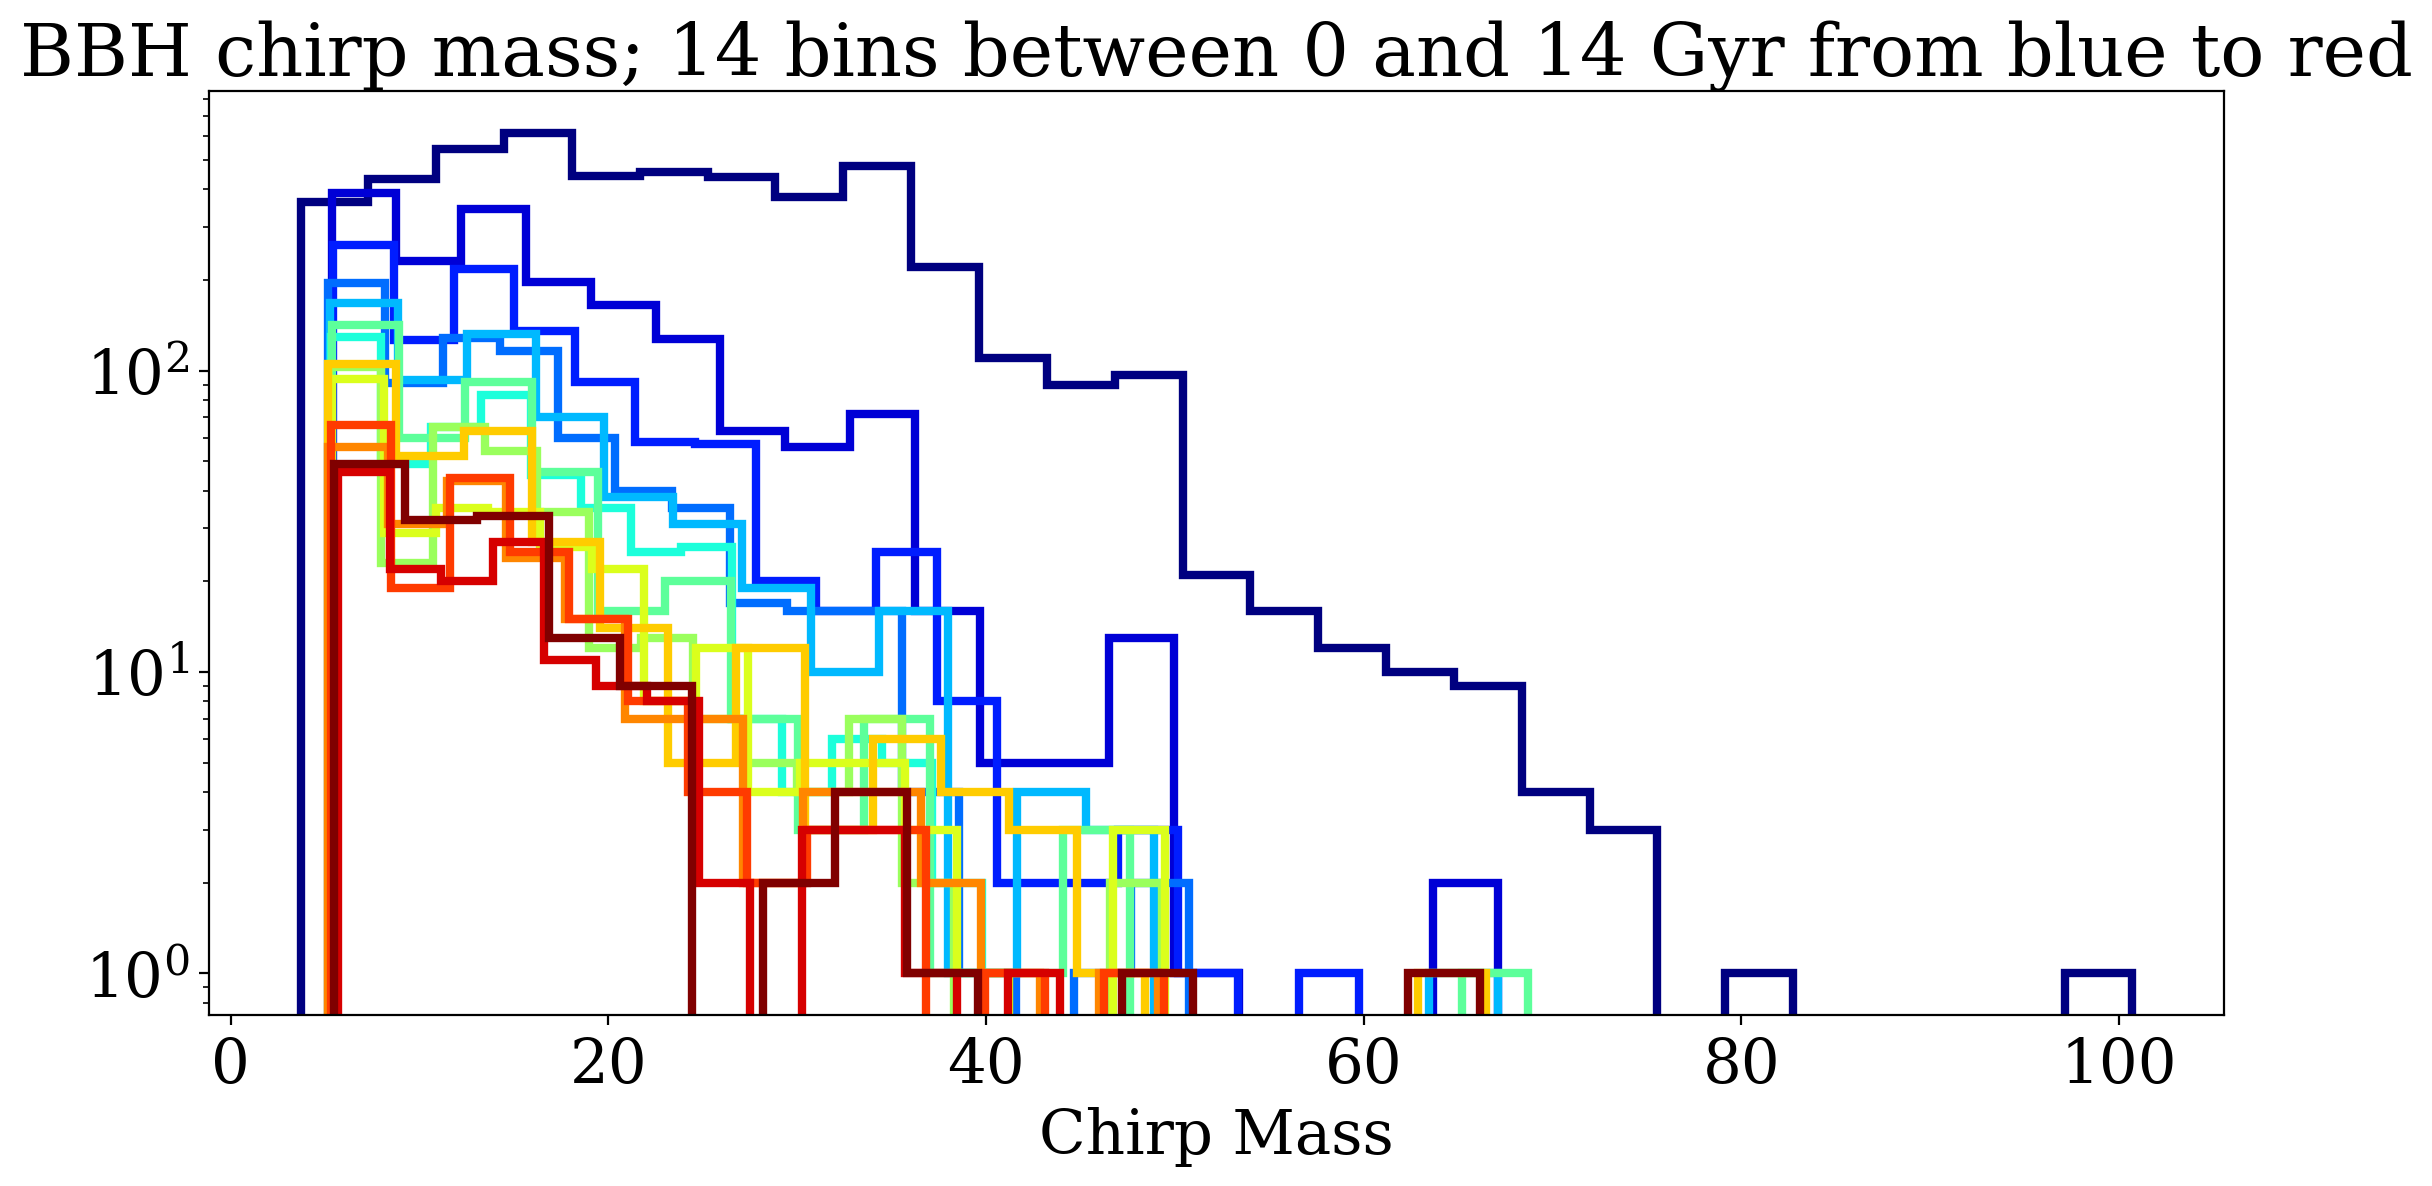

In [7]:
##BBH mass distribution as a function of time
M0 = np.maximum(m0,m1)
M1 = np.minimum(m0,m1)
m0 = np.array(m0); m1 = np.array(m1)
mtot = m0+m1
t_mer = np.array(t_mer)

mean_chirp = []; median_chirp = []

cs = cm.jet(np.linspace(0, 1, 14))
bin_size=[27, 18, 17, 15, 17, 13, 18, 16, 16, 17, 14, 14, 14, 16]
fig, axs = plt.subplots(figsize=(13,6))
t_step = 0.
while t_step < 14000.:
    step = int(t_step/1000)
    #hist, bin_edges = np.histogram(m_chirp[(t_mer < t_step+1000.) & (t_mer>=t_step)])
    mean_chirp.append(np.mean(m_chirp[(t_mer < t_step+1000.) & (t_mer>=t_step)]))
    median_chirp.append(np.median(m_chirp[(t_mer < t_step+1000.) & (t_mer>=t_step)]))
    m_step = m_chirp[(t_mer < t_step+1000.) & (t_mer>=t_step)]
    axs.hist(m_step, 
             bins = bin_size[step],#'auto',#np.logspace(np.log10(np.min(m_step)), np.log10(np.max(m_step)), 10), 
             color = cs[step],
             histtype='step', lw=3, label = str(t_step/1000.)+' Gyr')
    
    t_step+=1000.
    
axs.set_xlabel('Chirp Mass')
#axs.set_xscale('log')
axs.set_yscale('log')
#axs.legend(loc='best')
axs.set_title('BBH chirp mass; 14 bins between 0 and 14 Gyr from blue to red')

print(mean_chirp, median_chirp)

[21.194769763675247, 14.829340058352345, 14.498237790849549, 13.462638010945753, 13.945031798863148, 13.571806909844378, 13.560511922745548] [18.915340648869154, 13.26507325237712, 13.325677811852318, 12.446906572846473, 12.258426429341705, 12.373618888943453, 12.517705404613157]
11234 5770 3495 1969
11234
LinregressResult(slope=-1.0049669915748658, intercept=6.137317574022802, rvalue=-0.9897646480055082, pvalue=5.9274282147905255e-21, stderr=0.030213997451990746, intercept_stderr=0.11301379262423396)
5770
LinregressResult(slope=-0.8018459583338307, intercept=5.2002503298355, rvalue=-0.9570585928625814, pvalue=7.334304406216062e-14, stderr=0.050644064073867824, intercept_stderr=0.1894313310903985)
3495
LinregressResult(slope=-1.1941901001083366, intercept=6.222514681449646, rvalue=-0.987443856675065, pvalue=6.146658565488676e-20, stderr=0.03983572293165535, intercept_stderr=0.1489681185583147)
1969
LinregressResult(slope=-1.3835848520756657, intercept=6.398202195831252, rvalue=-0.97204

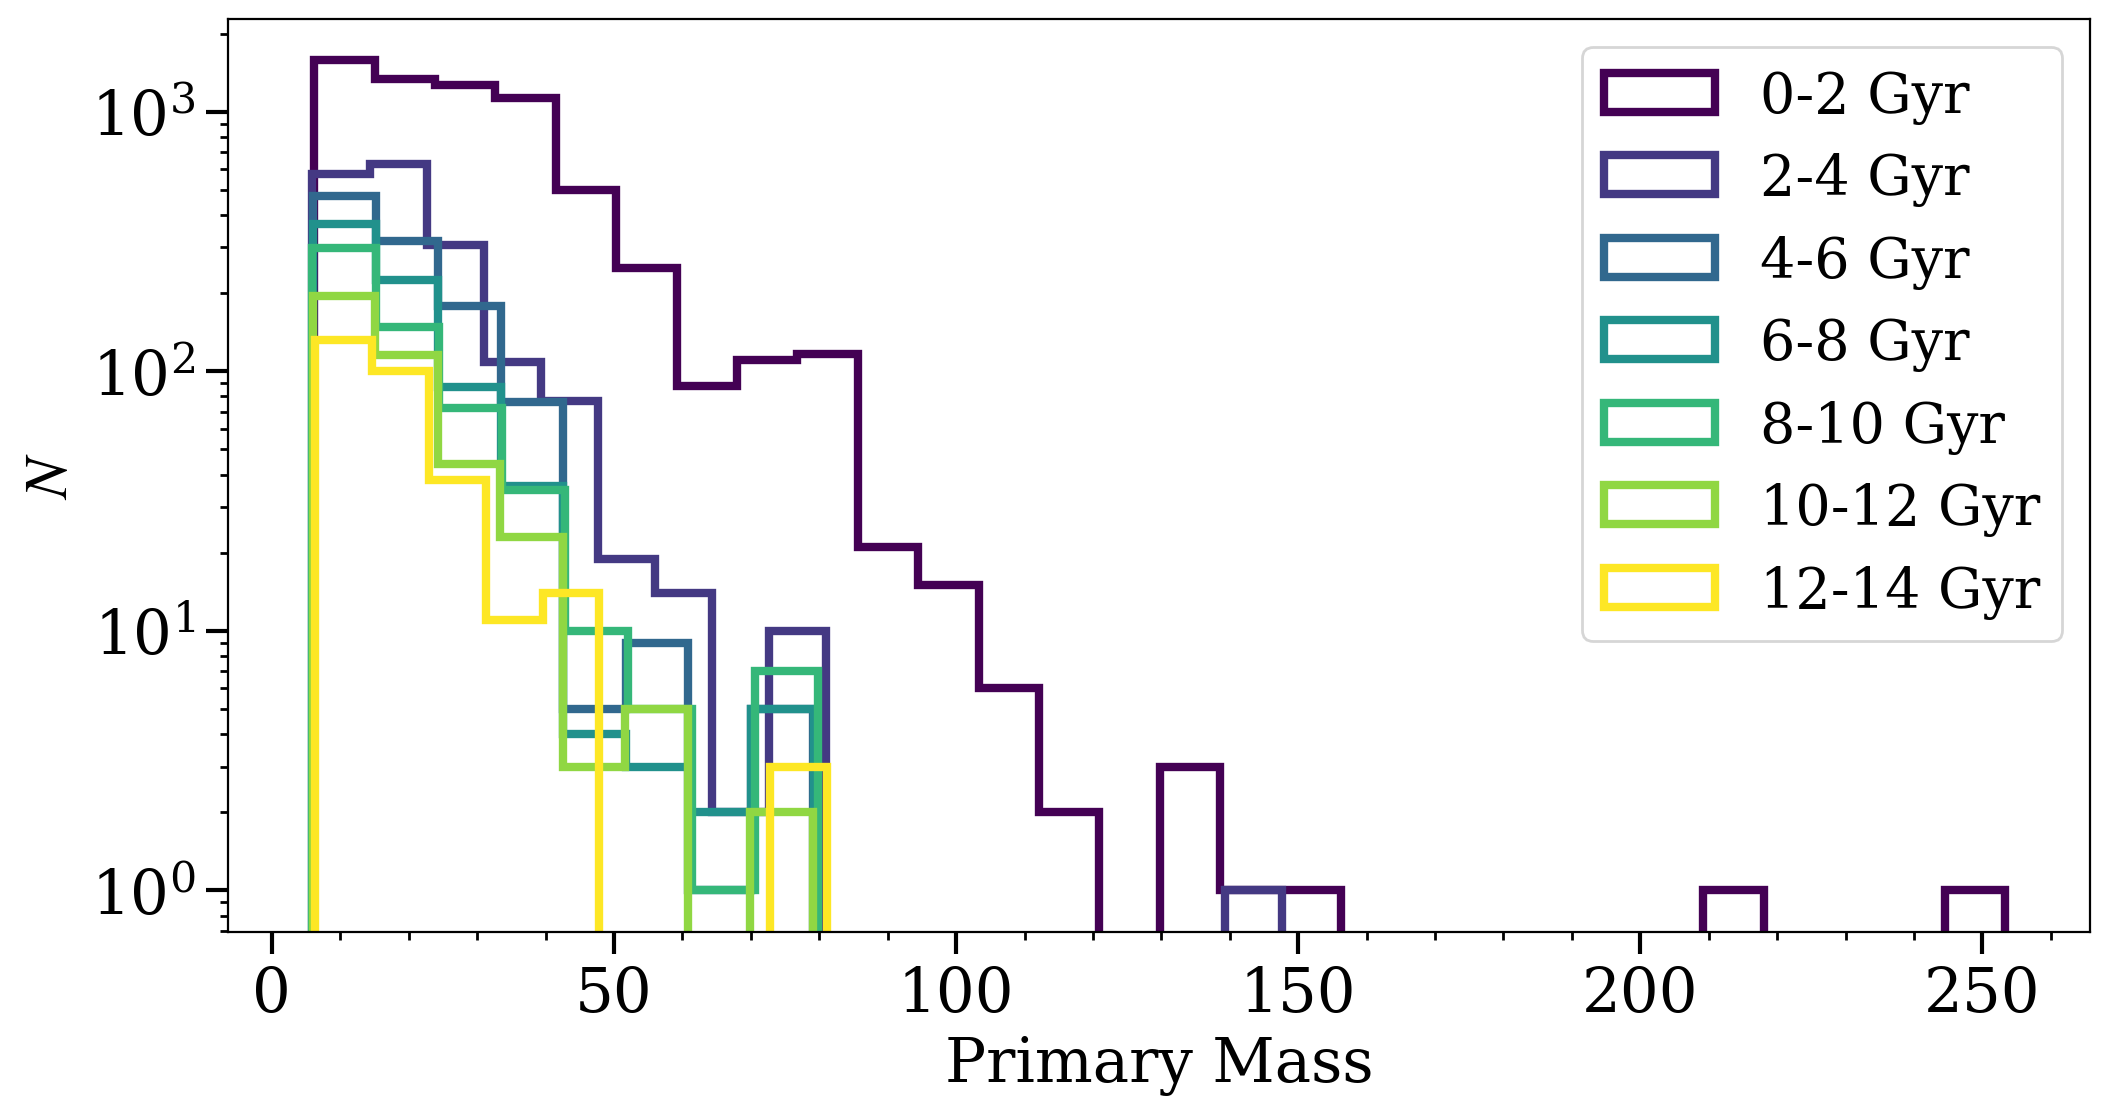

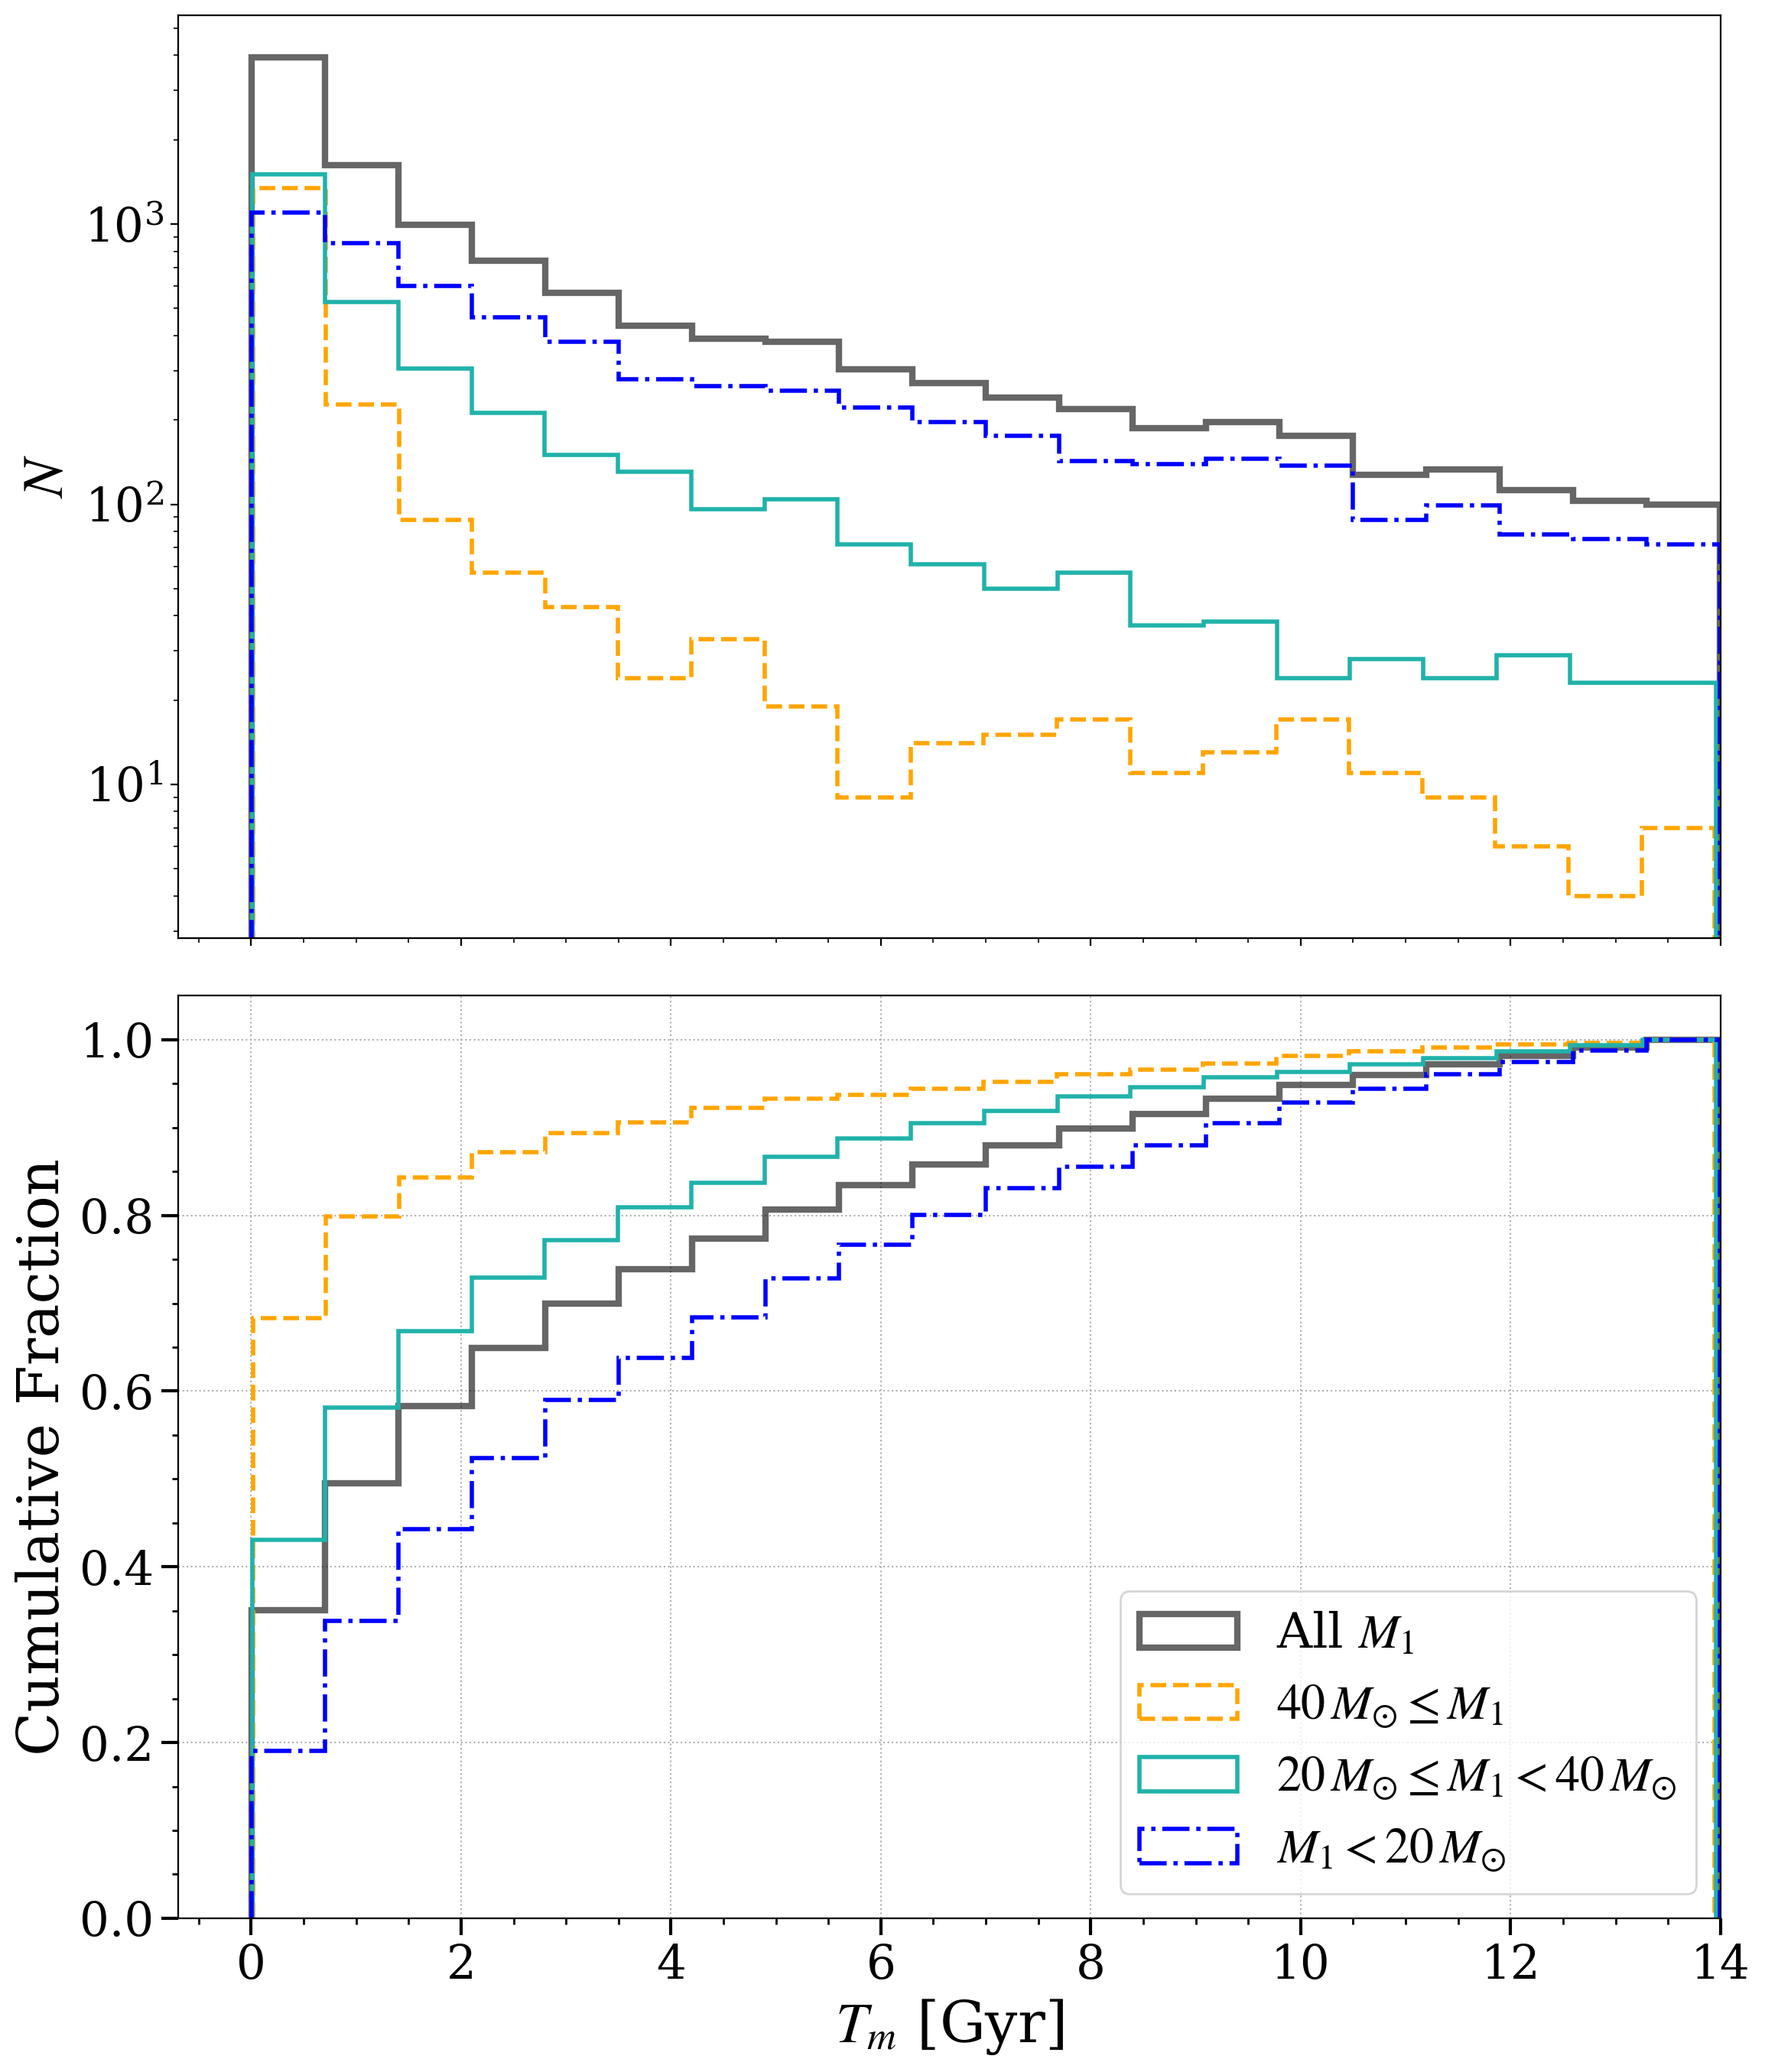

In [8]:
##BBH mass distribution as a function of time

mean_chirp = []; median_chirp = []

cs = cm.viridis(np.linspace(0, 1, 7))
#bin_size=[27, 15, 17, 16, 17, 12, 18]  ##for chirp mass in linear plotting
bin_size=[28, 17, 8, 8, 8, 8, 9] ##for primary mass
fig, axs = plt.subplots(figsize=(11,6))
t_step = 0.
t_int = 2000.
while t_step < 14000.:
    step = int(t_step/t_int)
    #hist, bin_edges = np.histogram(m_chirp[(t_mer < t_step+1000.) & (t_mer>=t_step)])
    mean_chirp.append(np.mean(m_chirp[(t_mer < t_step+t_int) & (t_mer>=t_step)]))
    median_chirp.append(np.median(m_chirp[(t_mer < t_step+t_int) & (t_mer>=t_step)]))
    #m_step = m_chirp[(t_mer < t_step+t_int) & (t_mer>=t_step)]
    m_step = M0[(t_mer < t_step+t_int) & (t_mer>=t_step)]
    axs.hist(m_step, 
             bins = bin_size[step], #np.logspace(np.log10(np.min(m_step)), np.log10(np.max(m_step)), bin_size[step]), 
             color = cs[step],
             histtype='step', lw=3, 
             label = str(int(t_step/1000.))+'-'+str(int((t_step+t_int)/1000.))+' Gyr')
    
    t_step+=t_int
    
axs.set_xlabel('Primary Mass')
axs.set_ylabel(r'$N$')
#axs.set_xscale('log')
axs.set_yscale('log')
#axs.set_xlim(xmax=150)
axs.legend(loc='best', fontsize=20)
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params('both', length=8, width=1.5, which='major')
axs.tick_params('both', length=3, width=1, which='minor')
fig.tight_layout()
#plt.savefig(savepath+'chirp_time.pdf', dpi=300)

print(mean_chirp, median_chirp)


fig, axs = plt.subplots(nrows=2, figsize=(12,14), sharex=True)
axs[0].hist(t_mer/1000., bins=20,
         histtype='step', label = r'All $ M_1 $',linewidth = 3, color='k', alpha=0.6)
axs[0].hist(t_mer[M0>=40]/1000., bins=20,
         histtype='step', label = r'$40\,M_{\odot} \leq M_1$',linewidth = 2, ls = '--', color='orange')
axs[0].hist(t_mer[(M0>=20) & (M0<40)]/1000., bins=20,
         histtype='step', label = r'$20 \,M_{\odot} \leq M_1 < 40\,M_{\odot} $',linewidth = 2, color = 'lightseagreen')
axs[0].hist(t_mer[M0<20]/1000., bins=20,
         histtype='step', label = r'$ M_1 < 20\,M_{\odot} $',linewidth = 2, color='b', ls='-.')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$N$', fontsize=27)
#axs[0].legend(loc='upper right', fontsize=18)

axs[1].hist(t_mer/1000., bins=20,
         cumulative=True, density=True,# stacked=True,
         histtype='step', label = r'All $ M_1 $',linewidth = 3, color='k', alpha=0.6)
axs[1].hist(t_mer[M0>=40]/1000., bins=20,
         cumulative=True, density=True,# stacked=True,
         histtype='step', label = r'$40\,M_{\odot} \leq M_1$',linewidth = 2,color='orange', ls='--')
axs[1].hist(t_mer[(M0>=20) & (M0<40)]/1000., bins=20,
         cumulative=True, density=True,#stacked=True,
         histtype='step', label = r'$20 \,M_{\odot} \leq M_1 < 40\,M_{\odot} $',linewidth = 2, color = 'lightseagreen')
axs[1].hist(t_mer[M0<20]/1000., bins=20,
         cumulative=True, density=True,# stacked=True, 
         histtype='step', label = r'$ M_1 < 20\,M_{\odot} $',linewidth = 2, color='b', ls='-.')
#axs.set_yscale('log')
axs[1].set_xlim(xmax=14.)
#axs[1].set_ylim(ymin=0.1)
axs[1].set_ylabel('Cumulative Fraction', fontsize=27)
axs[1].set_xlabel(r'$T_m$ [Gyr]', fontsize=27)
axs[1].legend(loc='lower right', fontsize=23)

axs[1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].yaxis.set_minor_locator(AutoMinorLocator())
axs[1].tick_params('both', length=8, width=1.5, which='major')
axs[1].tick_params('both', length=3, width=1, which='minor')
plt.grid(linestyle=':',which='major',linewidth='0.75')

fig.tight_layout()

plt.savefig(savepath+'merger_time.pdf')

##Fitting power-law p(t) ~t^-alpha to delayed time distribution
from scipy.stats import linregress
sel_mass = [M0>=0, M0<20, (M0>=20) & (M0<40), M0>=40]
print(len(t_mer), len(t_mer[M0<20]), len(t_mer[(M0>=20) & (M0<40)]), len(t_mer[M0>=40]))
for xx in range(len(sel_mass)):
    print(len(t_mer[sel_mass[xx]]))
    ytemp, xtemp = np.histogram(t_mer[sel_mass[xx]], bins=25)
    xtemp = np.array(xtemp)
    xt = (xtemp[1:]+xtemp[:-1])/2.
    yt = np.array(ytemp)
    print(linregress(np.log10(xt), np.log10(yt)))

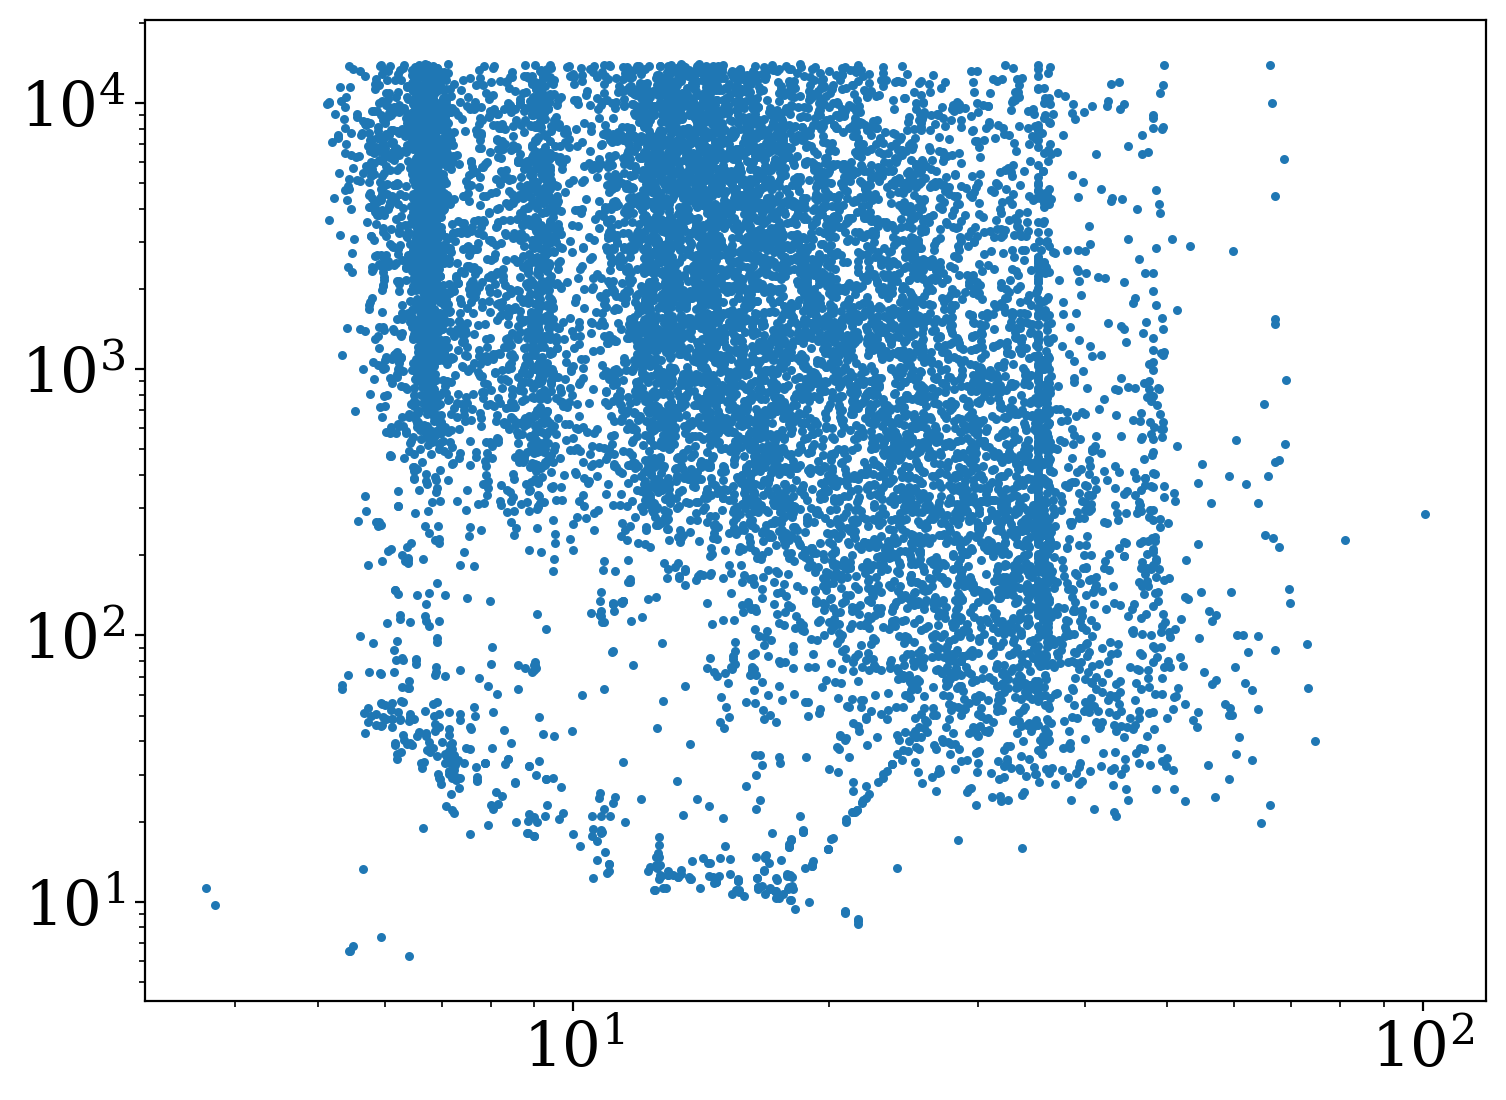

In [8]:
##BBH mass distribution as a function of time
##Scatter plot
M0 = np.maximum(m0,m1)
M1 = np.minimum(m0,m1)
m0 = np.array(m0); m1 = np.array(m1)
mtot = m0+m1
t_mer = np.array(t_mer)


fig, axs = plt.subplots(figsize=(8,6))
axs.scatter(m_chirp[t_mer<=14000.], t_mer[t_mer<=14000.], s=5)

#axs.set_xlabel('Chirp Mass')
#axs.set_ylabel(r'$N$')
axs.set_xscale('log')
axs.set_yscale('log')
#axs.legend(loc='best', fontsize=20)
fig.tight_layout()


[32.4567   29.4702   30.1248   ... 13.066553 11.506553 21.892913] [18.2013   75.0093   32.9007   ...  8.16715  12.010541  9.07032 ] 1103


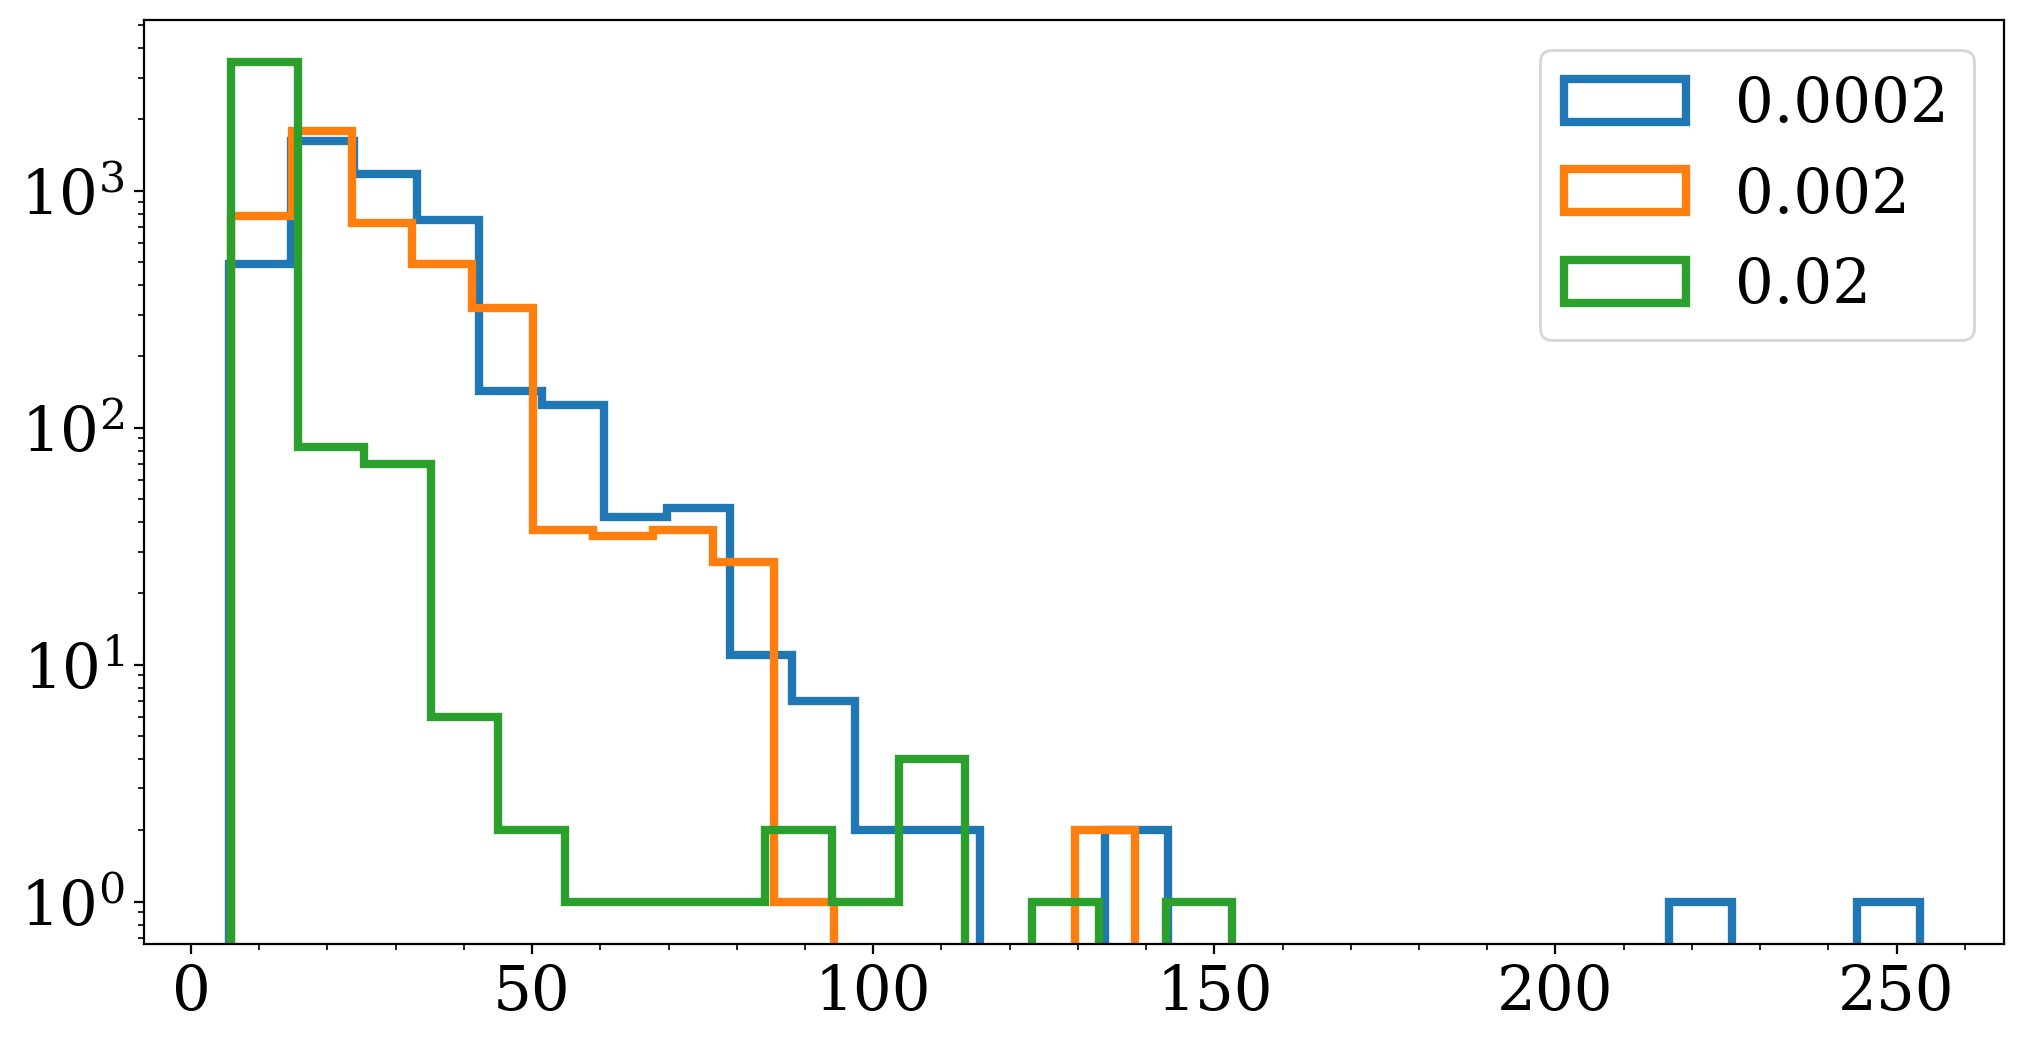

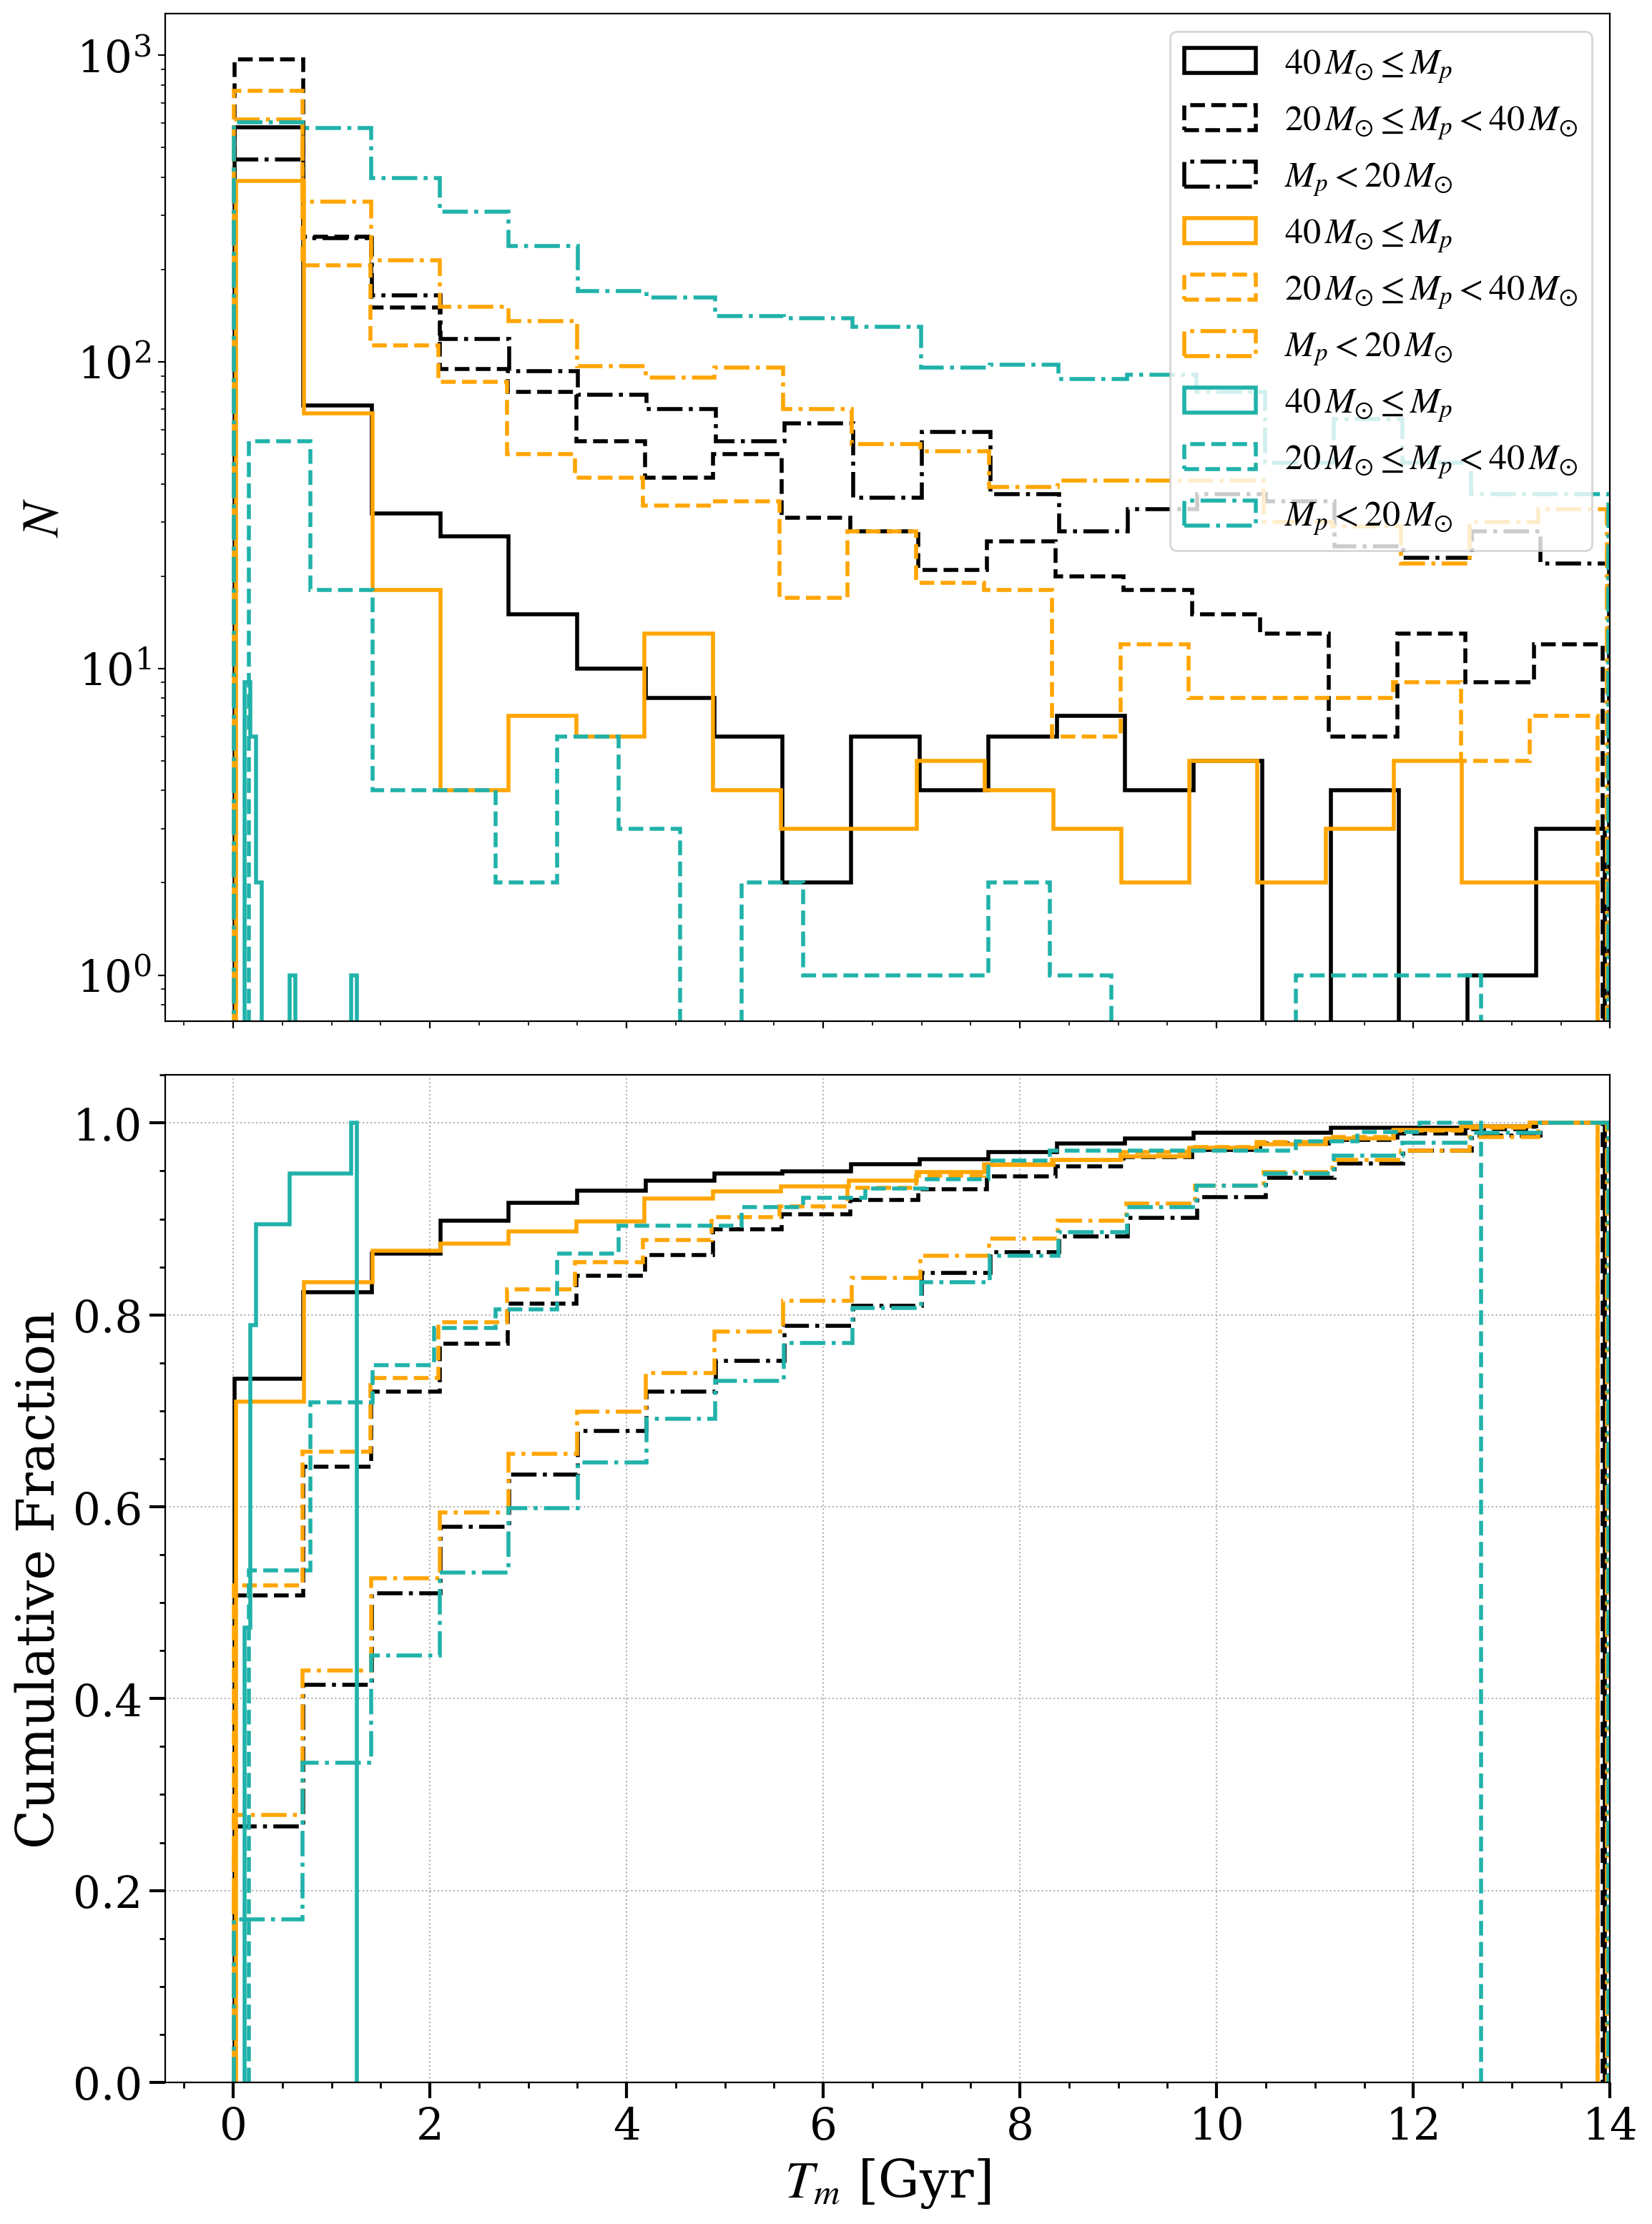

In [13]:
###Effects of metallicity?
bbh_data = gcr.read_data('/fs/lustre/cita/claireshiye/projects/BBH_catalog/')
M0 = bbh_data[5]; M1 = bbh_data[6]
zmodel = bbh_data[2]
tgw = bbh_data[4]

zrange = [0.0002, 0.002, 0.02]
bins = [27, 15, 15]
fig, axs = plt.subplots(figsize=(12,6))
for yy in range(len(zrange)):
    m_sel = M0[zmodel==zrange[yy]]
    axs.hist(m_sel, bins=bins[yy],
             histtype='step', lw=3, label = str(zrange[yy]))
    
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.set_yscale('log')
axs.legend(loc='best')


cs = ['k', 'orange', 'lightseagreen']
fig, axs = plt.subplots(nrows = 2, figsize=(12,16), sharex=True)
for xx in range(len(zrange)):
    #axs.hist(tgw[zmodel==zrange[xx]], bins=20,
    #         cumulative=True, density=True,# stacked=True,
    #         histtype='step', label = r'All $ M_p $',linewidth = 3, color='k', alpha=0.6, ls = lss[xx])
    axs[0].hist(tgw[(zmodel==zrange[xx]) & (M0>=40)], bins=20,
             histtype='step', label = r'$40\,M_{\odot} \leq M_p$',linewidth = 2, color=cs[xx], ls='-')
    axs[0].hist(tgw[(zmodel==zrange[xx]) & (M0>=20) & (M0<40)], bins=20,
             histtype='step', label = r'$20 \,M_{\odot} \leq M_p < 40\,M_{\odot} $',linewidth = 2,
             color = cs[xx], ls='--')
    axs[0].hist(tgw[(zmodel==zrange[xx]) & (M0<20)], bins=20,
             histtype='step', label = r'$ M_p < 20\,M_{\odot} $',linewidth = 2, color=cs[xx], ls='-.')
    
    
    #axs.hist(tgw[zmodel==zrange[xx]], bins=20,
    #         cumulative=True, density=True,# stacked=True,
    #         histtype='step', label = r'All $ M_p $',linewidth = 3, color='k', alpha=0.6, ls = lss[xx])
    axs[1].hist(tgw[(zmodel==zrange[xx]) & (M0>=40)], bins=20,
             cumulative=True, density=True,# stacked=True,
             histtype='step', label = r'$40\,M_{\odot} \leq M_p$',linewidth = 2, color=cs[xx], ls='-')
    axs[1].hist(tgw[(zmodel==zrange[xx]) & (M0>=20) & (M0<40)], bins=20,
             cumulative=True, density=True,#stacked=True,
             histtype='step', label = r'$20 \,M_{\odot} \leq M_p < 40\,M_{\odot} $',linewidth = 2,
             color = cs[xx], ls='--')
    axs[1].hist(tgw[(zmodel==zrange[xx]) & (M0<20)], bins=20,
             cumulative=True, density=True,# stacked=True, 
             histtype='step', label = r'$ M_p < 20\,M_{\odot} $',linewidth = 2, color=cs[xx], ls='-.')


axs[0].set_yscale('log')
axs[0].set_ylabel(r'$N$', fontsize=26)
axs[0].legend(loc='upper right', fontsize=18)

#axs.set_yscale('log')
axs[1].set_xlim(xmax=14.)
#axs[1].set_ylim(ymin=0.1)
axs[1].set_ylabel('Cumulative Fraction', fontsize=26)
axs[1].set_xlabel(r'$T_m$ [Gyr]', fontsize=26)

axs[1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].yaxis.set_minor_locator(AutoMinorLocator())
axs[1].tick_params('both', length=8, width=1.5, which='major')
axs[1].tick_params('both', length=3, width=1, which='minor')
plt.grid(linestyle=':',which='major',linewidth='0.75')


fig.tight_layout()


In [4]:
##testing
from importlib import reload
reload(gcr)

bbh_data = gcr.read_data('/fs/lustre/cita/claireshiye/projects/BBH_catalog/')
ml=0; mh=500
dz = 0.2; z_gc = 2.2; a = 2.6; b = 3.6; dNdV0 = 2.31e9
logf_disrupted_cluster = 1; sigma_dex = 0.5; Zsun = 0.02
mu_rv = 2; sigma_rv = 2; beta = -2; logMstar0 = 6.26; logMlo = 4; logMhi = 8

gcr.merger_rate_at_z_pop(
        bbh_data, 2, ml, mh, z_gc, a, b, dNdV0, logf_disrupted_cluster, sigma_dex, Zsun, mu_rv, sigma_rv, beta, 
        logMstar0, logMlo, logMhi)

[32.4567   29.4702   30.1248   ... 13.066553 11.506553 21.892913] [18.2013   75.0093   32.9007   ...  8.16715  12.010541  9.07032 ] 1103


98.07755381438994

In [6]:
###read data and define plots
bbh_data = gcr.read_data('/fs/lustre/cita/claireshiye/projects/BBH_catalog/')

###Calculating logf_disrupted_cluster by normalizing the merger rate to 10 Gpc^-3 yr^-1
dz = 0.2; z_gc = 2.2; a = 2.6; b = 3.6; dNdV0 = 2.31e9
sigma_dex = 0.5; Zsun = 0.02
mu_rv = 2; sigma_rv = 2; beta = -2; logMstar0 = 6.26; logMlo = 5; logMhi = 6
ml=0.; mh=1000.
print('z=0 merger rate', 1./3.*gcr.merger_rate_at_z_pop(
        bbh_data, 0, ml, mh, z_gc, a, b, dNdV0, 0, sigma_dex, Zsun, mu_rv, sigma_rv, beta, 
        logMstar0, logMlo, logMhi))
logf_disrupted_cluster_norm = np.log10(10./(gcr.merger_rate_at_z_pop(
        bbh_data, 0, ml, mh, z_gc, a, b, dNdV0, 0, sigma_dex, Zsun, mu_rv, sigma_rv, beta, 
        logMstar0, logMlo, logMhi)*(1./3.)))
print('disruption factor', logf_disrupted_cluster_norm)

##Plotting function
def plot_cluster_rate(zmin, zmax, ml, mh, dz = 0.2, z_gc = 2.2, a = 2.6, b = 3.6, dNdV0 = 2.31e9, 
                      logf_disrupted_cluster = logf_disrupted_cluster_norm, sigma_dex = 0.5, Zsun = 0.02,
                     mu_rv = 2, sigma_rv = 2, beta = -2, logMstar0 = 6.26, logMlo = 5, logMhi = 6, plot_kwargs = {}):
    z_c = np.arange(zmin, zmax + dz, step = dz)
    R_z_c = [1./3.*gcr.merger_rate_at_z_pop(
        bbh_data, z, ml, mh, z_gc, a, b, dNdV0, logf_disrupted_cluster, sigma_dex, Zsun, mu_rv, sigma_rv, beta, 
        logMstar0, logMlo, logMhi) for z in z_c]
    ##the 1/3 takes into account the fact that there are three galactriccentric distances
    plt.plot(z_c, R_z_c, **plot_kwargs)
    plt.xlabel(r'redshift $z$', fontsize=26)
    plt.xlim(zmin, zmax)
    plt.ylabel(r'$\mathcal{R}(z)\,[\rm{Gpc^{-3}\,yr^{-1}}]$', fontsize=26)
    plt.yscale('log')

[32.4567   29.4702   30.1248   ... 13.066553 11.506553 21.892913] [18.2013   75.0093   32.9007   ...  8.16715  12.010541  9.07032 ] 1103
z=0 merger rate 2.1025237539039745
disruption factor 0.6772590889278411


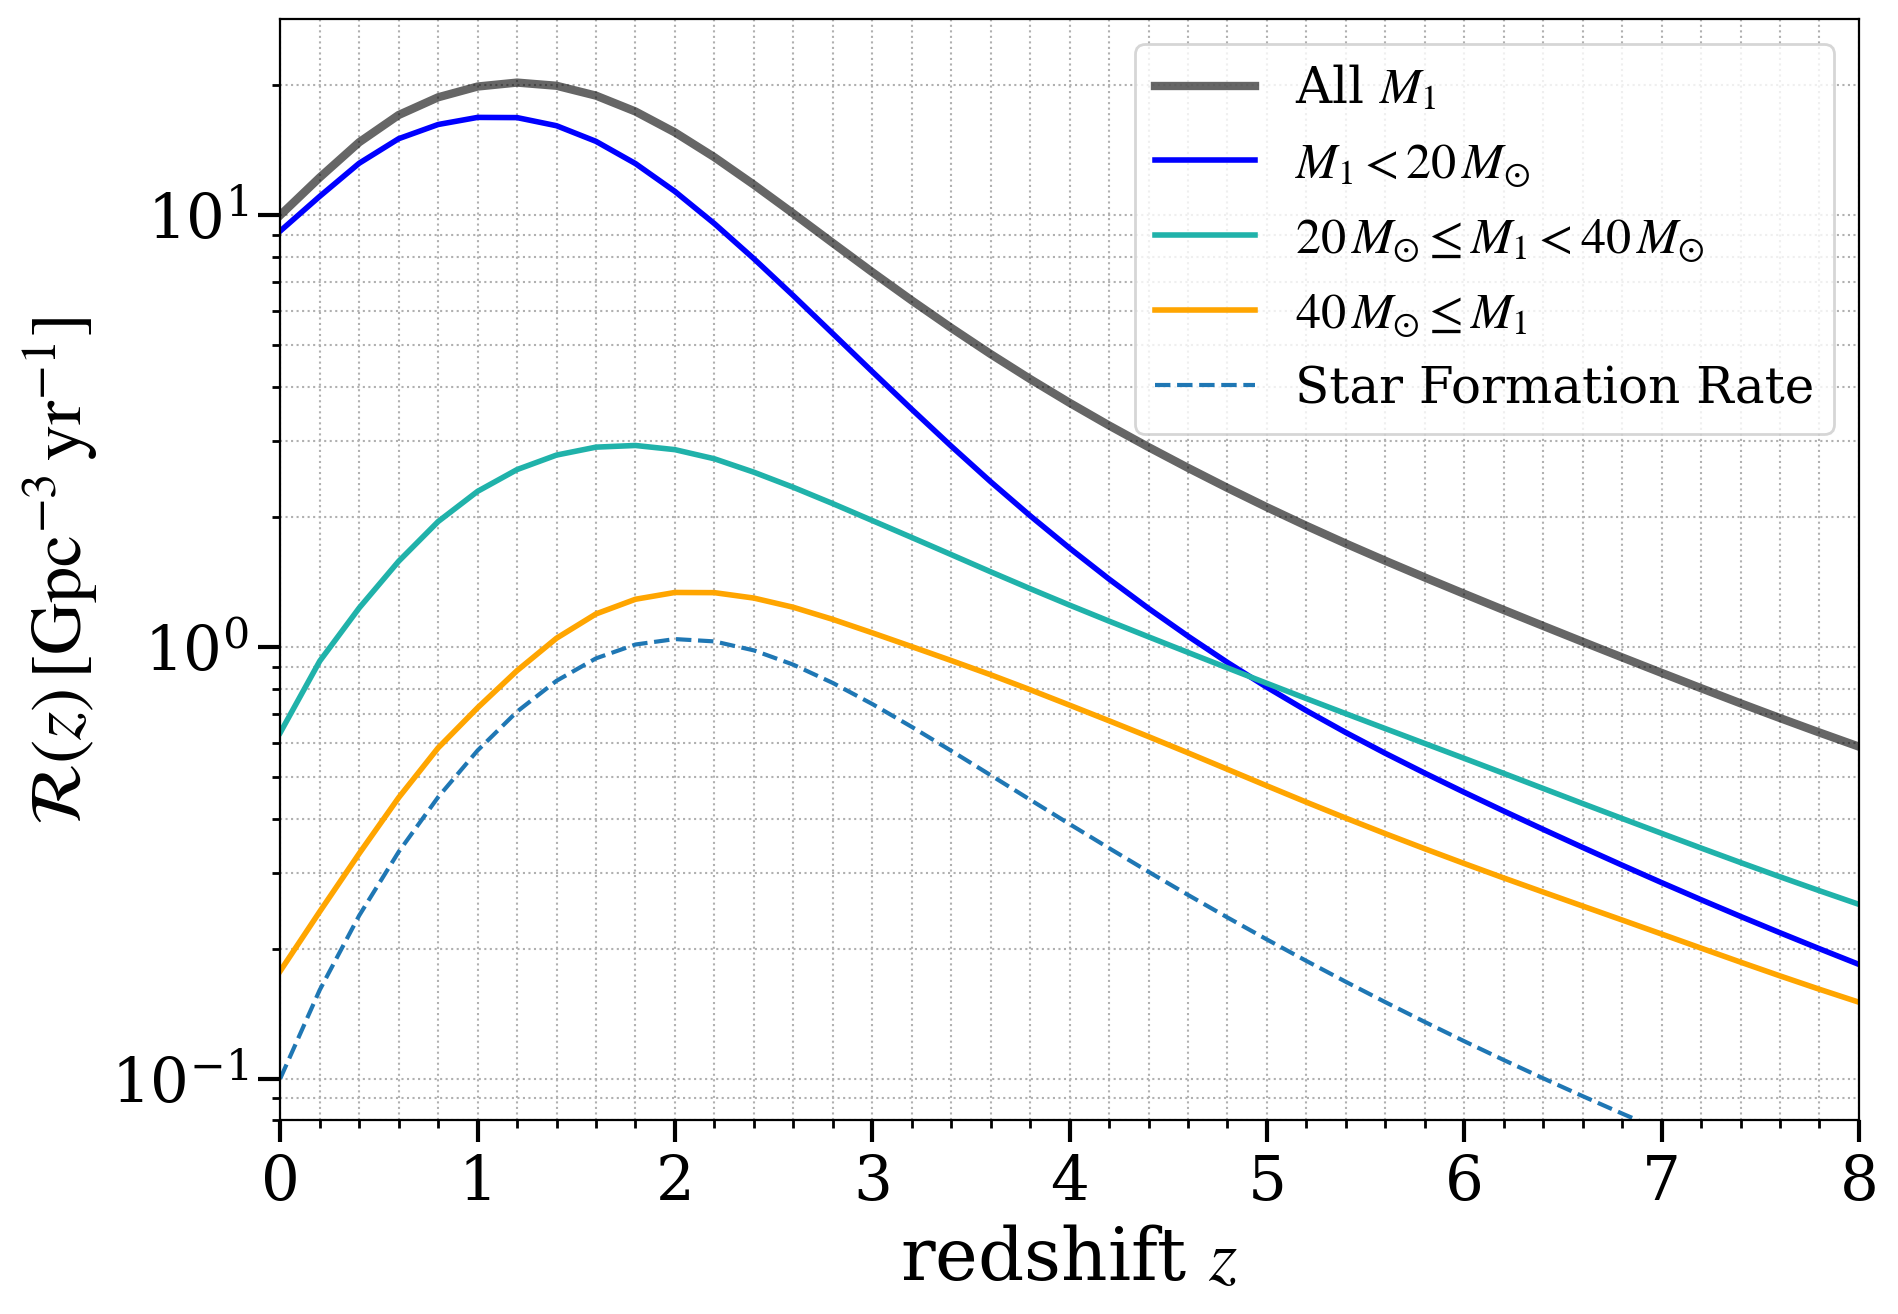

In [8]:
zgrid = np.arange(0, 10. + dz, step = dz)
gcr_grid = 0.1*gcr.redshift_peak(zgrid, a = 2.6, b = 3.6, zp = 2.2)

fig, ax = plt.subplots(figsize=(10,7))
plot_cluster_rate(0, 20, 0, 1000, 
                  plot_kwargs = dict(label = r'All $ M_1 $',linewidth = 3, color='k', alpha=0.6))
plot_cluster_rate(0, 20, 0, 20, 
                  plot_kwargs = dict(label = r'$ M_1 < 20\,M_{\odot} $',linewidth = 2, color='b'))
plot_cluster_rate(0, 20, 20, 40, 
                  plot_kwargs = dict(label = r'$20 \,M_{\odot} \leq M_1 < 40\,M_{\odot} $',linewidth = 2, 
                                     color = 'lightseagreen'))
plot_cluster_rate(0, 20, 40, 1000, 
                  plot_kwargs = dict(label = r'$40\,M_{\odot} \leq M_1$',linewidth = 2,
                                    color='orange'))
ax.plot(zgrid, gcr_grid, ls='--', label='Star Formation Rate')

ax.set_xlim(xmax=8)
ax.set_ylim(ymin=0.08)
plt.legend(loc='upper right', fontsize=18, frameon=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params('both', length=8, width=1.5, which='major')
ax.tick_params('both', length=3, width=1, which='minor')
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
#plt.gca().xaxis.set_ticks_position('both')
#plt.gca().yaxis.set_ticks_position('both')
#plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')

fig.tight_layout()
plt.savefig(savepath+'R_z.pdf', dpi=300)

#plot_cluster_rate(0, 20, 30, 40, plot_kwargs = dict(label = r'$30 M_{\odot} \leq M_{BH, p} < 40 M_{\odot} $',linewidth = 2))
#plot_cluster_rate(0, 20, 40, 50, plot_kwargs = dict(label = r'$40 M_{\odot} \leq M_{BH, p} < 50 M_{\odot} $',linewidth = 2))
#plot_cluster_rate(0, 20, 50, 1000, plot_kwargs = dict(label = r'$50 M_{\odot} \leq M_{BH, p}$',linewidth = 2))

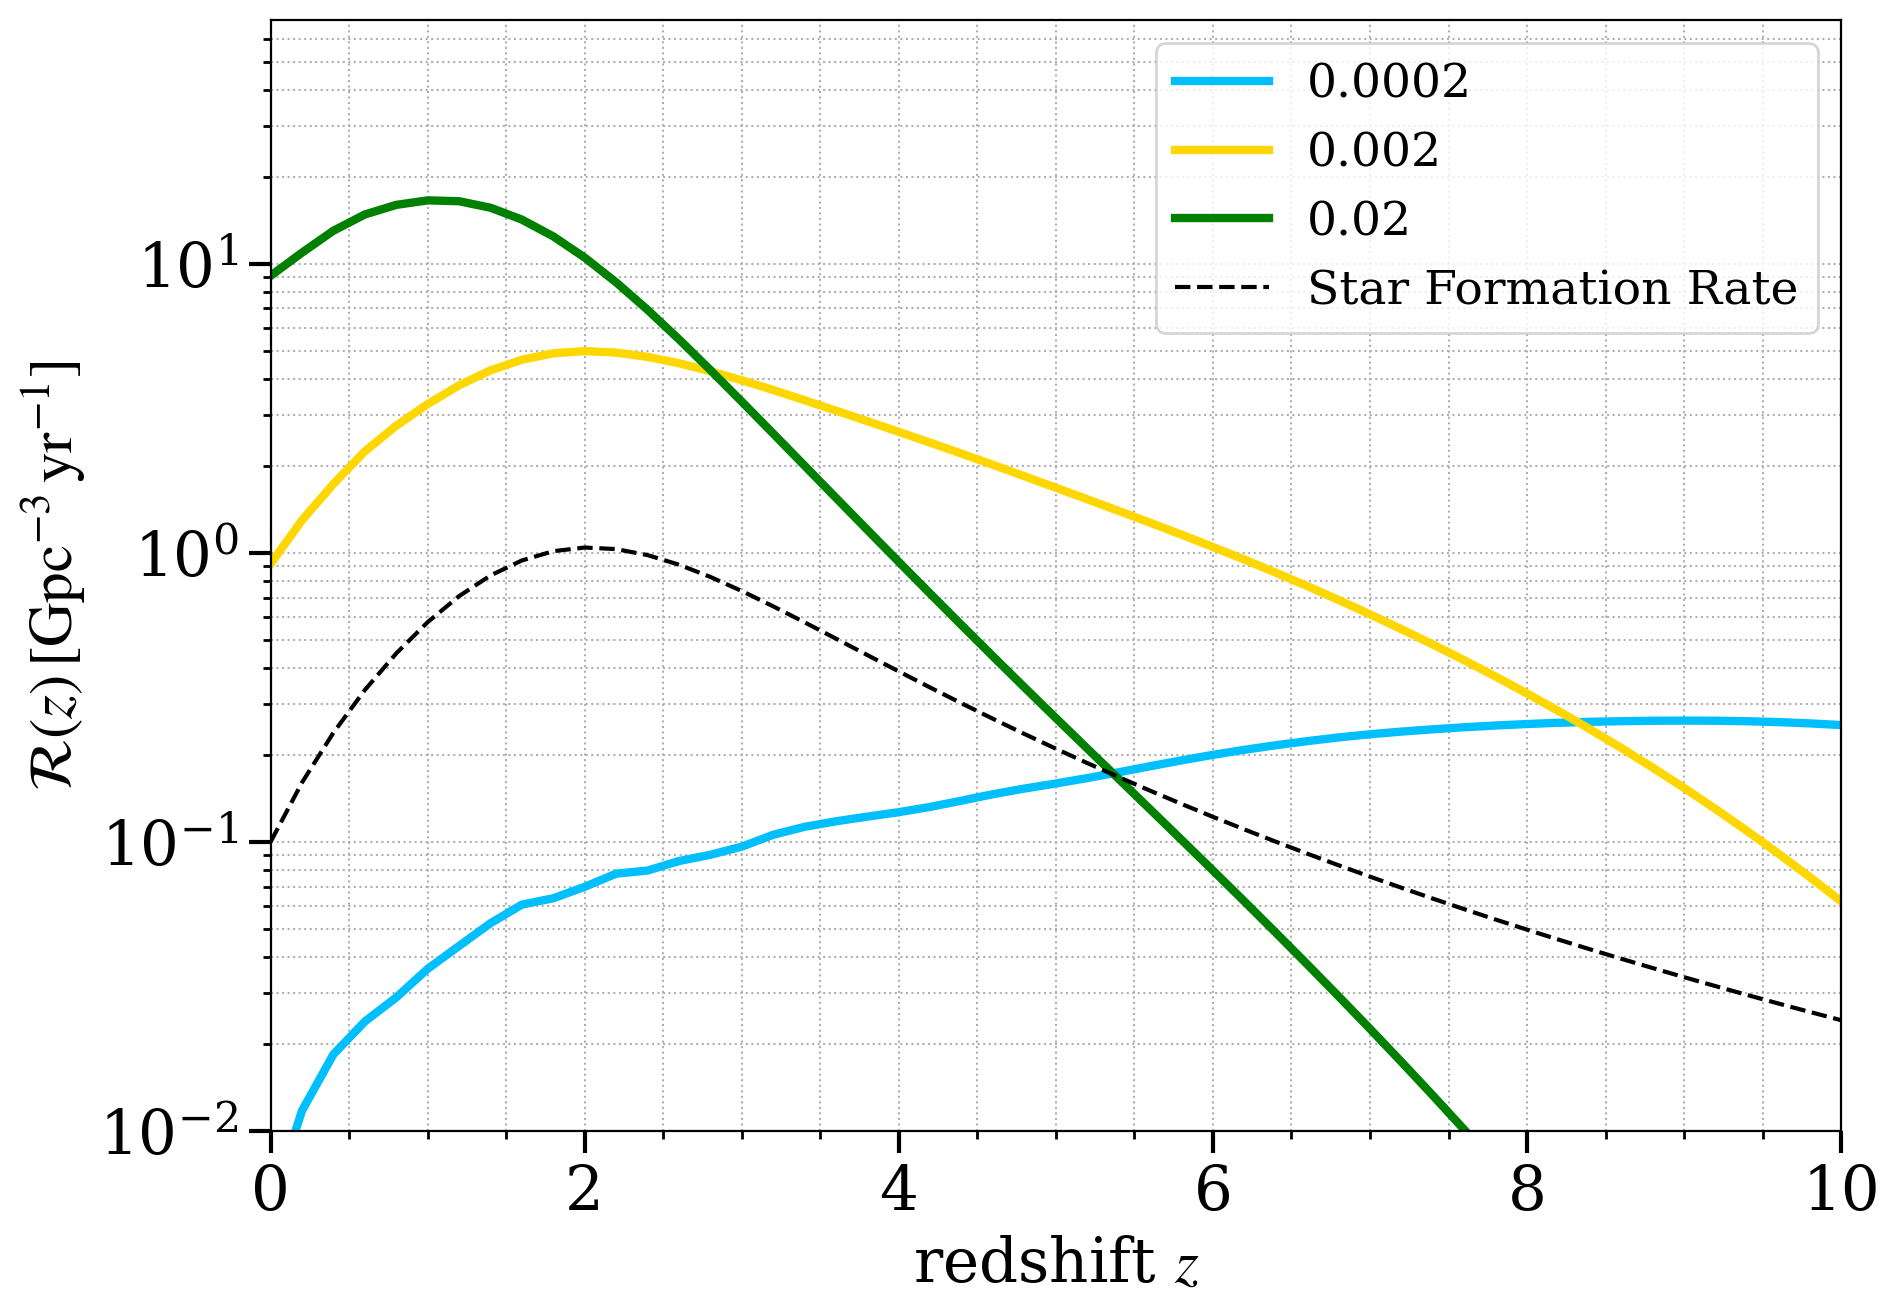

In [16]:
###Effects of metallicity?
from importlib import reload
reload(gcr)

##Plotting function
def plot_cluster_rate_metal(zmin, zmax, zmet, dz = 0.2, z_gc = 2.2, a = 2.6, b = 3.6, dNdV0 = 2.31e9, 
                      logf_disrupted_cluster = logf_disrupted_cluster_norm, sigma_dex = 0.5, Zsun = 0.02,
                     mu_rv = 2, sigma_rv = 2, beta = -2, logMstar0 = 6.26, logMlo = 4, logMhi = 8, plot_kwargs = {}):
    z_c = np.arange(zmin, zmax + dz, step = dz)
    R_z_c = [1./3.*gcr.merger_rate_at_z_pop_metal(
        bbh_data, z, zmet, z_gc, a, b, dNdV0, logf_disrupted_cluster, sigma_dex, Zsun, mu_rv, sigma_rv, beta, 
        logMstar0, logMlo, logMhi) for z in z_c]
    ##the 1/3 takes into account the fact that there are three galactriccentric distances
    plt.plot(z_c, R_z_c, **plot_kwargs)
    plt.xlabel(r'redshift $z$')
    plt.xlim(zmin, zmax)
    plt.ylabel(r'$\mathcal{R}(z)\,[\rm{Gpc^{-3}\,yr^{-1}}]$')
    plt.yscale('log')
    
    
zgrid = np.arange(0, 10. + dz, step = dz)
gcr_grid = 0.1*gcr.redshift_peak(zgrid, a = 2.6, b = 3.6, zp = 2.2)

fig, ax = plt.subplots(figsize=(10,7))
plot_cluster_rate_metal(0, 20, 0.0002, 
                  plot_kwargs = dict(label = '0.0002',linewidth = 3, color='deepskyblue'))
plot_cluster_rate_metal(0, 20, 0.002,
                  plot_kwargs = dict(label = '0.002',linewidth = 3, color='gold'))
plot_cluster_rate_metal(0, 20, 0.02,
                  plot_kwargs = dict(label = '0.02',linewidth = 3, color='green'))

ax.plot(zgrid, gcr_grid, ls='--', color='k', label='Star Formation Rate')

ax.set_xlim(xmax=10)
ax.set_ylim(ymin=0.01)
plt.legend(loc='upper right', fontsize=17, frameon=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params('both', length=8, width=1.5, which='major')
ax.tick_params('both', length=3, width=1, which='minor')
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')


fig.tight_layout()

In [5]:
##Fitting slopes and redshift peaks at the local universe
from scipy.stats import linregress

###Calculating logf_disrupted_cluster by normalizing the merger rate to 10 Gpc^-3 yr^-1
dz = 0.2; z_gc = 2.2; a = 2.6; b = 3.6; dNdV0 = 2.31e9
sigma_dex = 0.5; Zsun = 0.02
mu_rv = 2; sigma_rv = 2; beta = -2; logMstar0 = 6.26; logMlo = 5; logMhi = 6
ml=0.; mh=1000.
logf_disrupted_cluster_norm = np.log10(10./(gcr.merger_rate_at_z_pop(
        bbh_data, 0, ml, mh, z_gc, a, b, dNdV0, 0, sigma_dex, Zsun, mu_rv, sigma_rv, beta, 
        logMstar0, logMlo, logMhi)*(1./3.)))

def rate_redshift(zmin, zmax, ml, mh, dz = 0.1, z_gc = 2.2, a = 2.6, b = 3.6, dNdV0 = 2.31e9, 
                      logf_disrupted_cluster = logf_disrupted_cluster_norm, sigma_dex = 0.5, Zsun = 0.02,
                     mu_rv = 2, sigma_rv = 2, beta = -2, logMstar0 = 6.26, logMlo = 5, logMhi = 6):
    z_c = np.arange(zmin, zmax + dz, step = dz)
    R_z_c = [(1./3.)*gcr.merger_rate_at_z_pop(
        bbh_data, z, ml, mh, z_gc, a, b, dNdV0, logf_disrupted_cluster, sigma_dex, Zsun, mu_rv, sigma_rv, beta, 
        logMstar0, logMlo, logMhi) for z in z_c]
    
    return z_c, R_z_c


#fig, axs = plt.subplots(figsize=(8,6))
mlow = [0, 0, 20, 40]; mhigh = [1000, 20, 40, 1000]
for xx in range(len(mlow)):
    xs, ys = rate_redshift(0,1,mlow[xx], mhigh[xx])
    ##fitting to R(z)~(1+z)^alpha; log10(R) = alpha*np.log10(1+z)
    print('mlow', mlow[xx], 'mhight', mhigh[xx], linregress(np.log10(1+xs), np.log10(ys)))
    
    x_data, y_data = rate_redshift(0,8,mlow[xx], mhigh[xx])
    
    max_y = max(y_data)  # Find the maximum y value
    max_x = x_data[y_data.index(max_y)]   # Find the x value corresponding to the maximum y value
    print(max_x, max_y)

mlow 0 mhight 1000 LinregressResult(slope=1.0255017168345206, intercept=1.0098478701152003, rvalue=0.9945071258227851, pvalue=3.9182649272025893e-10, stderr=0.035976992810765815, intercept_stderr=0.0068741309057166805)
1.2000000000000002 20.283518633300567
mlow 0 mhight 20 LinregressResult(slope=0.913575491044057, intercept=0.9754877143370322, rvalue=0.9903052326743281, pvalue=5.0210357797397666e-09, stderr=0.04271522015959893, intercept_stderr=0.008161605295585597)
1.1 16.924883860165107
mlow 20 mhight 40 LinregressResult(slope=1.8571176420506401, intercept=-0.18552923619190848, rvalue=0.9992635799339494, pvalue=4.666827939146863e-14, stderr=0.023770369687002253, intercept_stderr=0.004541809087969044)
1.7000000000000002 2.929014434280691
mlow 40 mhight 1000 LinregressResult(slope=2.0829218147184334, intercept=-0.7724601079380358, rvalue=0.998825443340975, pvalue=3.811683697288692e-13, stderr=0.03368112096972938, intercept_stderr=0.0064354582334051)
2.1 1.3417099096160463


[ 0. 10. 20. 30. 40. 50. 60. 70. 80.]


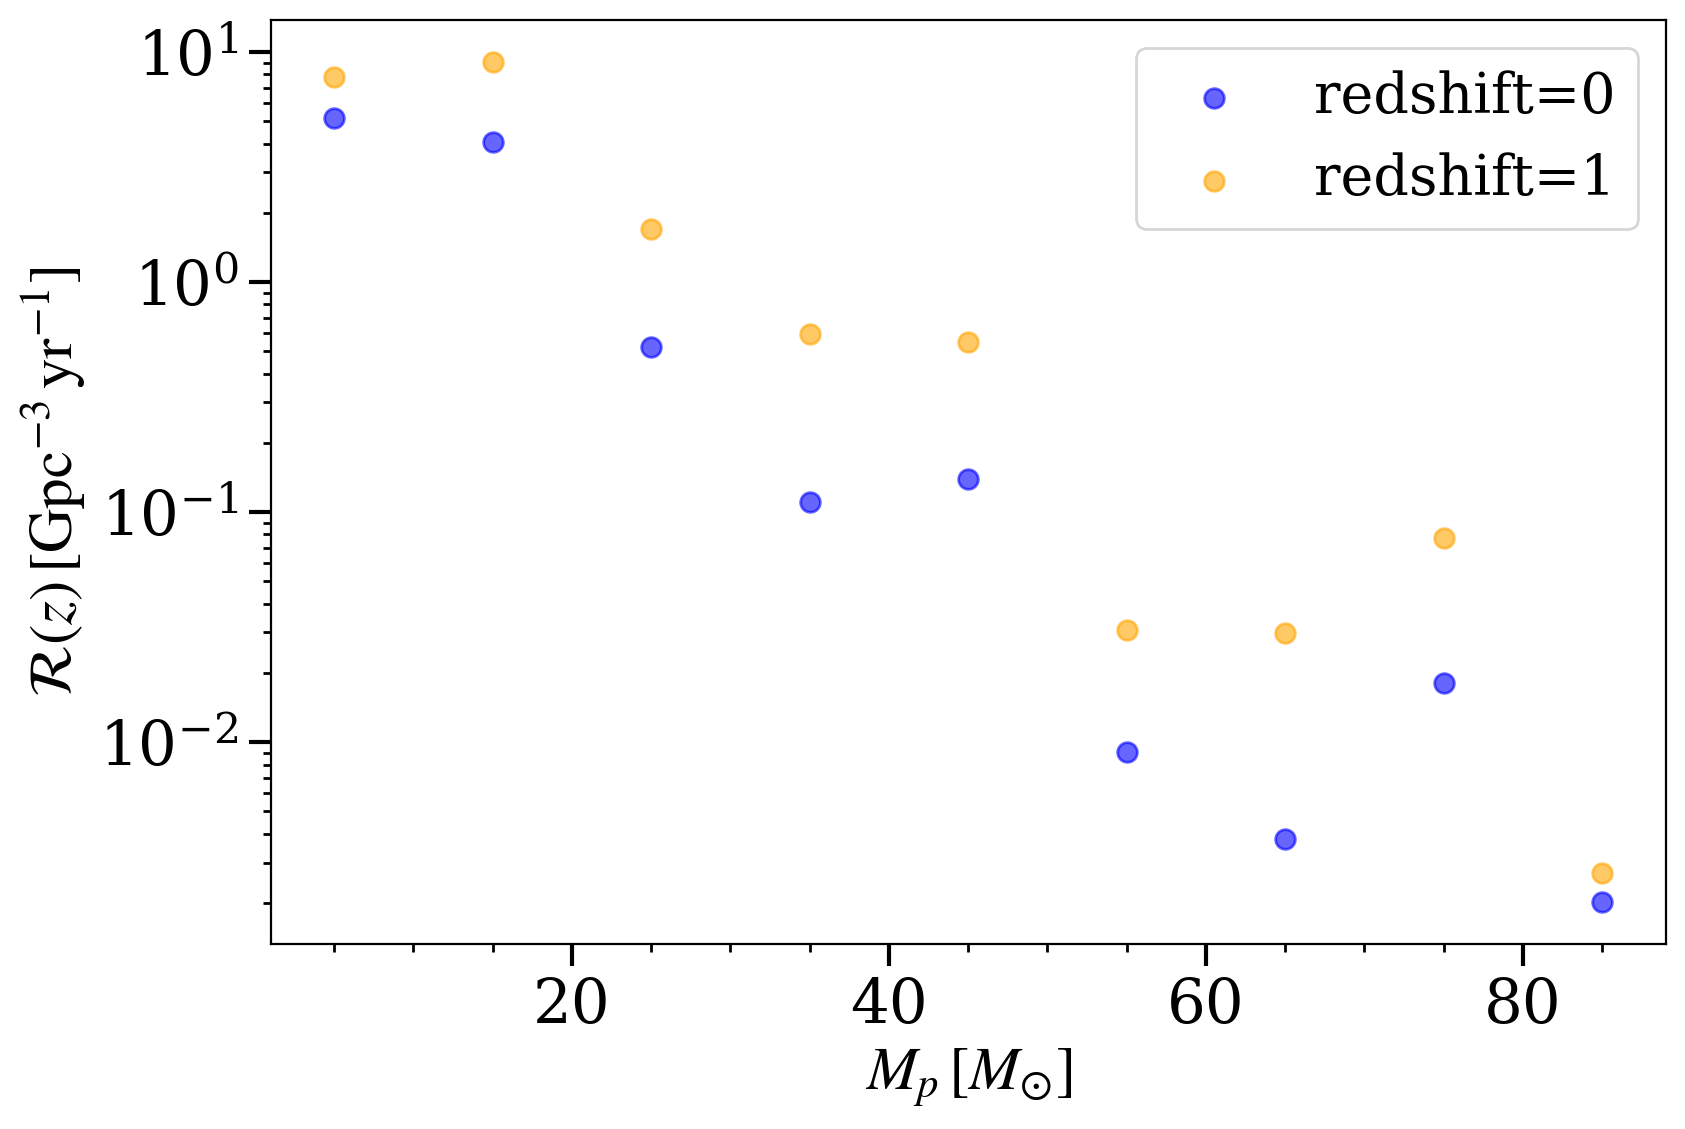

In [35]:
##Merger rate at z=0 and z=1 for finner mass bins
def mass_bins_at_z(thez, ml, mh, dz = 0.2, z_gc = 2.2, a = 2.6, b = 3.6, dNdV0 = 2.31e9, 
                      logf_disrupted_cluster = logf_disrupted_cluster_norm, sigma_dex = 0.5, Zsun = 0.02,
                     mu_rv = 2, sigma_rv = 2, beta = -2, logMstar0 = 6.26, logMlo = 4, logMhi = 8):
    R_z_c = [(1./3.)*gcr.merger_rate_at_z_pop(
        bbh_data, thez, ml, mh, z_gc, a, b, dNdV0, logf_disrupted_cluster, sigma_dex, Zsun, mu_rv, sigma_rv, beta, 
        logMstar0, logMlo, logMhi)]
    
    return R_z_c

mlow = np.linspace(0,80,9)
print(mlow)
mhigh = mlow+10.
mmid = (mlow+mhigh)/2.
R_z0 = []
R_z1 = []
for xx in range(len(mlow)):
    #print('z=0', mass_bins_at_z(0, mlow[xx], mhigh[xx]))
    #print('z=1', mass_bins_at_z(1, mlow[xx], mhigh[xx]))
    R_z0.append(mass_bins_at_z(0, mlow[xx], mhigh[xx]))
    R_z1.append(mass_bins_at_z(1, mlow[xx], mhigh[xx]))

fig, axs = plt.subplots(figsize=(9,6))
axs.scatter(mmid, R_z0, 
            s=50,color='blue', alpha=0.6, label='redshift=0')
axs.scatter(mmid, R_z1, 
            s=50, color='orange', alpha=0.6, label='redshift=1')
axs.set_yscale('log')
axs.legend(loc='best', fontsize=20)
axs.set_ylabel(r'$\mathcal{R}(z)\,[\rm{Gpc^{-3}\,yr^{-1}}]$')
axs.set_xlabel(r'$M_p\,[M_{\odot}]$')
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params('both', length=8, width=1.5, which='major')
axs.tick_params('both', length=3, width=1, which='minor')

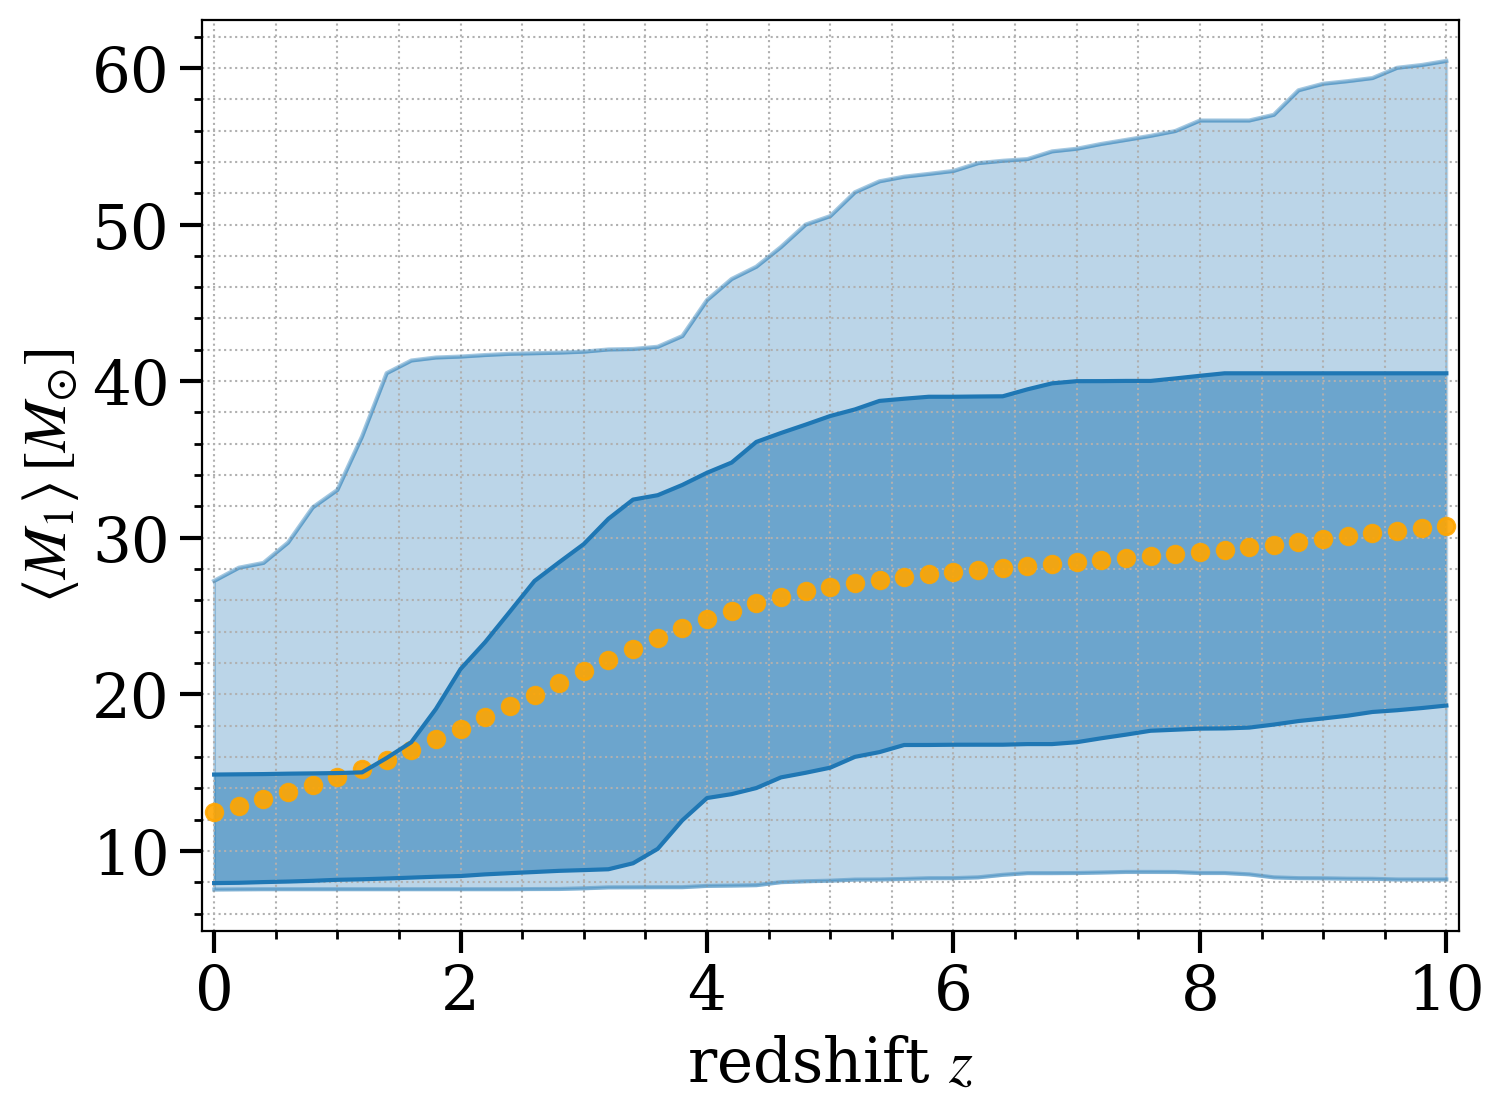

In [8]:
##Average BH mass as a function of redshift
from importlib import reload
reload(gcr)

def mass_redshift(zmin, zmax, dz = 0.2, z_gc = 2.2, a = 2.6, b = 3.6, dNdV0 = 2.31e9, 
                      logf_disrupted_cluster = logf_disrupted_cluster_norm, sigma_dex = 0.5, Zsun = 0.02,
                     mu_rv = 2, sigma_rv = 2, beta = -2, logMstar0 = 6.26, logMlo = 5, logMhi = 6):
    z_c = np.arange(zmin, zmax + dz, step = dz)
    
    mave_z_c = [gcr.ave_mass_redshift(bbh_data, z, z_gc, a, b, dNdV0, 
                                      logf_disrupted_cluster, sigma_dex, 
                                   Zsun, mu_rv, sigma_rv, beta, logMstar0, logMlo, logMhi) for z in z_c]
    
    mstd_z_c = [gcr.std_mass_redshift(bbh_data, z, z_gc, a, b, dNdV0, 
                                      logf_disrupted_cluster, sigma_dex, 
                                   Zsun, mu_rv, sigma_rv, beta, logMstar0, logMlo, logMhi) for z in z_c]
 
    return z_c, mave_z_c, mstd_z_c

def percent_redshift(zmin, zmax, dz = 0.2, z_gc = 2.2, a = 2.6, b = 3.6, dNdV0 = 2.31e9, 
                      logf_disrupted_cluster = logf_disrupted_cluster_norm, sigma_dex = 0.5, Zsun = 0.02,
                     mu_rv = 2, sigma_rv = 2, beta = -2, logMstar0 = 6.26, logMlo = 5, logMhi = 6):
    z_c = np.arange(zmin, zmax + dz, step = dz)
    mp5_z_c = [gcr.percentile_redshift(bbh_data, z, 0.05, z_gc, a, b, dNdV0, 
                                      logf_disrupted_cluster, sigma_dex, 
                                   Zsun, mu_rv, sigma_rv, beta, logMstar0, logMlo, logMhi)[0] for z in z_c]
    mp25_z_c = [gcr.percentile_redshift(bbh_data, z, 0.25, z_gc, a, b, dNdV0, 
                                      logf_disrupted_cluster, sigma_dex, 
                                   Zsun, mu_rv, sigma_rv, beta, logMstar0, logMlo, logMhi)[0] for z in z_c]
    mp75_z_c = [gcr.percentile_redshift(bbh_data, z, 0.75, z_gc, a, b, dNdV0, 
                                      logf_disrupted_cluster, sigma_dex, 
                                   Zsun, mu_rv, sigma_rv, beta, logMstar0, logMlo, logMhi)[0] for z in z_c]
    mp95_z_c = [gcr.percentile_redshift(bbh_data, z, 0.95, z_gc, a, b, dNdV0, 
                                      logf_disrupted_cluster, sigma_dex, 
                                   Zsun, mu_rv, sigma_rv, beta, logMstar0, logMlo, logMhi)[0] for z in z_c]
    
        
    return z_c, mp5_z_c, mp25_z_c, mp75_z_c, mp95_z_c


zp_grid, mp5_grid, mp25_grid, mp75_grid, mp95_grid = percent_redshift(0,10)


z_grid, mave_grid, mstd_grid = mass_redshift(0, 10)
mave_grid = np.array(mave_grid)
mstd_grid = np.array(mstd_grid)

fig, axs = plt.subplots(figsize=(8,6))
axs.scatter(z_grid, mave_grid, color='orange', alpha=0.9, zorder=2)
axs.plot(zp_grid, mp5_grid, color='tab:blue', alpha=0.4)
axs.plot(zp_grid, mp25_grid, color='tab:blue')
axs.plot(zp_grid, mp75_grid, color='tab:blue')
axs.plot(zp_grid, mp95_grid, color='tab:blue', alpha=0.4)
axs.fill_between(zp_grid, mp25_grid, mp75_grid, alpha=0.5, zorder=1)
axs.fill_between(zp_grid, mp5_grid, mp95_grid, alpha=0.3, zorder=1, color='tab:blue')
#axs.plot(z_grid, mave_grid-mstd_grid, zorder=1)
#axs.plot(z_grid, mave_grid+mstd_grid, zorder=1, color = '#1f77b4')
axs.set_xlim(xmax=10.1, xmin=-0.1)
axs.set_ylabel(r'$\langle M_1 \rangle\,[M_{\odot}]$')
axs.set_xlabel(r'redshift $z$')
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params('both', length=8, width=1.5, which='major')
axs.tick_params('both', length=3, width=1, which='minor')
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
#plt.gca().xaxis.set_ticks_position('both')
#plt.gca().yaxis.set_ticks_position('both')
#plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')
fig.tight_layout()

plt.savefig(savepath+'ave_percentiles_m_z.pdf', dpi=300)

/tmp/ipykernel_720361/3388676250.py:27: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.tight_layout()


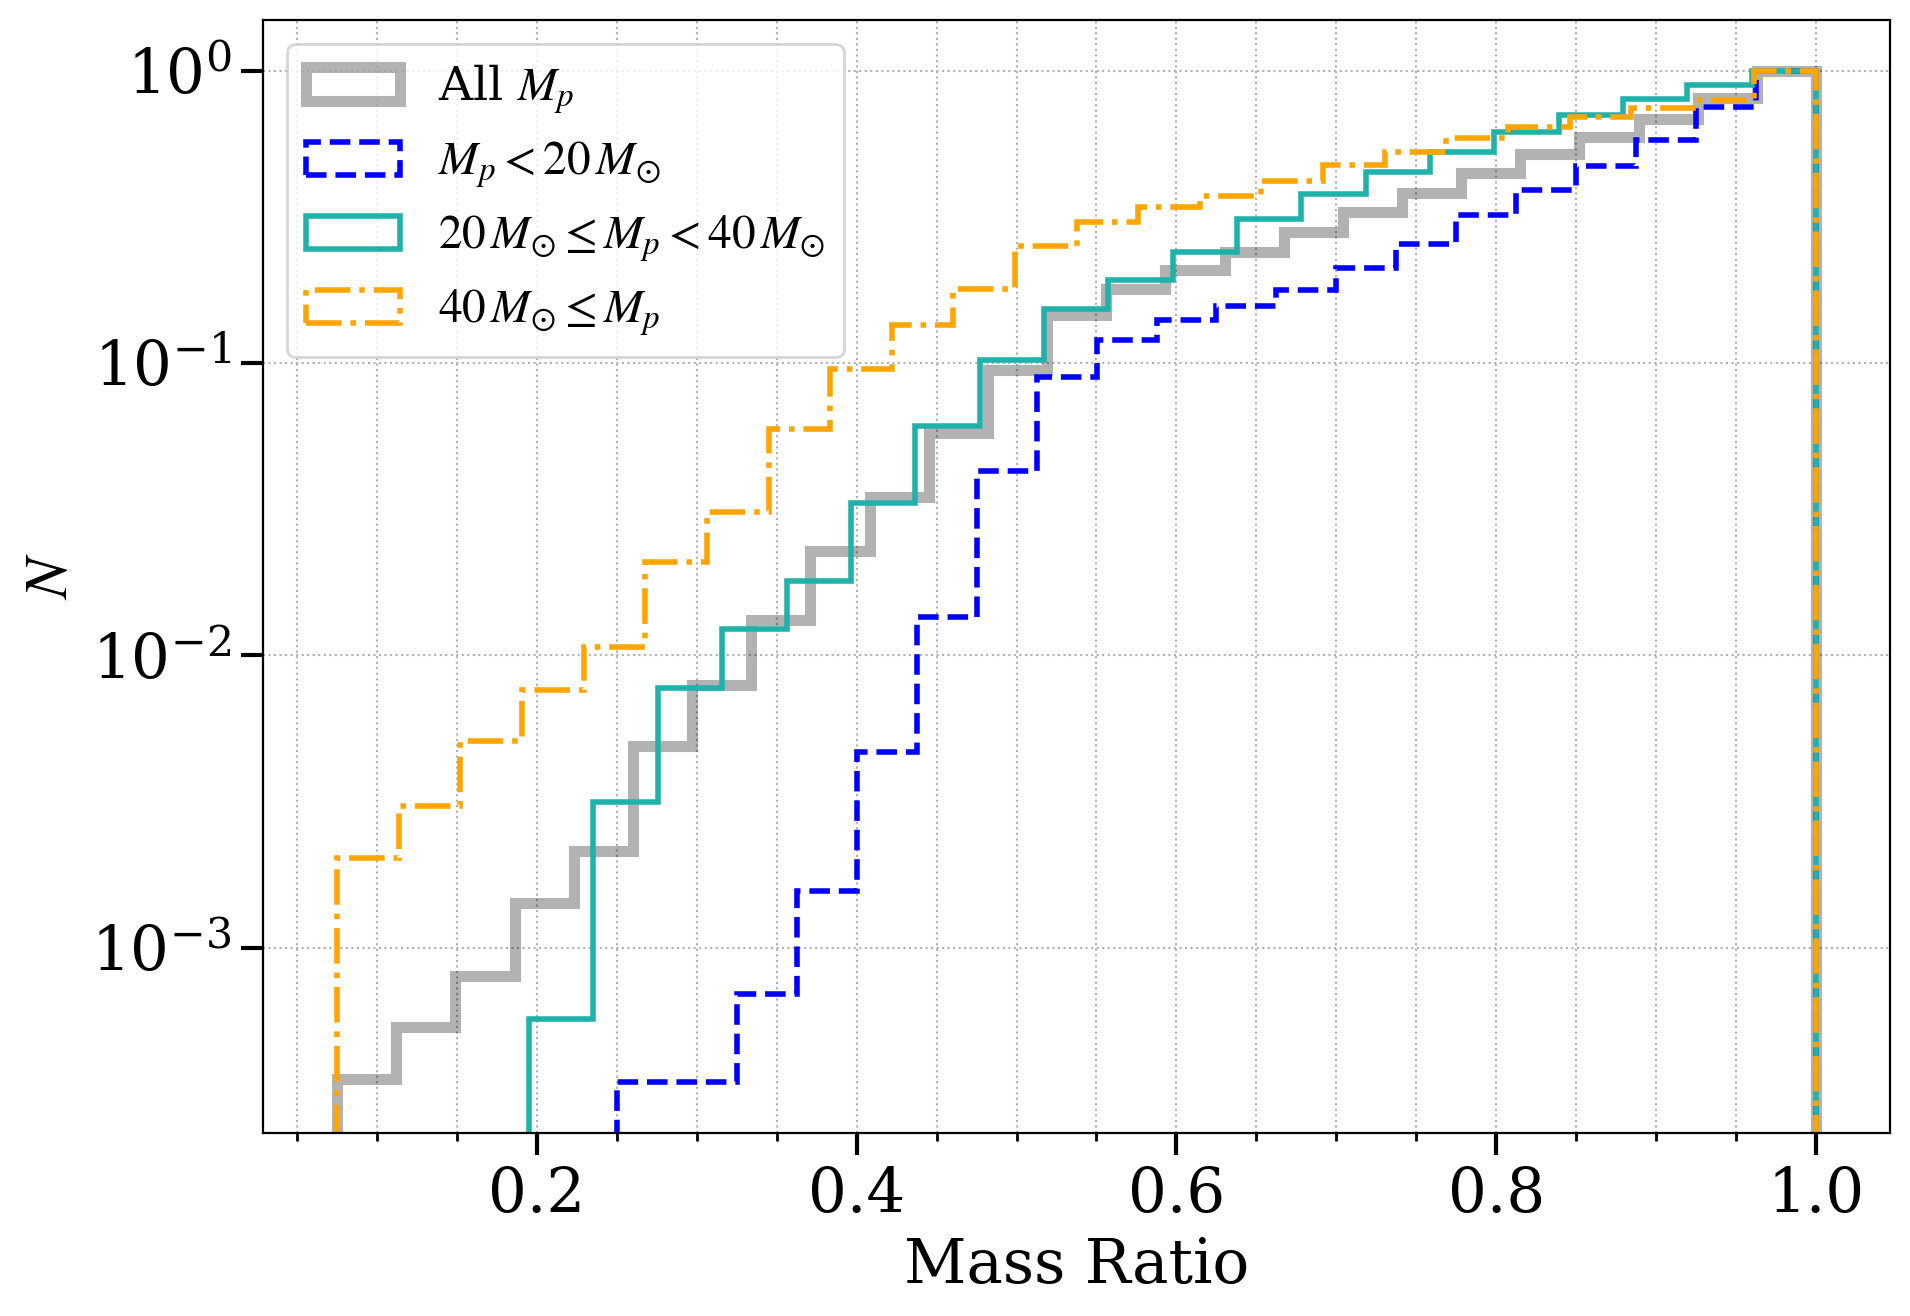

In [8]:
##Mass ratios
m_q = M1/M0

fig, axs = plt.subplots(figsize=(10,7))
axs.hist(m_q, bins=25,
         cumulative=True, density=True,
        histtype='step', color='k', alpha=0.3, lw=4., label=r'All $M_p$')
axs.hist(m_q[M0<20], bins=20, 
         cumulative=True, density=True,
         histtype='step', color='b', lw=2., ls='--', label=r'$ M_p < 20\,M_{\odot} $')
axs.hist(m_q[(M0<40) & (M0>=20)], bins=20,
         cumulative=True, density=True,
         histtype='step', color='lightseagreen', lw=2., label = r'$20 \,M_{\odot} \leq M_p < 40\,M_{\odot} $')
axs.hist(m_q[M0>=40], bins=24,
         cumulative=True, density=True,
         histtype='step', color='orange', lw=2., ls='dashdot', label = r'$40\,M_{\odot} \leq M_p$')
axs.set_yscale('log')
axs.set_xlabel('Mass Ratio')
axs.set_ylabel(r'$N$')
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params('both', length=8, width=1.5, which='major')
axs.tick_params('both', length=3, width=1, which='minor')
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
axs.legend(loc='upper left', fontsize=17)
fig.tight_layout()

#plt.savefig(savepath+'qmass_mp.pdf', dpi=300)



In [6]:
###Higher generation mergers
##Data extraction and post-processing##
allbbh = np.genfromtxt(savepath+'All_BBH_with_gen_spin.txt')
allmodel = allbbh[:,0]; alltypes = allbbh[:,3]
allt_mer = allbbh[:,1]; allm = allbbh[:,9]; allg = allbbh[:,14]
allm0 = allbbh[:,10]; allm1 = allbbh[:,11]; allm2 = allbbh[:,12]
allg0 = allbbh[:,15]; allg1 = allbbh[:,16]
allidm = allbbh[:,4]
allspin0 = allbbh[:,20]; allspin1 = allbbh[:,21]

mm_sel = allm[(allt_mer<=14000.) & (allm2==-100)]
m0_sel = allm0[(allt_mer<=14000.) & (allm2==-100)]
m1_sel = allm1[(allt_mer<=14000.) & (allm2==-100)]
g0_sel = allg0[(allt_mer<=14000.) & (allm2==-100)]
g1_sel = allg1[(allt_mer<=14000.) & (allm2==-100)]
gm_sel = allg[(allt_mer<=14000.) & (allm2==-100)]
idm_sel = allidm[(allt_mer<=14000.) & (allm2==-100)]
tmer_sel = allt_mer[(allt_mer<=14000.) & (allm2==-100)]
s0_sel = allspin0[(allt_mer<=14000.) & (allm2==-100)]
s1_sel = allspin1[(allt_mer<=14000.) & (allm2==-100)]
model_sel =  allmodel[(allt_mer<=14000.) & (allm2==-100)]
types_sel = alltypes[(allt_mer<=14000.) & (allm2==-100)]

M0_sel = np.maximum(m0_sel, m1_sel)
M1_sel = np.minimum(m0_sel, m1_sel)

chirp_sel = chirp_mass(M0_sel, M1_sel)

alpha_list = np.random.uniform(low=0., high=np.pi, size=len(m0_sel))
beta_list = np.random.uniform(low=0., high=np.pi, size=len(m0_sel))
chieff_sel = chi_eff(m0_sel, m1_sel, s0_sel, s1_sel, alpha_list, beta_list)

print('>40', len(M0_sel[M0_sel>=40]), len(M0_sel[(M0_sel>=40) & (gm_sel==1)]), 
      len(M0_sel[(M0_sel>=40) & (gm_sel==1)])/len(M0_sel[M0_sel>=40]))
print('20<M0<40', len(M0_sel[(M0_sel>=20) & (M0_sel<40)]), len(M0_sel[(M0_sel>=20) & (M0_sel<40) & (gm_sel==1)]),
     len(M0_sel[(M0_sel>=20) & (M0_sel<40) & (gm_sel==1)])/len(M0_sel[(M0_sel>=20) & (M0_sel<40)]))
print('<20', len(M0_sel[M0_sel<40]), len(M0_sel[(M0_sel<40) & (gm_sel==1)]),
     len(M0_sel[(M0_sel<40) & (gm_sel==1)])/len(M0_sel[M0_sel<40]))

>40 1969 1338 0.6795327577450483
20<M0<40 3495 2911 0.8329041487839771
<20 9265 8179 0.8827846735024285


2028.369755576324
2163.1977686640316
3240.9545153543077
4212.872312539352
-------
486.82893499022805
609.7770203363431
1679.990918748116
3414.405882566891
-------
1274.7821251305731
1438.0498324056903
2501.8438215484202
3807.2731920749816


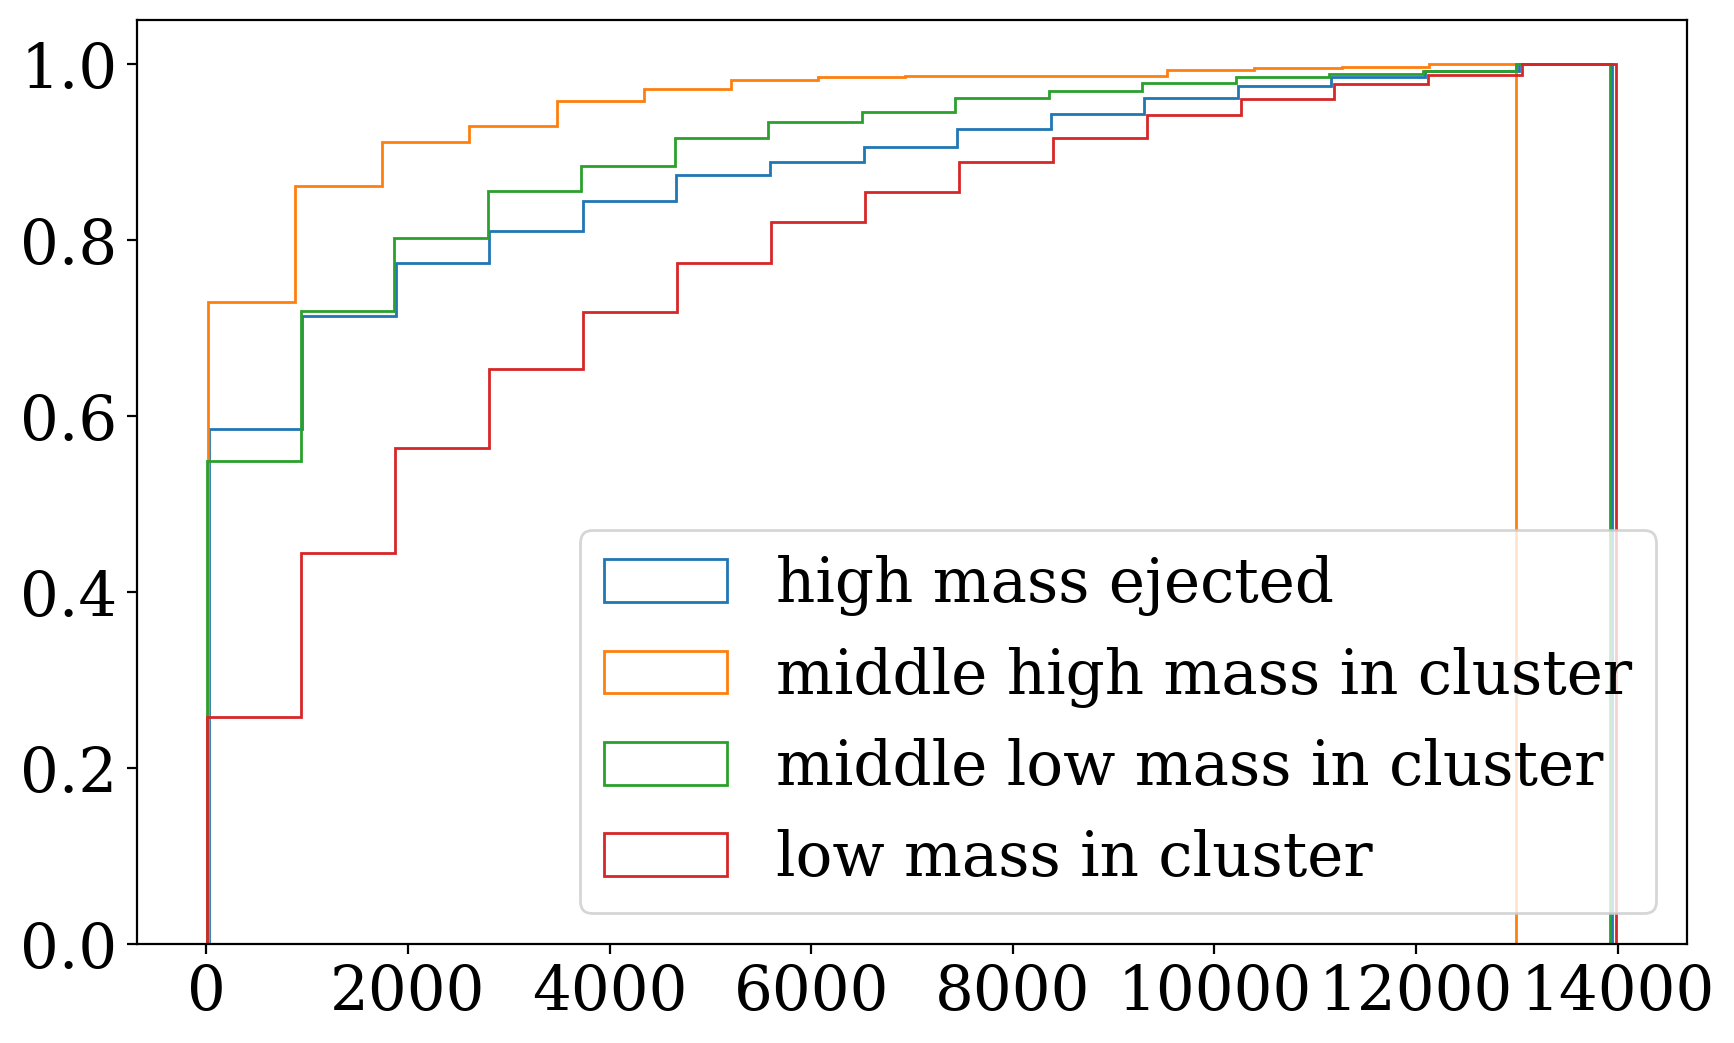

In [11]:
##Merger times for ejected and incluster mergers

print(np.mean(tmer_sel[(M0_sel>=40) & (types_sel==3) & (gm_sel==2)]))
print(np.mean(tmer_sel[(M0_sel>=30) & (M0_sel<40) & (types_sel==3) & (gm_sel==1)]))
print(np.mean(tmer_sel[(M0_sel>=20) & (M0_sel<30) & (types_sel==3) & (gm_sel==1)]))
print(np.mean(tmer_sel[(M0_sel<20) & (types_sel==3) & (gm_sel==1)]))
print('-------')
print(np.mean(tmer_sel[(M0_sel>=40) & (types_sel!=3) & (gm_sel==2)]))
print(np.mean(tmer_sel[(M0_sel>=30) & (M0_sel<40) & (types_sel!=3) & (gm_sel==1)]))
print(np.mean(tmer_sel[(M0_sel>=20) & (M0_sel<30) & (types_sel!=3) & (gm_sel==1)]))
print(np.mean(tmer_sel[(M0_sel<20) & (types_sel!=3) & (gm_sel==1)]))
print('-------')
print(np.mean(tmer_sel[(M0_sel>=40) & (gm_sel==2)]))
print(np.mean(tmer_sel[(M0_sel>=30) & (M0_sel<40) & (gm_sel==1)]))
print(np.mean(tmer_sel[(M0_sel>=20) & (M0_sel<30) & (gm_sel==1)]))
print(np.mean(tmer_sel[(M0_sel<20) & (gm_sel==1)]))


fig, ax = plt.subplots(figsize=(10,6))
ax.hist(tmer_sel[(M0_sel>=40) & (types_sel==3)],
        bins=15,
        cumulative=True, density=True,
       histtype='step', label='high mass ejected')
ax.hist(tmer_sel[(M0_sel>=30) & (M0_sel<40) & (types_sel!=3)],
        bins=15,
        cumulative=True, density=True,
       histtype='step', label='middle high mass in cluster')
ax.hist(tmer_sel[(M0_sel>=20) & (M0_sel<30) & (types_sel!=3)],
        bins=15,
        cumulative=True, density=True,
       histtype='step', label='middle low mass in cluster')
ax.hist(tmer_sel[(M0_sel<20) & (types_sel!=3)],
        bins=15,
        cumulative=True, density=True,
       histtype='step', label='low mass in cluster')
ax.legend(loc='lower right')

9517 1709 6
121 308
[  1   4   8  36  57  31  38  45  73  98 108 119 125 145 120 164 175 178
 208 239 300 289 316 395 361 396 387 445 410 409 450 433 409 459 467 438
 421 417 343] [ 0  0  0  0  0  0  0  3  6  9 12 24 23 33 29 24 34 35 47 55 56 66 62 63
 81 82 69 90 72 84 74 83 80 75 66 79 72 69 52] [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 1 0 0 0
 0 0] [5.29195058e+00 6.47691251e+00 7.92720851e+00 9.70225159e+00
 1.18747584e+01 1.45337282e+01 1.77880886e+01 2.17711583e+01
 2.66461081e+01 3.26126460e+01 3.99151980e+01 4.88529212e+01
 5.97919599e+01 7.31804439e+01 8.95668479e+01 1.09622459e+02
 1.34168879e+02 1.64211679e+02 2.00981597e+02 2.45984954e+02
 3.01065364e+02 3.68479258e+02 4.50988322e+02 5.51972635e+02
 6.75569133e+02 8.26841086e+02 1.01198552e+03 1.23858709e+03
 1.51592879e+03 1.85537223e+03 2.27082310e+03 2.77930081e+03
 3.40163573e+03 4.16332251e+03 5.09556453e+03 6.23655212e+03
 7.63302715e+03 9.34219779e+03 1.14340822e+04 1.39943767e+04]
[0.     

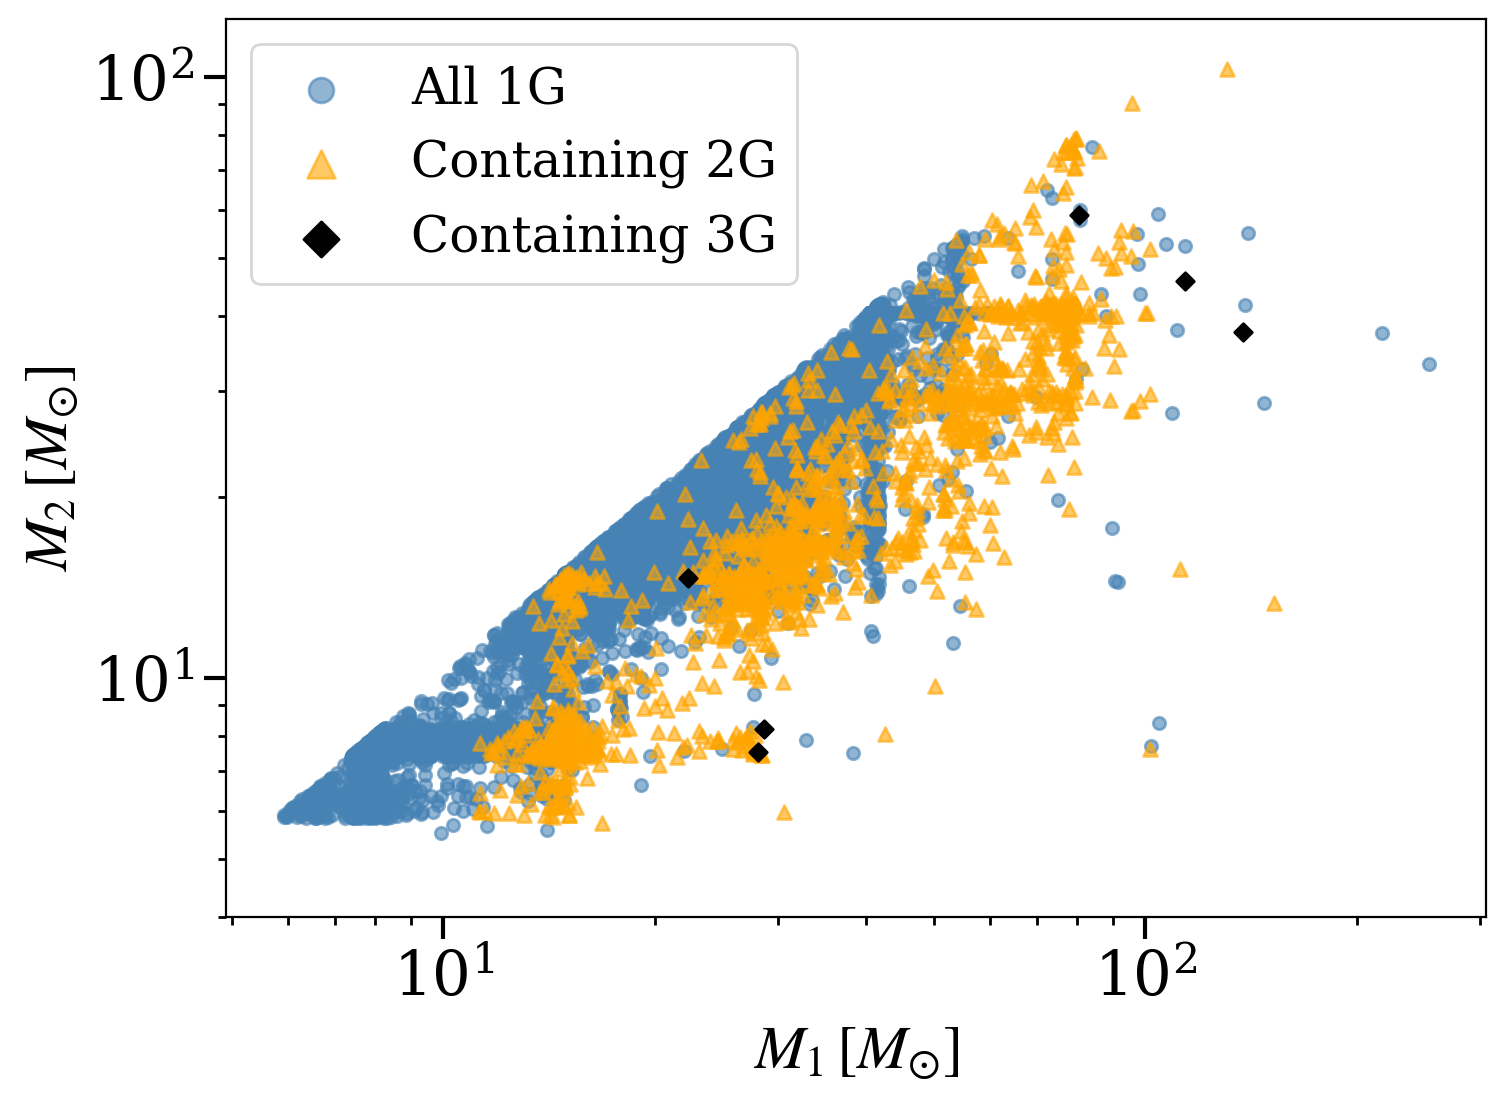

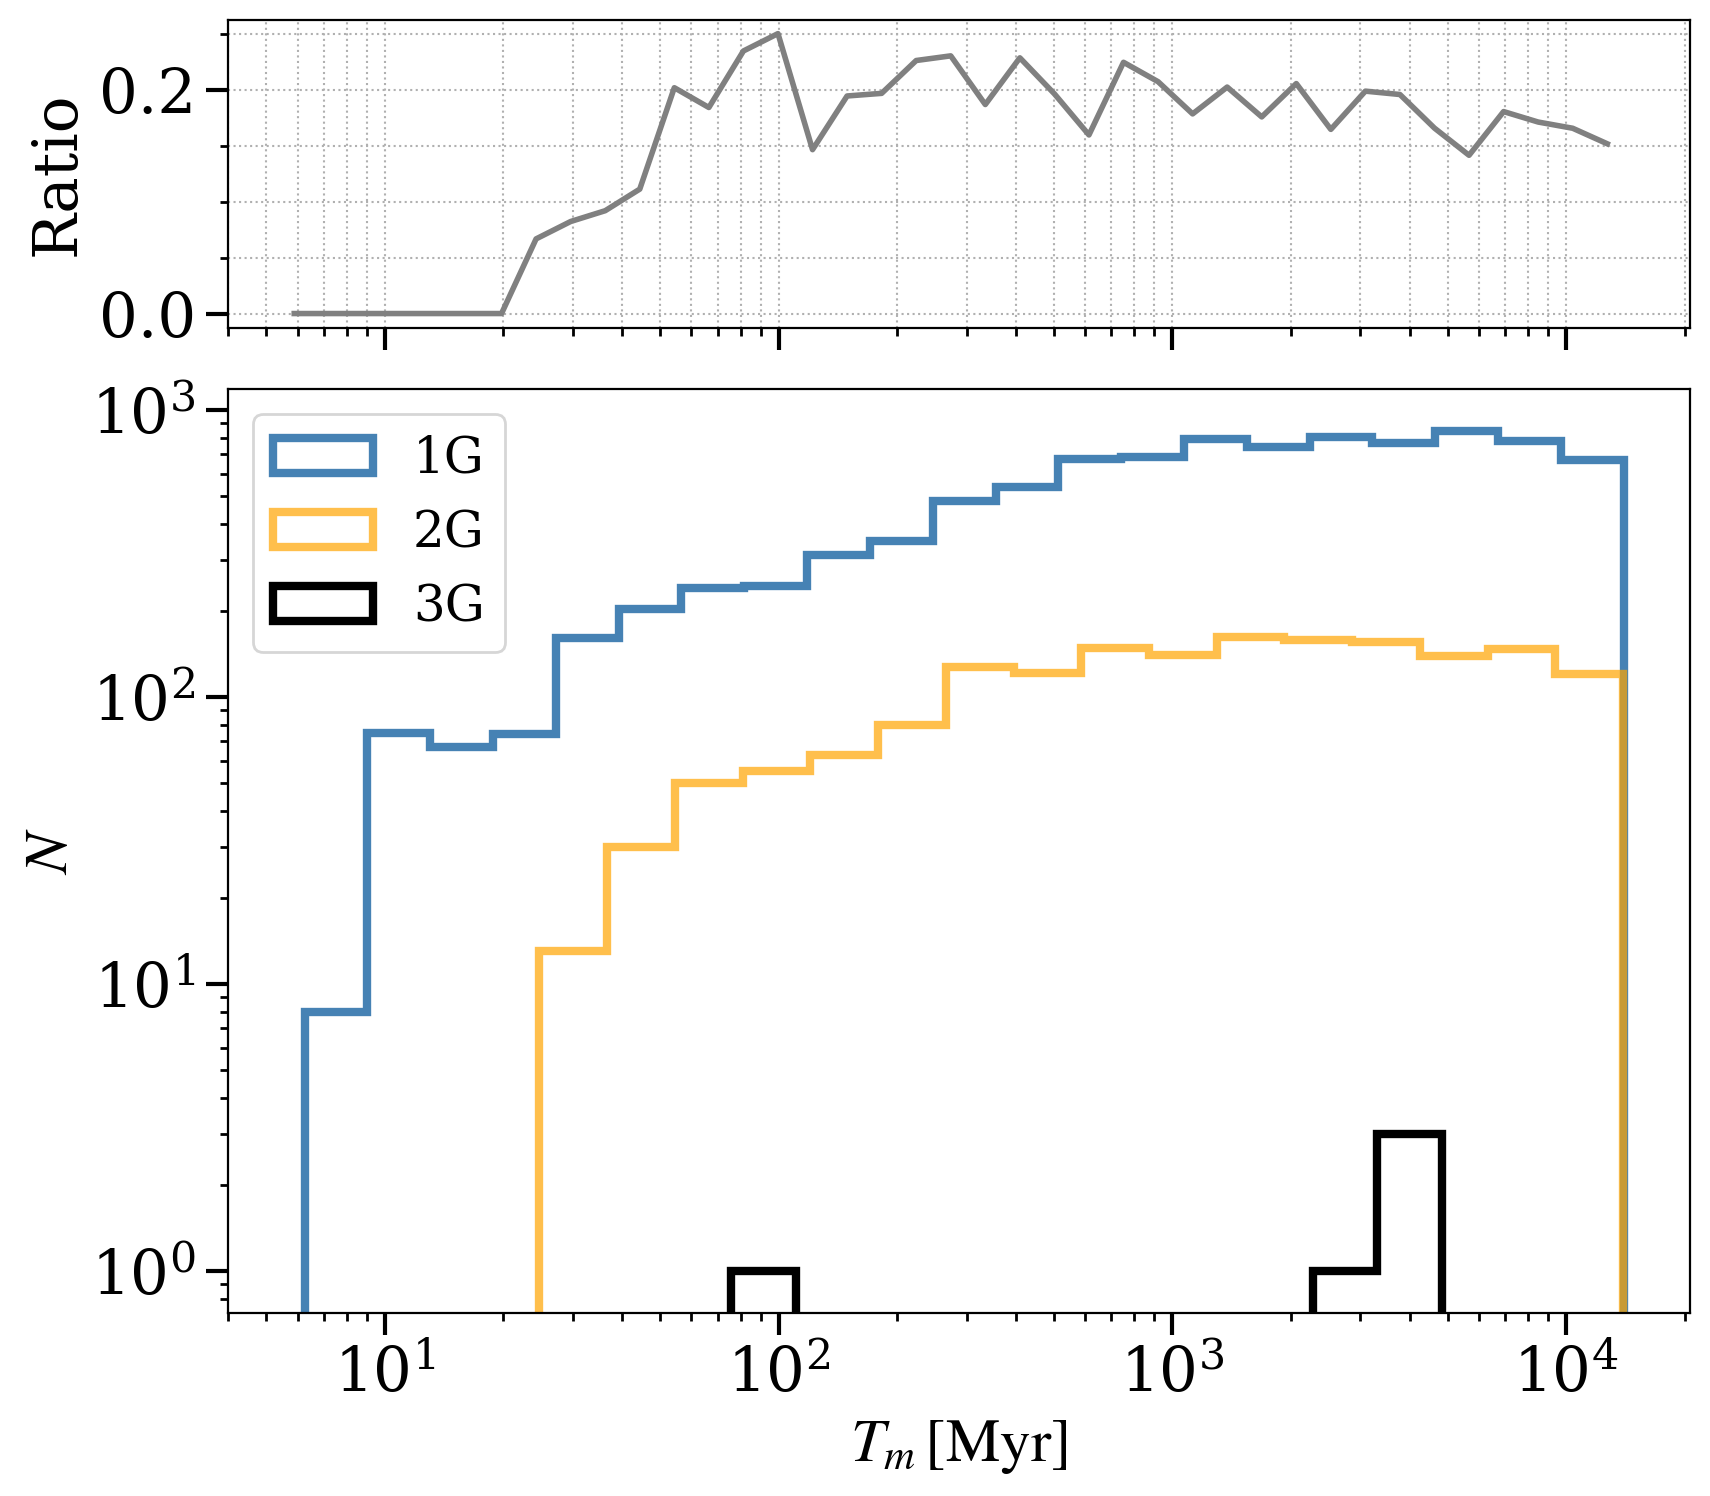

In [11]:
##Mass and merger time of different gen mergers
#fig, axs = plt.subplots(figsize=(9,6))
#axs.hist(chirp_sel[gm_sel==1], bins=15,
#         lw=3, histtype='step', color='k', label = '1G')
#axs.hist(chirp_sel[gm_sel==2], bins=20,
#         lw=3, histtype='step', color='forestgreen', label = '2G')
#axs.hist(chirp_sel[gm_sel==3], 
#         lw=3, histtype='step', color='gold', label = '3G')
#axs.set_yscale('log')
#axs.legend(loc='best')
#axs.set_xlabel('Chirp Mass')
#axs.set_ylabel(r'$N$')

print(len(chirp_sel[gm_sel==1]), len(chirp_sel[gm_sel==2]), len(chirp_sel[gm_sel==3]))
print(len(chirp_sel[(chirp_sel>=40) & (gm_sel==1)]), len(chirp_sel[(chirp_sel>=40) & (gm_sel==2)]))

t_bin = np.logspace(np.log10(np.min(tmer_sel))/1.1, np.log10(np.max(tmer_sel)+1), 40)
hist_g1, bin_g1 = np.histogram(tmer_sel[gm_sel==1], bins=t_bin)
hist_g2, bin_g2 = np.histogram(tmer_sel[gm_sel==2], bins=t_bin)
hist_g3, bin_g3 = np.histogram(tmer_sel[gm_sel==3], bins=t_bin)
print(hist_g1, hist_g2, hist_g3, t_bin)
gratio = (hist_g2+hist_g3)/hist_g1
t_ratio = (t_bin[1:]+t_bin[:-1])/2.
print(gratio)

fig,ax = plt.subplots(figsize=(8, 6))
ax.scatter(M0_sel[gm_sel==1], M1_sel[gm_sel==1],
      color='steelblue', alpha=0.6, s=20, label = 'All 1G', rasterized = True)
ax.scatter(M0_sel[gm_sel==2], M1_sel[gm_sel==2],
     color='orange',alpha=0.6, s=25, marker='^', label = 'Containing 2G', rasterized = True)
ax.scatter(M0_sel[gm_sel==3], M1_sel[gm_sel==3],
     color='k', s=20, marker='D', label = 'Containing 3G')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(ymin=4)
ax.legend(loc='upper left', fontsize=18, markerscale=2)
ax.set_xlabel(r'$M_1\,[M_{\odot}]$')
ax.set_ylabel(r'$M_2\,[M_{\odot}]$')
ax.tick_params('both', length=8, width=1.5, which='major')
ax.tick_params('both', length=3, width=1, which='minor')

fig.tight_layout()
plt.savefig(savepath+'m1m2_gen.pdf', dpi=300)


fig, axs = plt.subplots(nrows=2, figsize=(9,8), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
axs[0].plot(t_ratio, gratio, lw=2, color='gray')
axs[0].yaxis.set_minor_locator(AutoMinorLocator())
axs[0].tick_params('both', length=8, width=1.5, which='major')
axs[0].tick_params('both', length=3, width=1, which='minor')
axs[0].grid(linestyle=':',which='major',linewidth='0.75')
axs[0].grid(linestyle=':',which='minor',linewidth='0.75')
axs[0].set_ylabel('Ratio')

axs[1].hist(tmer_sel[gm_sel==1],
           bins=np.logspace(np.min(np.log10(tmer_sel[gm_sel==1])), np.max(np.log10(tmer_sel[gm_sel==1])), 22),
           histtype='step', color = 'steelblue', lw=3, label = '1G')
axs[1].hist(tmer_sel[gm_sel==2],
           bins=np.logspace(np.min(np.log10(tmer_sel[gm_sel==2])), np.max(np.log10(tmer_sel[gm_sel==2])), 17),
           histtype='step', color='orange', alpha=0.7, lw=3, label = '2G')
axs[1].hist(tmer_sel[gm_sel==3],
           bins=np.logspace(np.min(np.log10(tmer_sel[gm_sel==3])), np.max(np.log10(tmer_sel[gm_sel==3])), 12),
           histtype='step', color='k', lw=3, label = '3G')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$T_m\,[{\rm Myr}]$')
axs[1].set_ylabel(r'$N$')
axs[1].legend(loc='upper left', fontsize=18)
axs[1].tick_params('both', length=8, width=1.5, which='major')
axs[1].tick_params('both', length=3, width=1, which='minor')

fig.tight_layout()
plt.subplots_adjust(hspace=0.1)
#plt.savefig(savepath+'t_ratio_gen.pdf', dpi=300)

[ 2  1  0  2  5  6  8  7 11 20 14 19 19 24] [0 0 0 0 0 1 1 2 1 0 2 4 0 4] [0 0 0 0 0 0 0 0 0 0 0 0 0 0] [9.00882574e+00 1.51569049e+01 2.55007448e+01 4.29037452e+01
 7.21834348e+01 1.21445068e+02 2.04325336e+02 3.43767299e+02
 5.78371522e+02 9.73081554e+02 1.63716171e+03 2.75444382e+03
 4.63421585e+03 7.79683956e+03 1.31177979e+04]


/tmp/ipykernel_233303/2616555206.py:22: RuntimeWarning: invalid value encountered in divide
  gratio = (hist_g2+hist_g3)/hist_g1


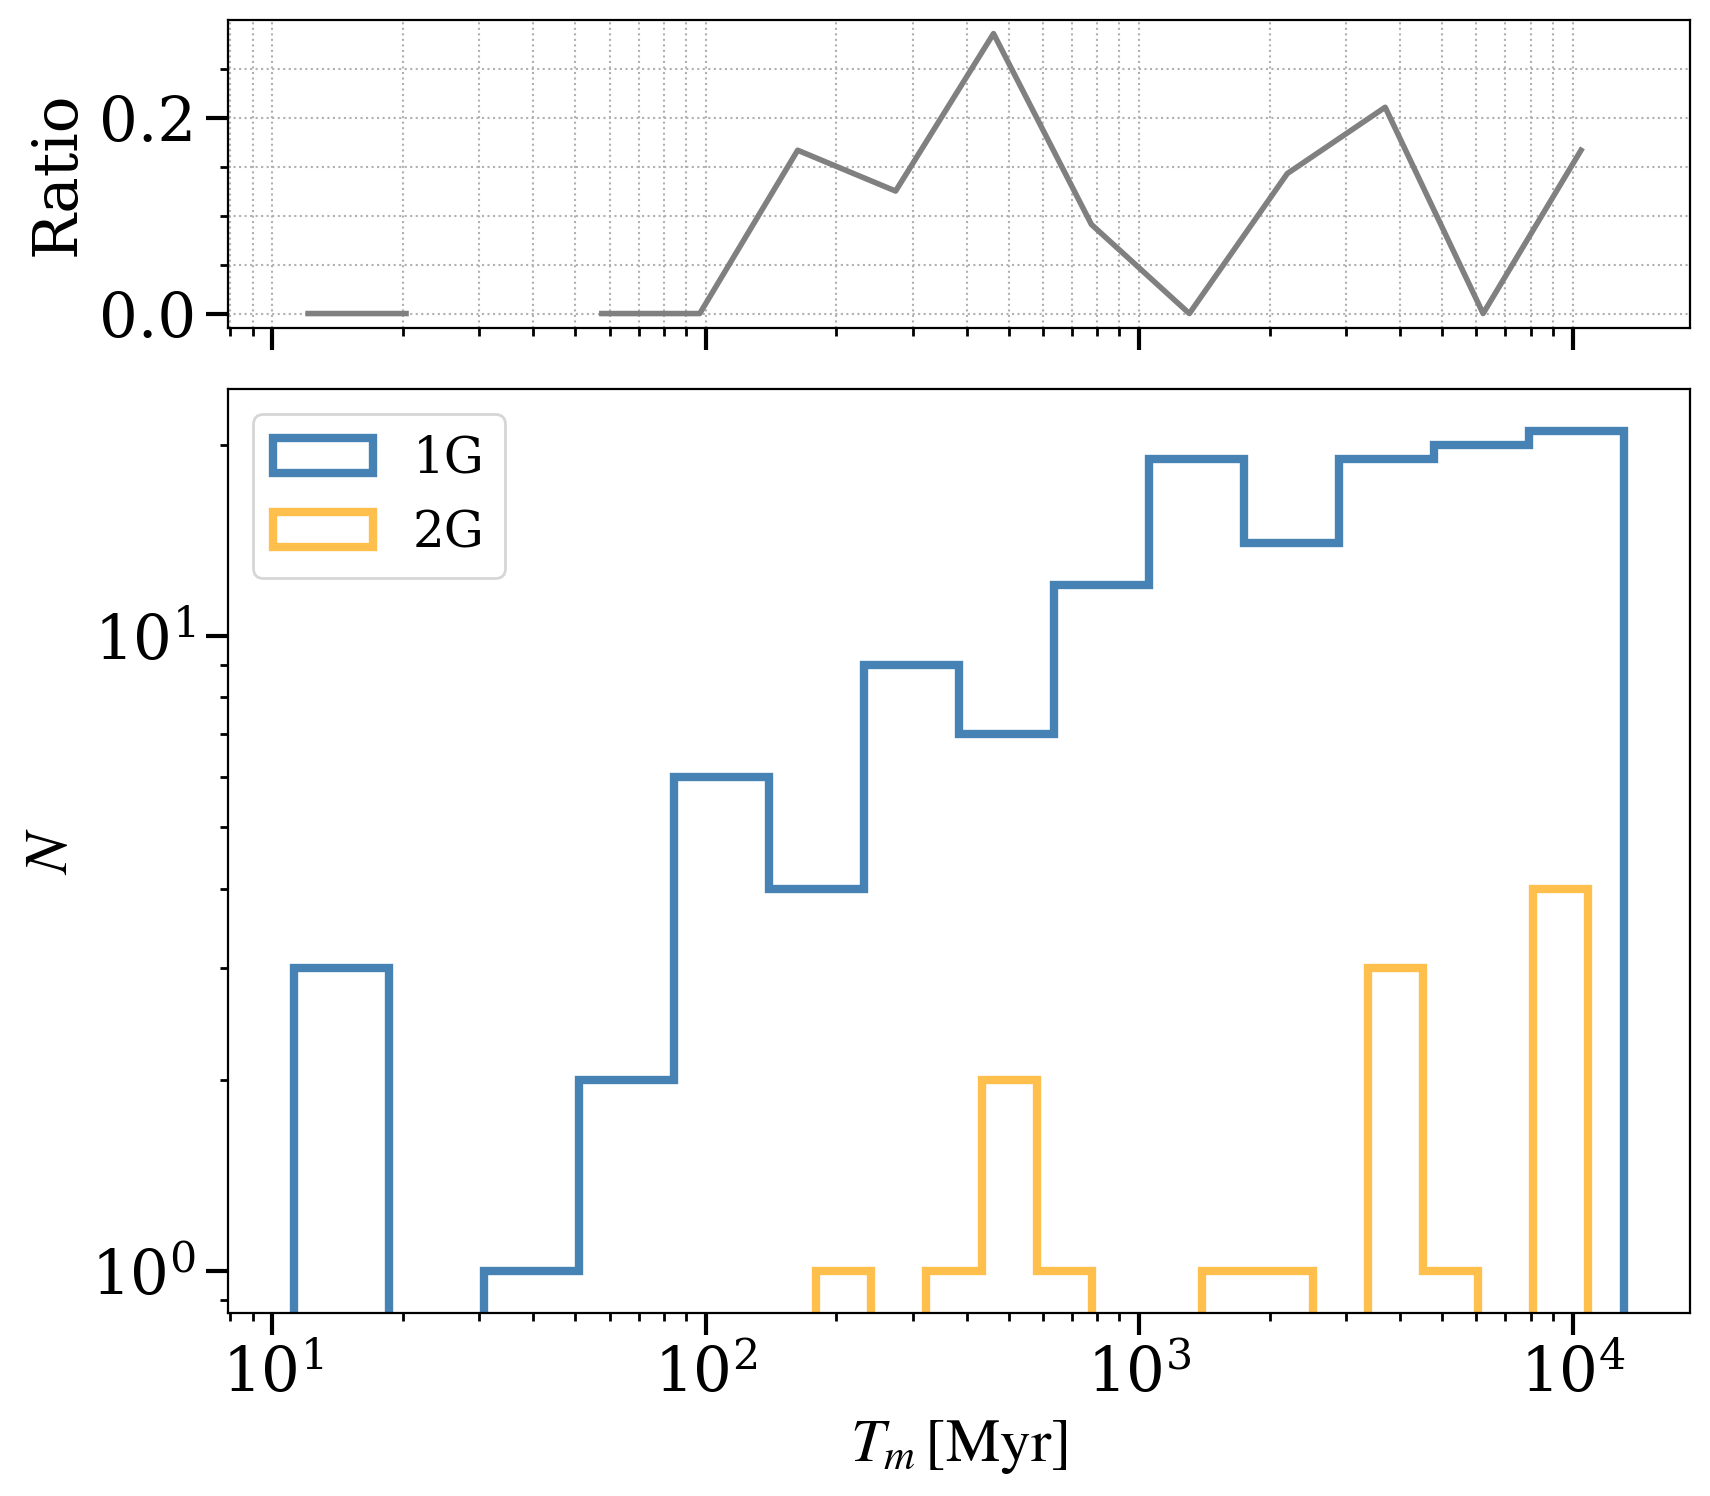

In [37]:
###For a single cluster###
#14 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/
#18 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.002/8e5/
#50 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.0002/8e5/
#54 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.002/8e5/
#19 /projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.002/1.6e6/
#51 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.0002/1.6e6/
#55 /projects/b1091/CMC_Grid_March2019/rundir/rv1/rg8/z0.002/1.6e6/
#87 /projects/b1091/CMC_Grid_March2019/rundir/rv2/rg8/z0.0002/1.6e6/
#91 /projects/b1091/CMC_Grid_March2019/rundir/rv2/rg8/z0.002/1.6e6/
mno = 91
sel_cond1 = (gm_sel==1) & (model_sel==mno)
sel_cond2 = (gm_sel==2) & (model_sel==mno)
sel_cond3 = (gm_sel==3) & (model_sel==mno)
model_cond = model_sel==mno

t_bin = np.logspace(np.log10(np.min(tmer_sel[model_cond]))/1.1, np.log10(np.max(tmer_sel[model_cond])+1), 15)
hist_g1, bin_g1 = np.histogram(tmer_sel[sel_cond1], bins=t_bin)
hist_g2, bin_g2 = np.histogram(tmer_sel[sel_cond2], bins=t_bin)
hist_g3, bin_g3 = np.histogram(tmer_sel[sel_cond3], bins=t_bin)
print(hist_g1, hist_g2, hist_g3, t_bin)
gratio = (hist_g2+hist_g3)/hist_g1
t_ratio = (t_bin[1:]+t_bin[:-1])/2.

fig, axs = plt.subplots(nrows=2, figsize=(9,8), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
axs[0].plot(t_ratio, gratio, lw=2, color='gray')
axs[0].yaxis.set_minor_locator(AutoMinorLocator())
axs[0].tick_params('both', length=8, width=1.5, which='major')
axs[0].tick_params('both', length=3, width=1, which='minor')
axs[0].grid(linestyle=':',which='major',linewidth='0.75')
axs[0].grid(linestyle=':',which='minor',linewidth='0.75')
axs[0].set_ylabel('Ratio')

axs[1].hist(tmer_sel[sel_cond1],
           bins=np.logspace(np.min(np.log10(tmer_sel[sel_cond1])), np.max(np.log10(tmer_sel[sel_cond1])), 15),
           histtype='step', color = 'steelblue', lw=3, label = '1G')
axs[1].hist(tmer_sel[sel_cond2],
           bins=np.logspace(np.min(np.log10(tmer_sel[sel_cond2])), np.max(np.log10(tmer_sel[sel_cond2])), 15),
           histtype='step', color='orange', alpha=0.7, lw=3, label = '2G')
#axs[1].hist(tmer_sel[sel_cond3],
#           bins=np.logspace(np.min(np.log10(tmer_sel[sel_cond3])), np.max(np.log10(tmer_sel[sel_cond3])), 15),
#           histtype='step', color='k', lw=3, label = '3G')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$T_m\,[{\rm Myr}]$')
axs[1].set_ylabel(r'$N$')
axs[1].legend(loc='upper left', fontsize=18)
axs[1].tick_params('both', length=8, width=1.5, which='major')
axs[1].tick_params('both', length=3, width=1, which='minor')

fig.tight_layout()
plt.subplots_adjust(hspace=0.1)

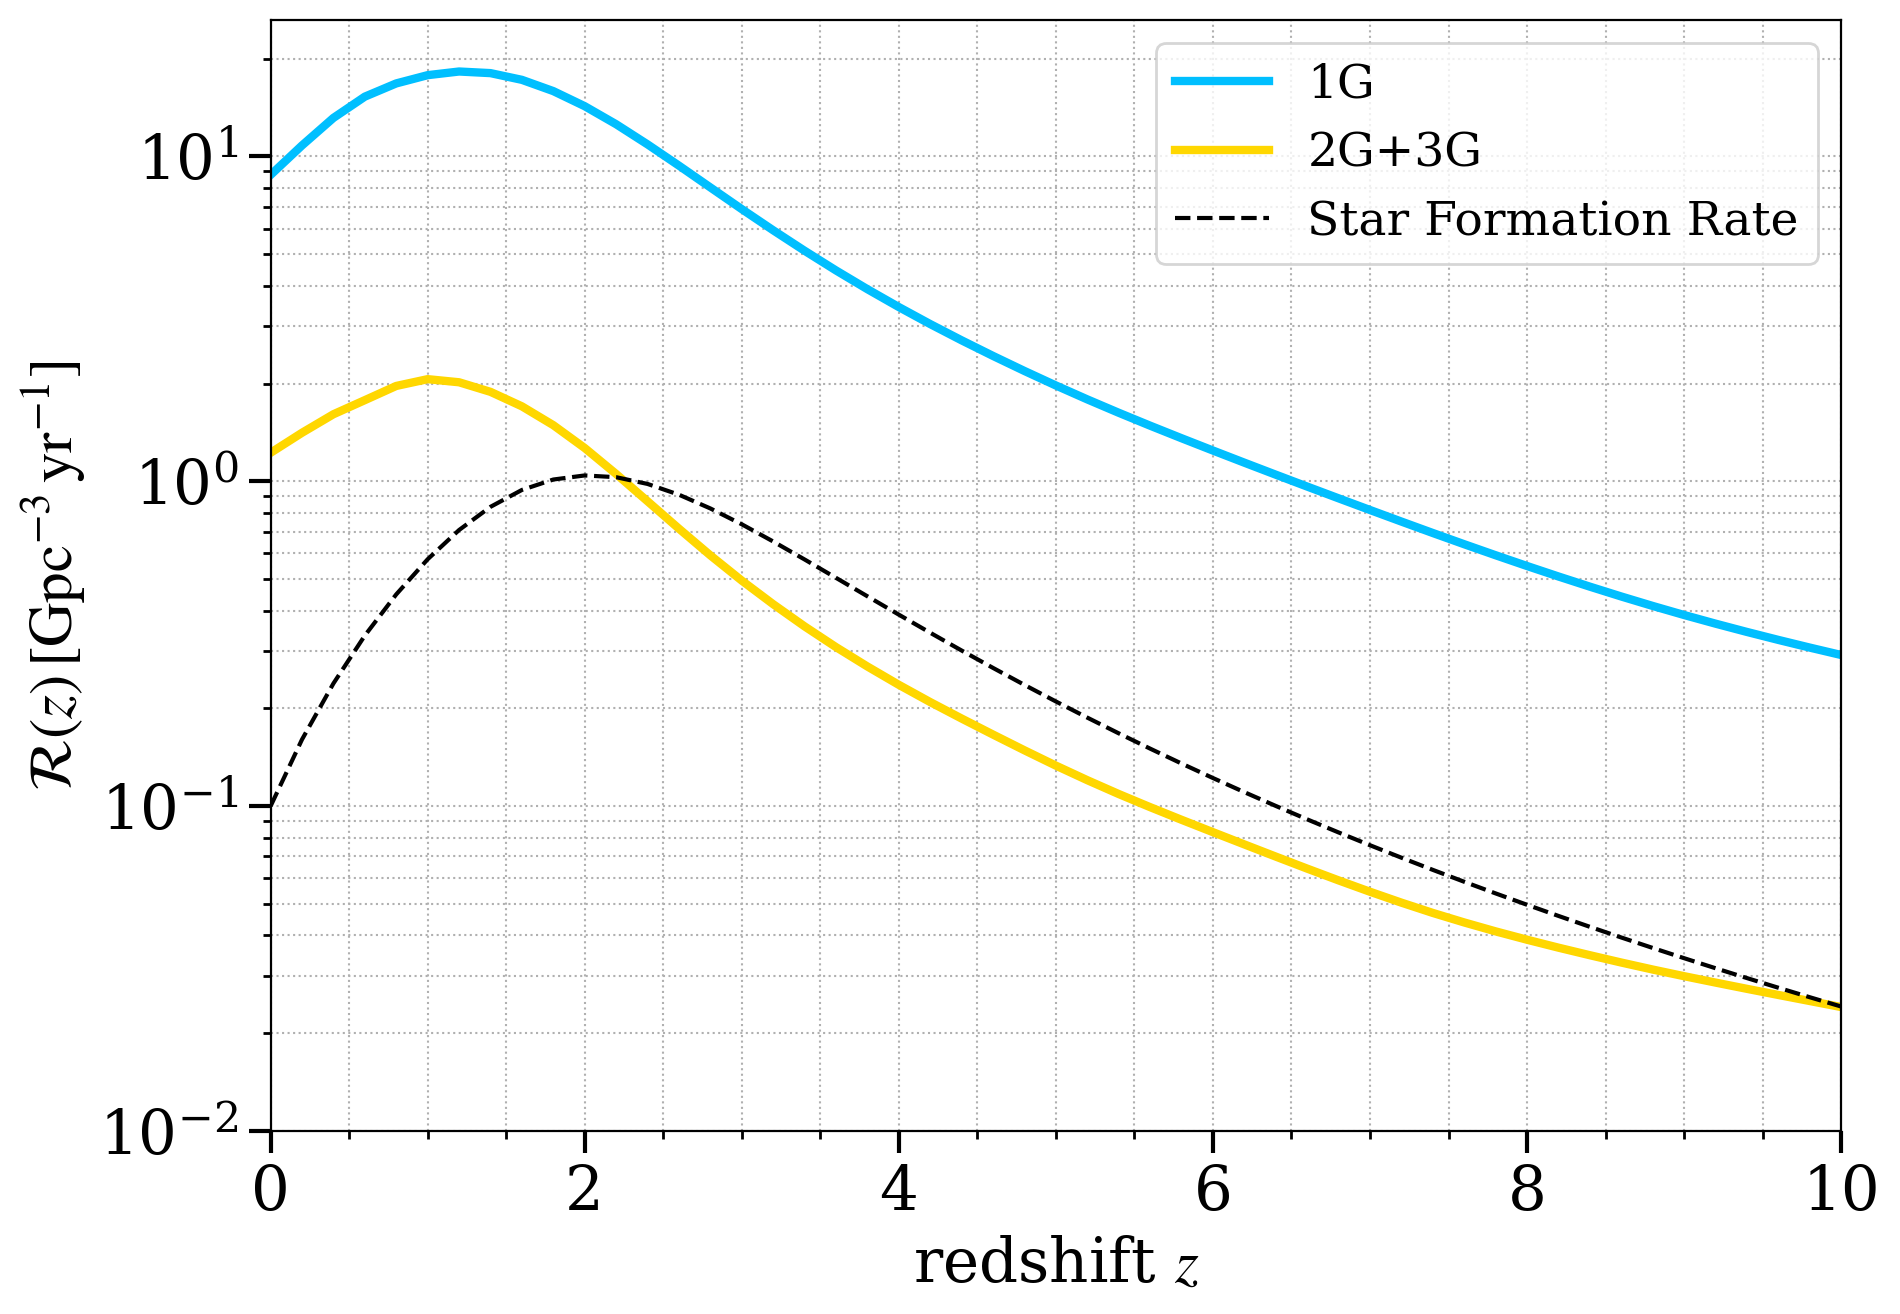

In [16]:
from importlib import reload
reload(gcr)

##Plotting function
def plot_cluster_rate_gen(zmin, zmax, ngen, dz = 0.2, z_gc = 2.2, a = 2.6, b = 3.6, dNdV0 = 2.31e9, 
                      logf_disrupted_cluster = logf_disrupted_cluster_norm, sigma_dex = 0.5, Zsun = 0.02,
                     mu_rv = 2, sigma_rv = 2, beta = -2, logMstar0 = 6.26, logMlo = 4, logMhi = 8, plot_kwargs = {}):
    z_c = np.arange(zmin, zmax + dz, step = dz)
    R_z_c = [1./3.*gcr.merger_rate_at_z_pop_gen(
        bbh_data, z, ngen, z_gc, a, b, dNdV0, logf_disrupted_cluster, sigma_dex, Zsun, mu_rv, sigma_rv, beta, 
        logMstar0, logMlo, logMhi) for z in z_c]
    ##the 1/3 takes into account the fact that there are three galactriccentric distances
    plt.plot(z_c, R_z_c, **plot_kwargs)
    plt.xlabel(r'redshift $z$')
    plt.xlim(zmin, zmax)
    plt.ylabel(r'$\mathcal{R}(z)\,[\rm{Gpc^{-3}\,yr^{-1}}]$')
    plt.yscale('log')
    
    
zgrid = np.arange(0, 10. + dz, step = dz)
gcr_grid = 0.1*gcr.redshift_peak(zgrid, a = 2.6, b = 3.6, zp = 2.2)

fig, ax = plt.subplots(figsize=(10,7))
plot_cluster_rate_gen(0, 20, '1G', 
                  plot_kwargs = dict(label = '1G',linewidth = 3, color='deepskyblue'))
plot_cluster_rate_gen(0, 20, '2G',
                  plot_kwargs = dict(label = '2G+3G',linewidth = 3, color='gold'))

ax.plot(zgrid, gcr_grid, ls='--', color='k', label='Star Formation Rate')

ax.set_xlim(xmax=10)
ax.set_ylim(ymin=0.01)
plt.legend(loc='upper right', fontsize=17, frameon=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params('both', length=8, width=1.5, which='major')
ax.tick_params('both', length=3, width=1, which='minor')
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')


fig.tight_layout()

0.05240174672489083
0.0613682092555332
0.04063604240282685
0.03431372549019608


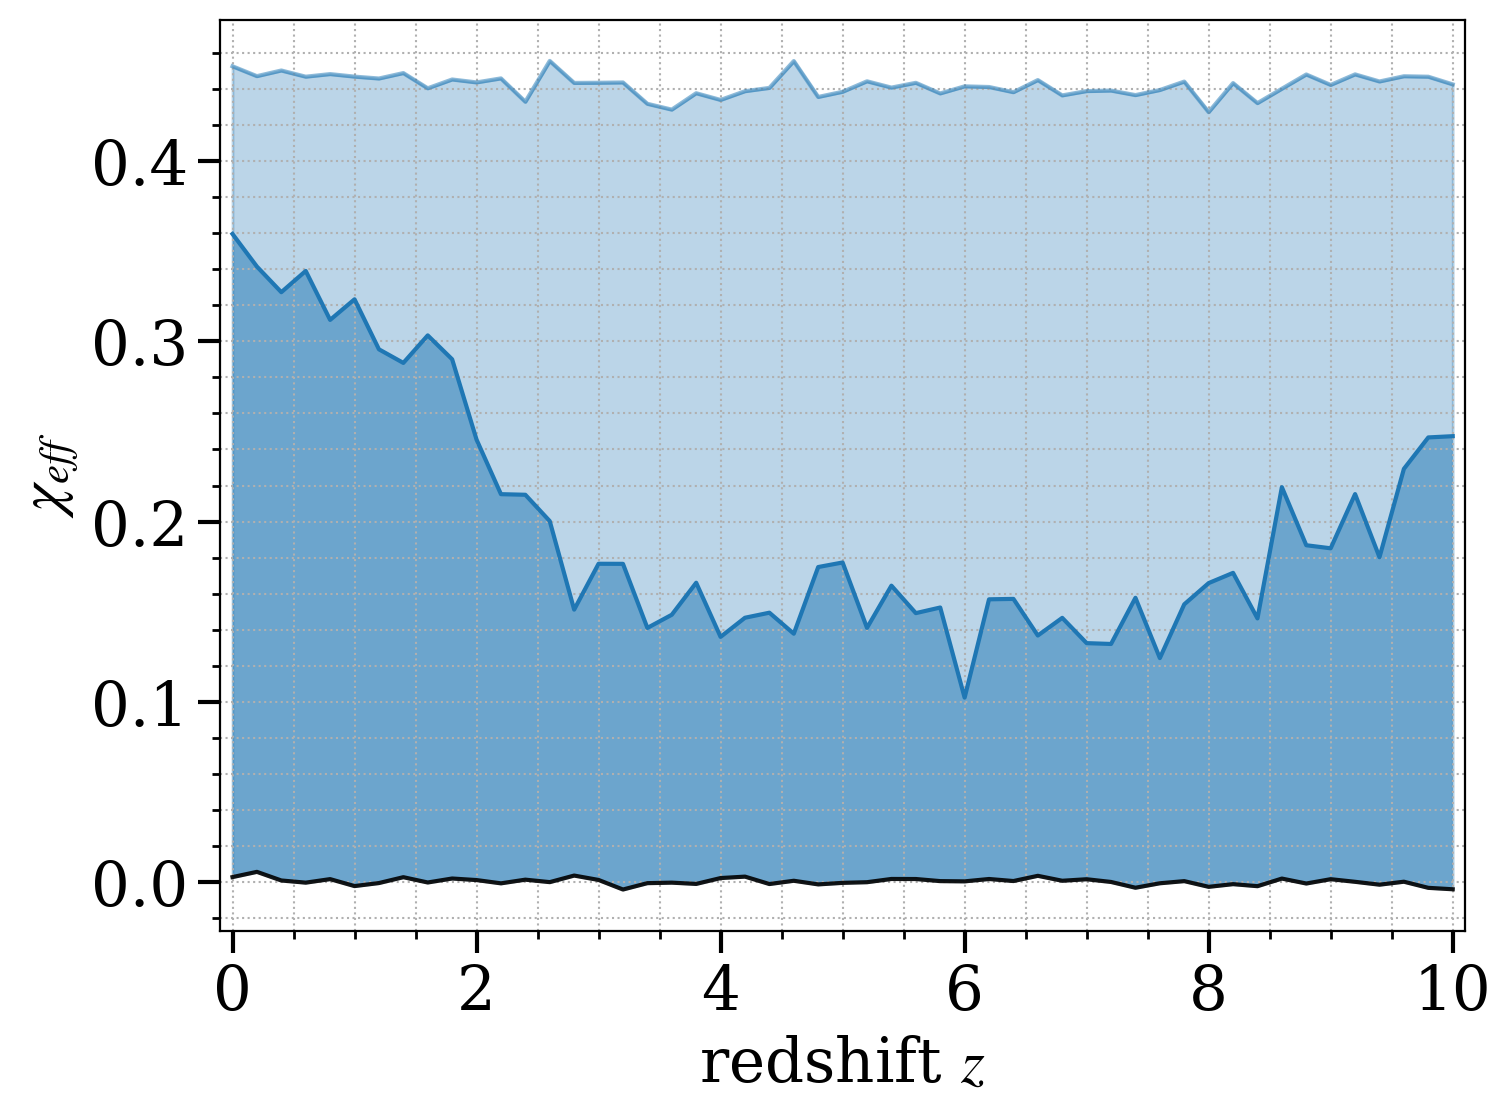

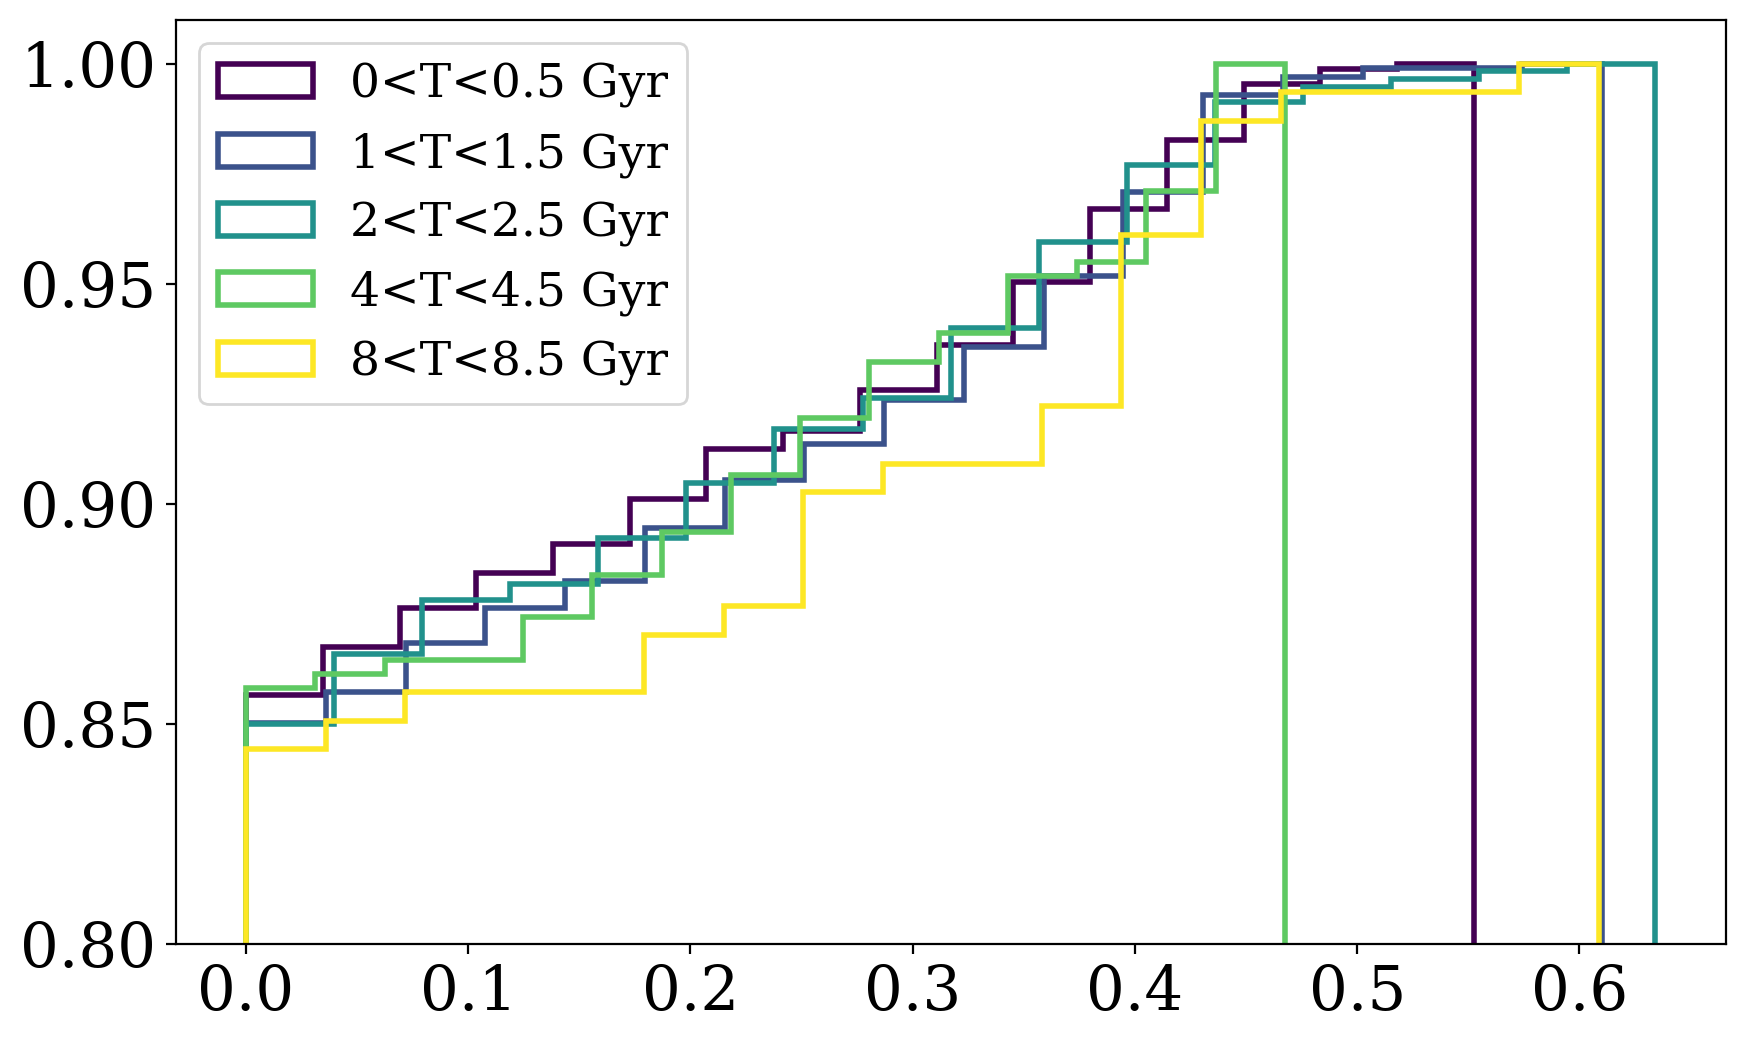

In [46]:
##effective spin distribution as a function of redshift
from importlib import reload
reload(gcr)

def chieff_redshift(zmin, zmax, dz = 0.2, z_gc = 2.2, a = 2.6, b = 3.6, dNdV0 = 2.31e9, 
                      logf_disrupted_cluster = logf_disrupted_cluster_norm, sigma_dex = 0.5, Zsun = 0.02,
                     mu_rv = 2, sigma_rv = 2, beta = -2, logMstar0 = 6.26, logMlo = 4, logMhi = 8):
    z_c = np.arange(zmin, zmax + dz, step = dz)
    sp_ave_z_c = [gcr.spin_redshift(bbh_data, z, 0.05, z_gc, a, b, dNdV0, 
                                      logf_disrupted_cluster, sigma_dex, 
                                   Zsun, mu_rv, sigma_rv, beta, logMstar0, logMlo, logMhi)[0] for z in z_c]
    #sp_std_z_c = [gcr.spin_redshift(bbh_data, z, 0.05, z_gc, a, b, dNdV0, 
    #                                  logf_disrupted_cluster, sigma_dex, 
    #                               Zsun, mu_rv, sigma_rv, beta, logMstar0, logMlo, logMhi)[1] for z in z_c]
    sp_z_c_pos_95 = [gcr.spin_redshift(bbh_data, z, 0.95, z_gc, a, b, dNdV0, 
                                      logf_disrupted_cluster, sigma_dex, 
                                   Zsun, mu_rv, sigma_rv, beta, logMstar0, logMlo, logMhi)[1][0] for z in z_c]
    #sp_z_c_neg_95 = [gcr.spin_redshift(bbh_data, z, 0.95, z_gc, a, b, dNdV0, 
    #                                  logf_disrupted_cluster, sigma_dex, 
    #                               Zsun, mu_rv, sigma_rv, beta, logMstar0, logMlo, logMhi)[2][0] for z in z_c]
    sp_z_c_pos_99 = [gcr.spin_redshift(bbh_data, z, 0.99, z_gc, a, b, dNdV0, 
                                      logf_disrupted_cluster, sigma_dex, 
                                   Zsun, mu_rv, sigma_rv, beta, logMstar0, logMlo, logMhi)[1][0] for z in z_c]
    #sp_z_c_neg_99 = [gcr.spin_redshift(bbh_data, z, 0.99, z_gc, a, b, dNdV0, 
    #                                  logf_disrupted_cluster, sigma_dex, 
    #                               Zsun, mu_rv, sigma_rv, beta, logMstar0, logMlo, logMhi)[2][0] for z in z_c]
    
        
    return z_c, sp_z_c_pos_95, sp_z_c_pos_99, sp_ave_z_c#, sp_std_z_c


zp_grid, sp_pos_grid_95, sp_pos_grid_99, sp_ave_grid = chieff_redshift(0,10) #, sp_ave_grid, sp_std_grid

#sp_ave_grid = np.array(sp_ave_grid); sp_std_grid = np.array(sp_std_grid)

fig, axs = plt.subplots(figsize=(8,6))
axs.plot(zp_grid, sp_ave_grid, color='k', alpha=0.9, zorder=2)
#axs.fill_between(zp_grid, sp_ave_grid-sp_std_grid, sp_ave_grid+sp_std_grid, alpha=0.5, zorder=1)
#axs.plot(z_grid, mave_grid-mstd_grid, zorder=1)
#axs.plot(z_grid, mave_grid+mstd_grid, zorder=1, color = '#1f77b4')
#axs.plot(zp_grid, sp_neg_grid_95, color='tab:blue')
axs.plot(zp_grid, sp_pos_grid_95, color='tab:blue')
#axs.plot(zp_grid, sp_neg_grid_99, color='tab:blue', alpha=0.5)
axs.plot(zp_grid, sp_pos_grid_99, color='tab:blue', alpha=0.5)
axs.fill_between(zp_grid, sp_ave_grid, sp_pos_grid_95, alpha=0.5, zorder=1)
axs.fill_between(zp_grid, sp_ave_grid, sp_pos_grid_99, alpha=0.3, zorder=1, color='tab:blue')
axs.set_xlim(xmax=10.1, xmin=-0.1)
axs.set_ylabel(r'$\chi_{eff}$')
axs.set_xlabel(r'redshift $z$')
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params('both', length=8, width=1.5, which='major')
axs.tick_params('both', length=3, width=1, which='minor')
plt.grid(linestyle=':',which='major',linewidth='0.75')
plt.grid(linestyle=':',which='minor',linewidth='0.75')
#plt.gca().xaxis.set_ticks_position('both')
#plt.gca().yaxis.set_ticks_position('both')
#plt.tick_params('both',length=3,width=0.5,which='both',direction = 'in')
fig.tight_layout()

#plt.savefig(savepath+'ave_percentiles_m_z.pdf', dpi=300)

chieff_sel_abs = np.abs(chieff_sel)
cs = cm.viridis(np.linspace(0, 1, 5))
cmap=matplotlib.colors.ListedColormap([cs[ii] for ii in range(len(cs))])
fig, axs = plt.subplots(figsize=(10, 6), sharey=True)
axs.hist(chieff_sel_abs[(tmer_sel>0.) & (tmer_sel<=500.)], bins=16,
         cumulative=True, density=True,
         histtype='step', label = '0<T<0.5 Gyr', lw=2, color=cs[0])
axs.hist(chieff_sel_abs[(tmer_sel>1000.) & (tmer_sel<=1500.)], bins=17,
         cumulative=True, density=True,
        histtype='step', label = '1<T<1.5 Gyr', lw=2, color=cs[1]) 
axs.hist(chieff_sel_abs[(tmer_sel>2000.) & (tmer_sel<=2500.)], bins=16,
         cumulative=True, density=True,
        histtype='step', label = '2<T<2.5 Gyr', lw=2, color=cs[2]) 
axs.hist(chieff_sel_abs[(tmer_sel>4000.) & (tmer_sel<=4500.)], bins=15,
         cumulative=True, density=True,
        histtype='step', label = '4<T<4.5 Gyr', lw=2, color=cs[3])
axs.hist(chieff_sel_abs[(tmer_sel>8000.) & (tmer_sel<=8500.)], bins=17,
         cumulative=True, density=True,
        histtype='step', label = '8<T<8.5 Gyr', lw=2, color=cs[4])
#axs.set_yscale('log')
axs.set_ylim(ymin=0.8, ymax=1.01)
axs.legend(loc='upper left', fontsize=17)
print(len(chieff_sel[(tmer_sel>0.) & (tmer_sel<=500.) & (chieff_sel>0.2)])/len(chieff_sel[(tmer_sel>0.) & (tmer_sel<=500.)]))
print(len(chieff_sel[(tmer_sel>1000.) & (tmer_sel<=1500.) & (chieff_sel>0.2)])/len(chieff_sel[(tmer_sel>1000.) & (tmer_sel<=1500.)]))
print(len(chieff_sel[(tmer_sel>2000.) & (tmer_sel<=2500.) & (chieff_sel>0.2)])/len(chieff_sel[(tmer_sel>2000.) & (tmer_sel<=2500.)]))
print(len(chieff_sel[(tmer_sel>3000.) & (tmer_sel<=3500.) & (chieff_sel>0.2)])/len(chieff_sel[(tmer_sel>3000.) & (tmer_sel<=3500.)]))

/tmp/ipykernel_3946204/1176923230.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3946204/1176923230.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


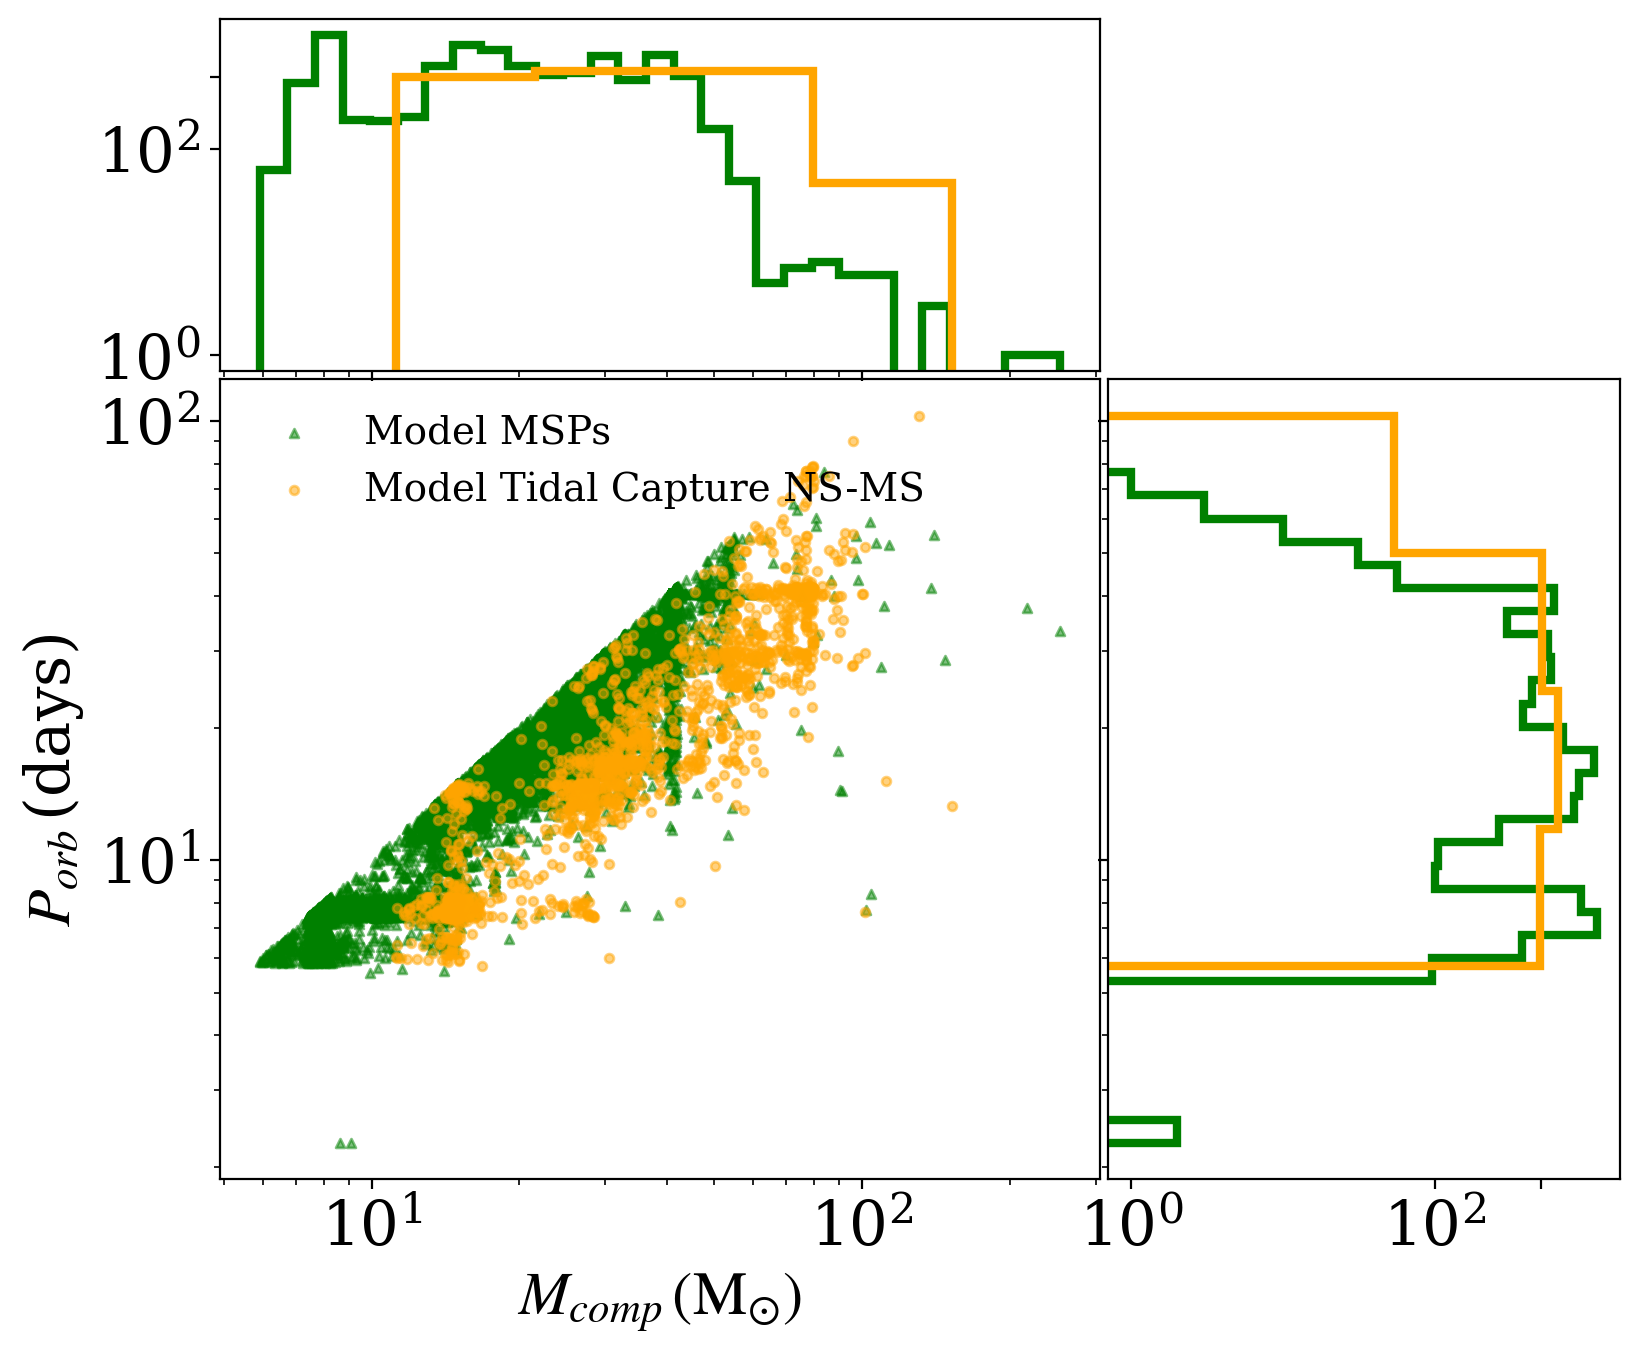

In [14]:
def scatter_hist(x1, y1, x2, y2, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x1, y1, s = 10,  label = 'Model MSPs', marker = '^', color = 'green', alpha=0.5)
    ax.scatter(x2, y2, s=10, label = 'Model Tidal Capture NS-MS', alpha = 0.5, color = 'orange')

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x1)), np.max(np.abs(y1)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    #print(bins)
    ax_histx.hist(x1, bins=np.logspace(np.log10(np.min(x1)), np.log10(np.max(x1)), 30), 
                  log=True, color = 'green', histtype = 'step', lw = 3)
    ax_histy.hist(y1, bins=np.logspace(np.log10(np.min(y1)), np.log10(np.max(y1)), 30), orientation='horizontal',
                 log=True, color = 'green', histtype = 'step', lw = 3)
    ax_histx.hist(x2, bins=np.logspace(np.log10(np.min(x2)), np.log10(np.max(x2)), 5), 
                  log=True, color = 'orange', histtype = 'step', lw = 3)
    ax_histy.hist(y2, bins=np.logspace(np.log10(np.min(y2)), np.log10(np.max(y2)), 5), orientation='horizontal',
                 log=True, color = 'orange', histtype = 'step', lw = 3)
    
    #ax.set_xlim(xmin = 0.004, xmax = 1.5)
    #ax.set_ylim(ymin = 0.01, ymax = 300)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$M_{comp}\, (\rm{M_{\odot}})$')
    ax.set_ylabel(r'$P_{orb}\,$(days)')
    ax.legend(loc = 'upper left', fontsize = 14, frameon = False)
    
    
    ax_histx.set_yticks([1., 100., 500.])
    ax_histy.set_xticks([1., 100., 500.])
    
    fig.tight_layout()

##plotting
# definitions for the axes
left, width = 0.1, 0.55
bottom, height = 0.1, 0.5
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.22]
rect_histy = [left + width + spacing, bottom, 0.32, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(M0_sel[gm_sel==1], M1_sel[gm_sel==1], M0_sel[gm_sel==2], M1_sel[gm_sel==2], ax, ax_histx, ax_histy)
fig.tight_layout()

5 9 0
11234 1528 9 0
373 58


Text(0, 0.5, '$M_1\\,[M_{\\odot}]$')

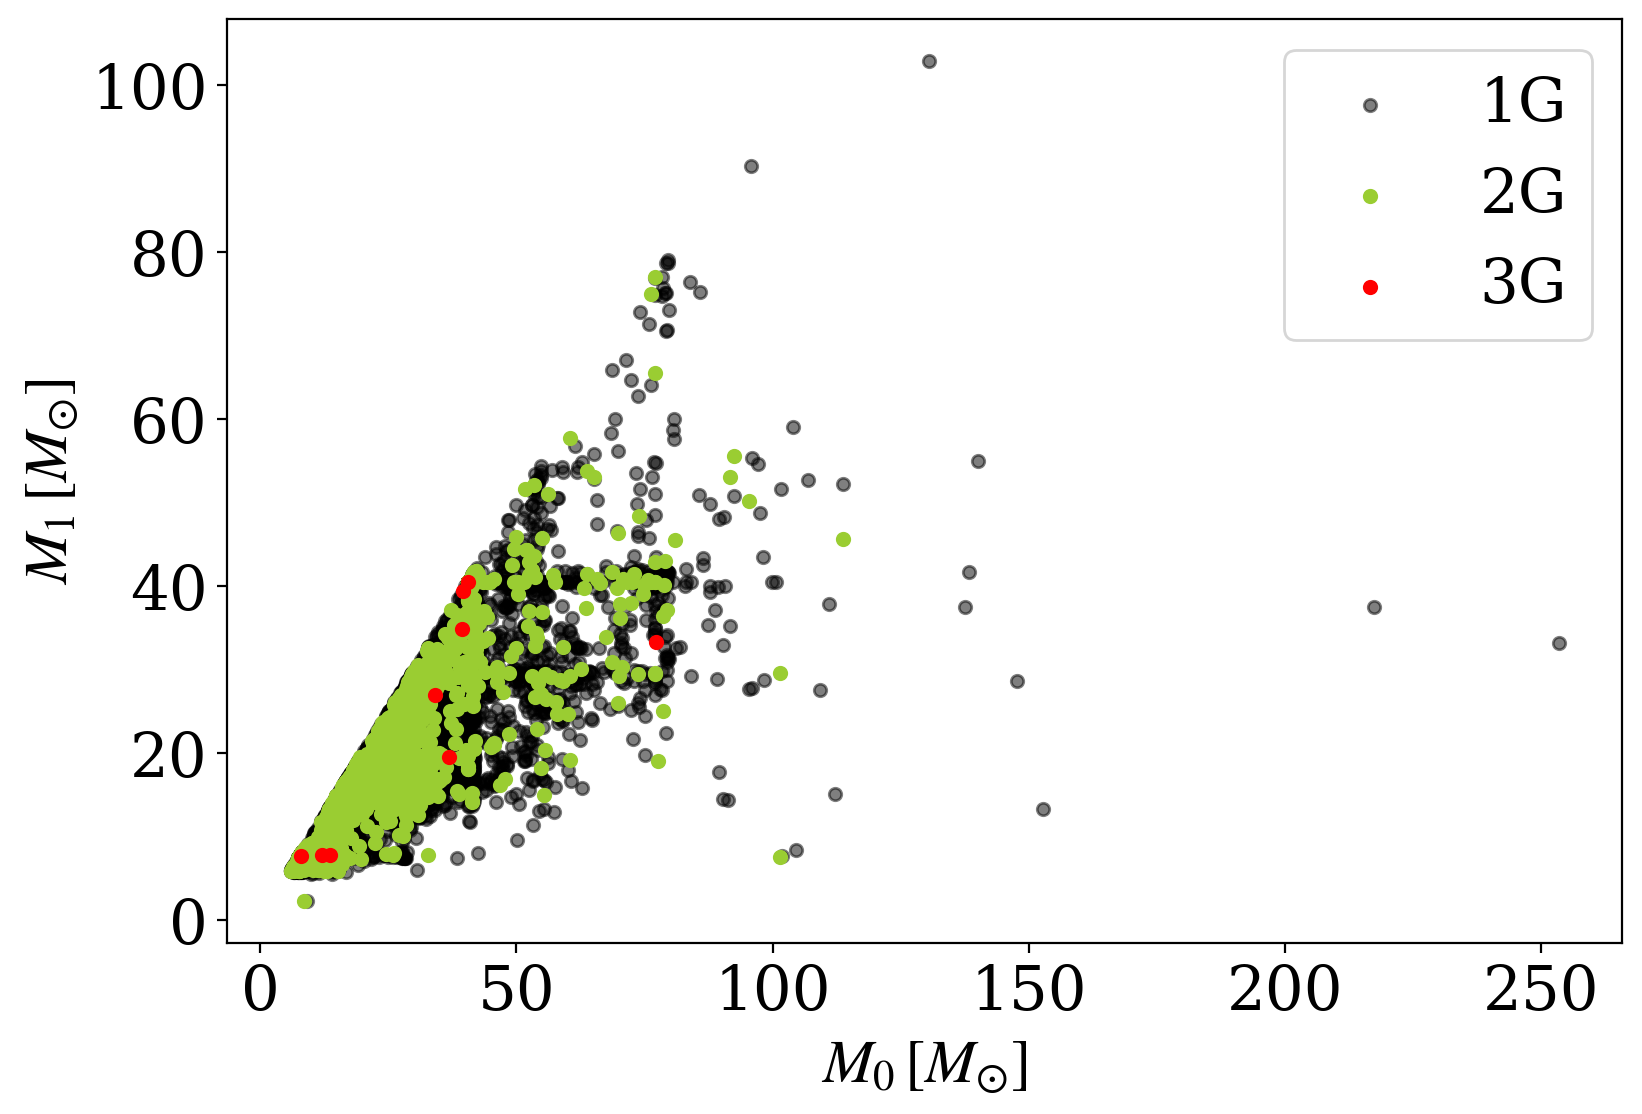

In [73]:
##Check repeated mergers
##not used here
M0 = np.maximum(m0,m1)
M1 = np.minimum(m0,m1)
m0 = np.array(m0); m1 = np.array(m1)
mtot = m0+m1
t_mer = np.array(t_mer)


t_hub = 14000.

model_no = []
IDM = []; IDs = [[],[]]; bbh_type = []; t_mer = []
repeater = []  ##11-1G, 12 or 21-one 2G, etc

bbh_col = np.genfromtxt(savepath+'GWcap_BBH_maingrid.dat')
num_col = bbh_col[:,3]
bbh_mer = np.genfromtxt(savepath+'Incluster_BBH_maingrid.dat')
bbh_esc = np.genfromtxt(savepath+'Esc_BBH_maingrid.dat')
t_merger = bbh_esc[:,2]+bbh_esc[:,3]


IDM = IDM+list(bbh_col[:,4][num_col==2])
IDs[0] = IDs[0]+list(bbh_col[:,5][num_col==2])
IDs[1] = IDs[1]+list(bbh_col[:,6][num_col==2])
bbh_type = bbh_type+list(np.full_like(bbh_col[:,10][num_col==2], 1))
t_mer = t_mer + list(bbh_col[:,2][num_col==2])
model_no = model_no+list(bbh_col[:,0][num_col==2])

IDM = IDM+list(bbh_mer[:,3])
IDs[0] = IDs[0]+list(bbh_mer[:,4])
IDs[1] = IDs[1]+list(bbh_mer[:,5])
bbh_type = bbh_type+list(np.full_like(bbh_mer[:,7], 2))
t_mer = t_mer + list(bbh_mer[:,2])
model_no = model_no+list(bbh_mer[:,0])

IDM = IDM+list(np.full_like(bbh_esc[:,4][t_merger<=t_hub], -100))
IDs[0] = IDs[0]+list(bbh_esc[:,6][t_merger<=t_hub])
IDs[1] = IDs[1]+list(bbh_esc[:,7][t_merger<=t_hub])
bbh_type = bbh_type+list(np.full_like(bbh_esc[:,4][t_merger<=t_hub], 3))
t_mer = t_mer + list(t_merger[t_merger<=t_hub])
model_no = model_no+list(bbh_esc[:,0][t_merger<=t_hub])


unique_modelno = np.unique(model_no)
model_no = np.array(model_no)
IDM = np.array(IDM)
IDs[0] = np.array(IDs[0]); IDs[1] = np.array(IDs[1])
bbh_type = np.array(bbh_type)
t_mer = np.array(t_mer)
print(len(IDM[IDM==0]), len(IDs[0][IDs[0]==0]), len(IDs[1][IDs[1]==0]))
#print(model_no[(IDM==0) | (IDs[0]==0) | (IDs[1]==0)])


##marking repeated mergers
gen_mer = [[],[],[]]
for xx in range(len(unique_modelno)): #
    #print(xx, unique_modelno[xx])
    
    tmer_model = t_mer[(model_no==unique_modelno[xx])]# & (IDM!=0)]
    IDM_model = IDM[(model_no==unique_modelno[xx])]# & (IDM!=0)]
    ID0_model = IDs[0][(model_no==unique_modelno[xx])]# & (IDM!=0)]
    ID1_model = IDs[1][(model_no==unique_modelno[xx])]# & (IDM!=0)]
    
    index_sort = np.argsort(tmer_model)
    #print(tmer_model[index_sort])
    
    IDM_sort = IDM_model[index_sort]
    ID0_sort = ID0_model[index_sort]
    ID1_sort = ID1_model[index_sort]
    
    check = [np.full_like(IDM_sort, 1), np.full_like(IDM_sort, 1), np.full_like(IDM_sort, 1)]
    yy = 1
    while yy < len(IDM_sort):
        #print(IDM_sort[:yy], ID0_sort[yy], ID1_sort[yy])
        if ID0_sort[yy] in IDM_sort[:yy]:
            index_check = np.where(IDM_sort[:yy]==ID0_sort[yy])[0]
            check[0][yy] = check[0][yy]+check[2][index_check[-1]]
                
        if ID1_sort[yy] in IDM_sort[:yy]:
            index_check = np.where(IDM_sort[:yy]==ID1_sort[yy])[0]
            check[1][yy] = check[1][yy]+check[2][index_check[-1]]
            
        check[2][yy]=np.maximum(check[0][yy], check[1][yy])
           
        yy+=1
            
    gen_mer[0] = gen_mer[0]+list(check[2])
    gen_mer[1] = gen_mer[1]+list(check[0])
    gen_mer[2] = gen_mer[2]+list(check[1])
    
    
gen_mer[0]=np.array(gen_mer[0])
gen_mer[1]=np.array(gen_mer[1])
gen_mer[2]=np.array(gen_mer[2])

print(len(gen_mer[0]), len(gen_mer[0][gen_mer[0]==2]), len(gen_mer[0][gen_mer[0]==3]), len(gen_mer[0][gen_mer[0]==4]))

from IPython.display import display
  
# creating a DataFrame
dict = {'tmer [Myr]' : tmer_model[index_sort],
        'IDM' : IDM_sort,
        'ID0' : ID0_sort,
        'ID1' : ID1_sort,
        'type': bbh_type[(model_no==unique_modelno[xx]) & (IDM!=0)][index_sort],
        'check2': check[2],
        'check0': check[0],
        'check1': check[1]}
df = pd.DataFrame(dict)
  
# displaying the DataFrame
#pd.set_option('display.max_rows', None)
#display(df)


##Mass of different gen mergers
fig, axs = plt.subplots(figsize=(9,6))
axs.hist(m_chirp[gen_mer[0]==1], bins=25,
         lw=3, histtype='step', color='k', label = '1G')
axs.hist(m_chirp[gen_mer[0]==2], bins=17,
         lw=3, histtype='step', color='forestgreen', label = '2G')
axs.hist(m_chirp[gen_mer[0]==3], 
         lw=3, histtype='step', color='gold', label = '3G')
axs.set_yscale('log')
axs.legend(loc='best')
axs.set_xlabel('Chirp Mass')
axs.set_ylabel(r'$N$')

print(len(m_chirp[(m_chirp>=40) & (gen_mer[0]==1)]), len(m_chirp[(m_chirp>=40) & (gen_mer[0]==2)]))

fig, axs = plt.subplots(figsize=(9,6))
axs.scatter(M0[gen_mer[0]==1], M1[gen_mer[0]==1],
          color='k', alpha=0.5, s=20, label = '1G')
axs.scatter(M0[gen_mer[0]==2], M1[gen_mer[0]==2],
         color='yellowgreen', s=20, label = '2G')
axs.scatter(M0[gen_mer[0]==3], M1[gen_mer[0]==3],
         color='red', s=20, label = '3G')
#axs.set_yscale('log')
#axs.set_xscale('log')
axs.legend(loc='best')
axs.set_xlabel(r'$M_0\,[M_{\odot}]$')
axs.set_ylabel(r'$M_1\,[M_{\odot}]$')

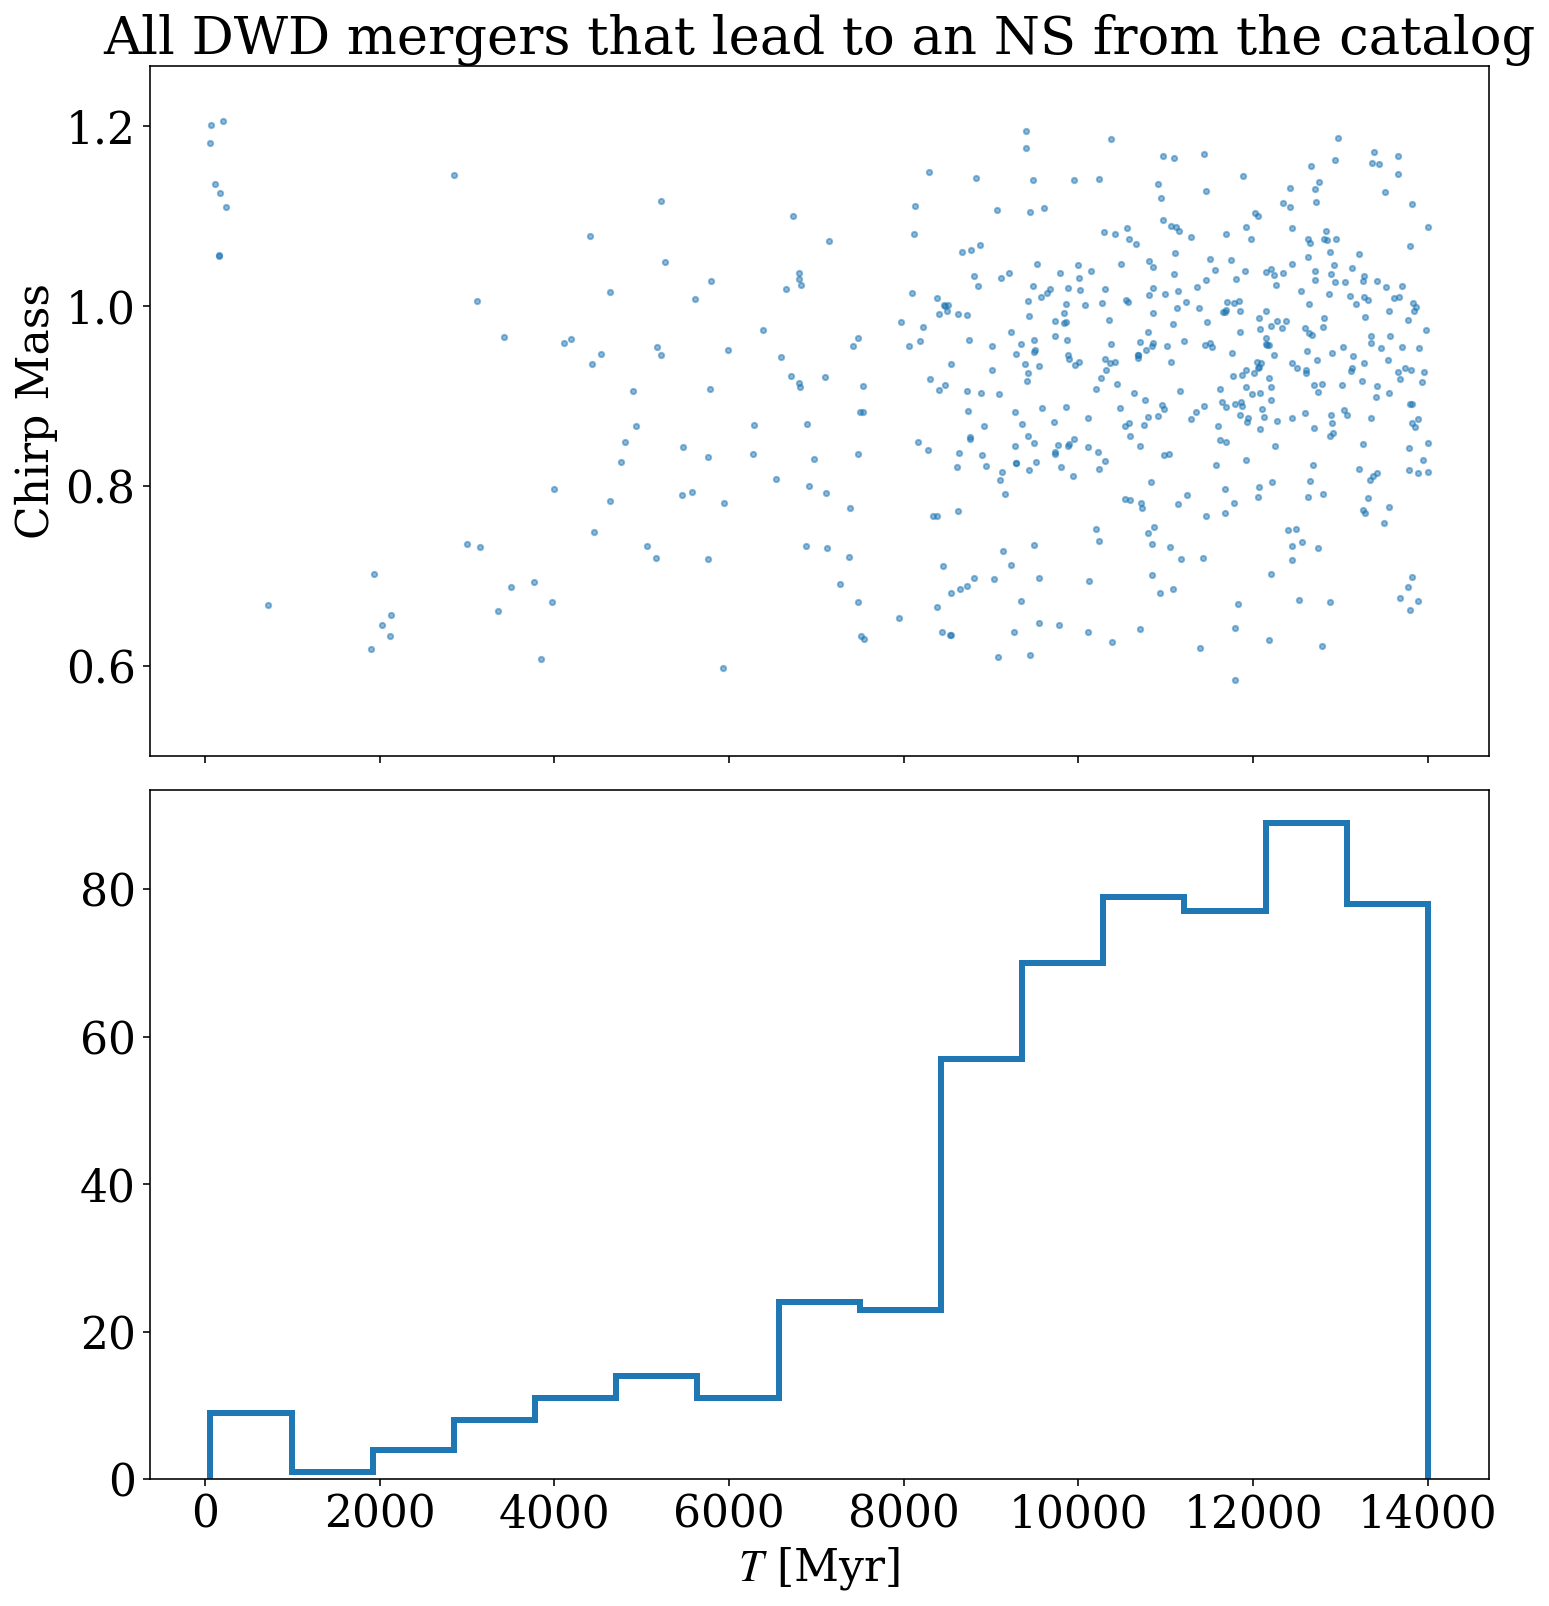

In [11]:
###import merger data; WD-WD where the remnant is a NS
m0_wd = []; m1_wd = []; dwd_type = []; t_mer_wd = []

ns_allcol = np.genfromtxt('/projects/b1095/syr904/projects/SGRB/newruns/finaldata/ns_collproduct_all.dat')
k0_col = ns_allcol[:,10]; k1_col = ns_allcol[:,11]; k2_col = ns_allcol[:,12]
ns_allmer = np.genfromtxt('/projects/b1095/syr904/projects/SGRB/newruns/finaldata/ns_mergerproduct_all.dat')
k0_mer = ns_allmer[:,8]; k1_mer = ns_allmer[:,9]

m0_wd = m0_wd+list(ns_allcol[:,5][(k0_col>=10) & (k0_col<=12) & (k1_col>=10) & (k1_col<=12) & (k2_col==-100)])
m1_wd = m1_wd+list(ns_allcol[:,6][(k0_col>=10) & (k0_col<=12) & (k1_col>=10) & (k1_col<=12) & (k2_col==-100)])
t_mer_wd = t_mer_wd+list(ns_allcol[:,1][(k0_col>=10) & (k0_col<=12) & (k1_col>=10) & (k1_col<=12) & (k2_col==-100)])
dwd_type = dwd_type+list(np.full_like(ns_allcol[:,5][(k0_col>=10) & (k0_col<=12) & (k1_col>=10) & (k1_col<=12) & (k2_col==-100)],
                                      1))

m0_wd = m0_wd+list(ns_allmer[:,5][(k0_mer>=10) & (k0_mer<=12) & (k1_mer>=10) & (k1_mer<=12)])
m1_wd = m1_wd+list(ns_allmer[:,6][(k0_mer>=10) & (k0_mer<=12) & (k1_mer>=10) & (k1_mer<=12)])
t_mer_wd = t_mer_wd+list(ns_allmer[:,1][(k0_mer>=10) & (k0_mer<=12) & (k1_mer>=10) & (k1_mer<=12)])
dwd_type = dwd_type+list(np.full_like(ns_allmer[:,5][(k0_mer>=10) & (k0_mer<=12) & (k1_mer>=10) & (k1_mer<=12)],2))

m_chirp_wd = chirp_mass(np.array(m0_wd), np.array(m1_wd))

fig, axs = plt.subplots(nrows=2, figsize=(12,13), sharex=True)
axs[0].scatter(t_mer_wd, m_chirp_wd, s=7, alpha=0.5)
axs[1].hist(t_mer_wd, bins=15, histtype='step', lw=3)

#axs[0].set_yscale('log')
#axs[0].set_xscale('log')
axs[0].set_ylim(ymin=0.5)
axs[1].set_xlabel(r'$T$ [Myr]')
axs[0].set_ylabel('Chirp Mass')
axs[0].set_title('All DWD mergers that lead to an NS from the catalog')
plt.subplots_adjust(hspace=0.05)